# NIRSpec BOTS Pipeline Notebook

<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

**Authors**: Nikolay Nikolov (AURA Associate Scientist, nnikolov@stsci.edu); Kayli Glidic (kglidic@stsci.edu); NIRSpec branch</br>
**Last Updated**: August 5, 2025</br>
**Pipeline Version**: 1.19.1 (Build 12.0, Context jwst_1413.pmap)

**Purpose**:<br>
End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) Bright Object Time-Series (BOTS) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:<BR>
This notebook is set up to use transit observations of WASP-39b with the G395H grism, obtained by Proposal ID (PID) 1366, Observation 3. The demo data will automatically download unless disabled (i.e., to use local files instead).
 
**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<BR>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.** Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-bots-known-issues#gsc.tab=0) for this build are noted in the notebook.

**Updates**:<BR>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/). 

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template ([original](https://github.com/exonik/JWST-NIRSpec-STScI-pipeline-rerun/blob/main/BOTS_pipeline_rerun.ipynb)).</br>
* November 6, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* February 3, 2025: Notebook updated to JWST pipeline version 1.17.1 (Build 11.2)
* April 18, 2025: Notebook updated to JWST pipeline version 1.18.0 (Build 11.3) added curved trace extraction.
* July 16, 2025: Updated to JWST pipeline version 1.19.1 (update plotting to work with new spectral data table format)

---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` ASN Files](#6.2-Create-Spec2Pipeline-ASN-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
* [7. Stage 3: `Tso3Pipeline` (`calwebb_tso3`)](#5.-Stage-3:-Tso3Pipeline-(calwebb_tso3))
    * [7.1 Configure `Tso3Pipeline`](#7.1-Configure-Tso3Pipeline)
    * [7.2 Create `Tso3Pipeline` ASN Files](#7.2-Create-Tso3Pipeline-ASN-Files)
    * [7.3 Run `Tso3Pipeline`](#7.3-Run-Tso3Pipeline)
* [8. Visualizing the Data](#8.-Vusualizing-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec2Pipeline` Products](#8.2-Display-Spec2Pipeline-Products)
    * [8.3 Display `Tso3Pipeline` Products](#8.3-Display-Tso3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))

---

## 1. Configuration
### Install dependencies and parameters

To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh Conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_bots_pipeline python=3.12
    conda activate nirspec_bots_pipeline
    pip install -r requirements.txt

Set the basic parameters to configure the notebook. These parameters determine what data gets used and where the data is located (if already on disk). The list of parameters includes:

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.


In [1]:
# Basic import necessary for configuration.
# Uncomment logging to hide log information.

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command logging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'bots_data_01366/Obs003', '')

# ---------------------------Set Processing Steps----------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dotso3 = True  # calwebb_tso3
doviz = True  # Visualize calwebb outputs

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server

Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.

[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1413.pmap'  # CRDS context for 1.19.1

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import glob
import json
import itertools
import numpy as np

# -------------------- Astroquery Imports ----------------------
from astroquery.mast import Observations

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from jwst.extract_1d.extract import location_from_wcs

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst)

</div> 

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Tso3Pipeline  # calwebb_tso3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities
from jwst import datamodels  # JWST pipeline utilities: datamodels.
from jwst.associations import asn_from_list as afl  # Tools for creating association files.
from jwst.associations.lib.rules_level2b import Asn_Lv2SpecTSO
from jwst.associations.lib.rules_level3 import DMS_Level3_Base

# Check the default context for the Pipeline version
default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/jwst-1.19.1.dist-info)


JWST Calibration Pipeline Version = 1.19.1
Default CRDS Context for JWST Version 1.19.1: jwst_1413.pmap
Using CRDS Context: jwst_1413.pmap


---
### Define Convenience Functions

Define a function that filters files based on detector, filter, grating, etc.

In [7]:
def get_matching(files, detector, filt, grating, fxd_slit, exp_type):
    """
    Filters a list of FITS files to find those with matching 
    detector, filter, and grating for a specified exposure type.

    Parameters
    ----------
    files : list of str
        Paths to FITS files to check.
    detector : str
        Expected value of the DETECTOR keyword.
    filt : str
        Expected value of the FILTER keyword.
    grating : str
        Expected value of the GRATING keyword.
    fxd_slit : str
        Fixed slit name.
    exp_type : str, optional
        The exposure type to match.

    Returns
    -------
    files_regular : list of str
        Files with matching configuration and IS_IMPRT == False or missing.
    files_imprint : list of str)
        Files with matching configuration and IS_IMPRT == True.
    """
    files_regular, files_imprint = [], []
    for file in files:
        # Skip if EXP_TYPE doesn't match the provided one.
        if fits.getval(file, 'EXP_TYPE') != exp_type:
            files_regular.append(file)
            continue
        # Check if DETECTOR, FILTER, GRATING, and SLIT match
        detector_match = fits.getval(file, 'DETECTOR') == detector
        filter_match = fits.getval(file, 'FILTER') == filt
        grating_match = fits.getval(file, 'GRATING') == grating
        slit_match = fits.getval(file, 'FXD_SLIT') == fxd_slit
        if detector_match and filter_match and grating_match and slit_match:
            # Only IFU and MOS observations have imprint exposures.
            try:
                is_imprt = fits.getval(file, 'IS_IMPRT')
            except KeyError:
                is_imprt = None
            (files_imprint if is_imprt else files_regular).append(file)
    return files_regular, files_imprint

In [8]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---

## 3. Demo Mode Setup (ignore if not using demo data)

<div class="alert alert-block alert-info">

The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit the [astroquery](https://astroquery.readthedocs.io/en/latest/index.html) documentation.
</div> 

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The BOTS demo data in this notebook is from the [JWST Early Release Science (ERS) program 1366](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366) and features transit observations of WASP-39b using the G395H grism. The program setup is briefly summarized in the table below.

| Demo Target: WASP-39b |       |   | 
|:-----------:|:-------:|:---:|
| PROGRAM | 01366 |  Program number | 
| OBSERVTN | 003 | Observation number | 
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-bright-object-time-series-spectroscopy#gsc.tab=0) | G395H/F290LP | λ: 2.87–5.14 μm (a high resolution, R ~ 2700) |
| SUBARRAY | SUB2048 | Subarray used (2048x32 pixels per integration, per group) | 
| NINTS | 465 |  Number of integrations in exposure  |           
| NGROUPS | 70 | Number of groups in integration  |
| DURATION | 29789.053 [s] | Total duration of one exposure |   
| READPATT | NRSRAPID | Readout pattern |  
| PATTTYPE | NONE | Primary dither pattern type |  
| NUMDTHPT | 1 |  Total number of points in pattern |                           
| SRCTYAPT | UNKNOWN | Source type selected in APT | 

> **Note:** The presence of a physical gap between detectors affects high-resolution BOTS observations because the spectra are long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-bots-operations/nirspec-bots-wavelength-ranges-and-gaps#gsc.tab=0)
>

Many TSO exposures may contain a sufficiently large number of integrations (NINTS) so as to make their individual exposure products too large (in terms of file size on disk) to be able to handle conveniently. In these cases, the uncalibrated raw data for a given exposure are split into multiple “segmented” products, each of which is identified with a segment number (see segmented products). 

Information about existing and planned JWST TSO programs for transiting exoplanets, including with the NIRSpec BOTS mode, can be obtained from [TrExoLiSTS](https://www.stsci.edu/~nnikolov/TrExoLiSTS/JWST/trexolists.html) 

In [9]:
# Set up the program information for demo mode.

if demo_mode:
    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # The data in this notebook is public and does not require a token.
    # For other data sets, you may need to provide a token.
    # Observations.login(token=None)

    # --------------Program and observation information--------------
    program = "01366"
    sci_observtn = "003"
    bg_observtn = None
    filters = ["F290LP;G395H"]

    # ----------Define the base and observation directories----------
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))
    sci_dir = os.path.join(basedir, f'Obs{sci_observtn}')
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    os.makedirs(uncal_dir, exist_ok=True)
else:
    print('Running with user provided data.')

Running in demonstration mode. Example data will be downloaded from MAST!


<br>Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile a table of files from MAST associated with the science (SCI) observation.

In [10]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/SLIT'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

Filter these tables to identify uncalibrated data and their association files for download from MAST.

The demo dataset consists of six segments of `_uncal.fits` files, each approximately 1.42 GB in size.

In [11]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:
    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads = []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}

    print(f"Science files selected for downloading: {len(sci_downloads)}")

Science files selected for downloading: 6


Downoload the data
<div class="alert alert-block alert-warning">
    
**Warning:** If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [12]:
# Download data and place them into the appropriate directories.
if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


## 4. Directory Setup

Set up detailed paths to input/output stages here.

In [13]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
tso3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_tso3 pipeline outputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Association directory.

os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(tso3_dir, exist_ok=True)
os.makedirs(asn_dir, exist_ok=True)

In [14]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 1.2000 min


---

## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing. 

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec BOTS:

> * `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
> * `dq_init` : Initializes the data quality (DQ) flags for the input data.
> * `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
> * `superbias` : Subtracts the superbias reference file from the input data.
> * `refpix` : Use reference pixels to correct bias drifts.
> * `linearity` : Applies a correction for non-linear detector response.   
> * `dark_current` : Subtracts the dark current reference file from the input data.
> * `jump` : Performs CR/jump detection on each ramp integration within an exposure.
> * `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
> * `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for BOTS data. 

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>


In [15]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'], det1dict['linearity'] = {}, {}, {}
det1dict['dark_current'], det1dict['jump'], det1dict['clean_flicker_noise'] = {}, {}, {}
det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}

# ---------------------------Override reference files---------------------------
# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# -----------------------------Set step parameters------------------------------
# Overrides for whether or not certain steps should be skipped (example).
#det1dict['linearity']['skip'] = True  # This is the default.

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'quarter'
#det1dict['ramp_fit']['maximum_cores'] = 'half'

<div class="alert alert-info">
    
Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

In [16]:
# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)

<div class="alert alert-info">
    
JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. If not handled properly, the 1/f noise can introduce systematic errors and extra scatter in BOTS light curves. For more information, please visit [JWST Time-Series Observations Noise Sources](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-1/fnoise&gsc.tab=0).

For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) and is off by default. However, we turned on in Stage 2. An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

In [17]:
# Turn on 1/f noise correction in Stage 1? (off by default).
#det1dict['clean_flicker_noise']['skip'] = False

---

### 5.2 Run `Detector1Pipeline`

Run the science files through the `calwebb_detector1` pipeline using the `.call()` method. 

We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).


In [18]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))

print(f"Science UNCAL Files:\n{'-' * 20}\n" + "\n".join(uncal_sci))

Science UNCAL Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs2_uncal.fits


In [19]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

if dodet1:
    # ---------------------Science UNCAL files---------------------
    for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):
        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             # To save calibrated ramps set to True.
                                             save_calibrated_ramp=False,  # Default True.
                                             output_dir=det1_dir)

        print("... Stage 1 has been completed!\n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg001_nrs1_uncal.fits


2025-09-24 14:55:59,896 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/jwst-1.19.1.dist-info)


2025-09-24 14:56:00,138 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 206 files) (0 / 754.6 K bytes)


2025-09-24 14:56:00,269 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0054.rmap    5.5 K bytes  (2 / 206 files) (694 / 754.6 K bytes)


2025-09-24 14:56:00,377 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0053.imap      385 bytes  (3 / 206 files) (6.2 K / 754.6 K bytes)


2025-09-24 14:56:00,506 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 206 files) (6.6 K / 754.6 K bytes)


2025-09-24 14:56:00,612 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 206 files) (8.0 K / 754.6 K bytes)


2025-09-24 14:56:00,717 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0081.rmap   36.1 K bytes  (6 / 206 files) (8.8 K / 754.6 K bytes)


2025-09-24 14:56:00,840 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sirskernel_0002.rmap      704 bytes  (7 / 206 files) (44.9 K / 754.6 K bytes)


2025-09-24 14:56:00,944 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sflat_0027.rmap   20.6 K bytes  (8 / 206 files) (45.6 K / 754.6 K bytes)


2025-09-24 14:56:01,069 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 206 files) (66.2 K / 754.6 K bytes)


2025-09-24 14:56:01,175 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 206 files) (68.2 K / 754.6 K bytes)


2025-09-24 14:56:01,279 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 206 files) (69.8 K / 754.6 K bytes)


2025-09-24 14:56:01,385 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 206 files) (72.4 K / 754.6 K bytes)


2025-09-24 14:56:01,495 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 206 files) (73.1 K / 754.6 K bytes)


2025-09-24 14:56:01,601 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 206 files) (74.0 K / 754.6 K bytes)


2025-09-24 14:56:01,713 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 206 files) (75.2 K / 754.6 K bytes)


2025-09-24 14:56:01,825 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 206 files) (76.0 K / 754.6 K bytes)


2025-09-24 14:56:01,992 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 206 files) (78.1 K / 754.6 K bytes)


2025-09-24 14:56:02,101 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-refpixstep_0002.rmap      831 bytes  (18 / 206 files) (78.8 K / 754.6 K bytes)


2025-09-24 14:56:02,244 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (19 / 206 files) (79.6 K / 754.6 K bytes)


2025-09-24 14:56:02,356 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (20 / 206 files) (80.8 K / 754.6 K bytes)


2025-09-24 14:56:02,458 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (21 / 206 files) (81.6 K / 754.6 K bytes)


2025-09-24 14:56:02,564 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (22 / 206 files) (82.6 K / 754.6 K bytes)


2025-09-24 14:56:02,675 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (23 / 206 files) (83.7 K / 754.6 K bytes)


2025-09-24 14:56:02,776 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (24 / 206 files) (84.5 K / 754.6 K bytes)


2025-09-24 14:56:02,877 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (25 / 206 files) (86.3 K / 754.6 K bytes)


2025-09-24 14:56:02,981 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (26 / 206 files) (87.6 K / 754.6 K bytes)


2025-09-24 14:56:03,084 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (27 / 206 files) (89.1 K / 754.6 K bytes)


2025-09-24 14:56:03,186 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (28 / 206 files) (90.4 K / 754.6 K bytes)


2025-09-24 14:56:03,287 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (29 / 206 files) (93.9 K / 754.6 K bytes)


2025-09-24 14:56:03,389 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (30 / 206 files) (95.5 K / 754.6 K bytes)


2025-09-24 14:56:03,490 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (31 / 206 files) (96.4 K / 754.6 K bytes)


2025-09-24 14:56:03,628 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (32 / 206 files) (97.9 K / 754.6 K bytes)


2025-09-24 14:56:03,729 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (33 / 206 files) (99.4 K / 754.6 K bytes)


2025-09-24 14:56:03,837 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (34 / 206 files) (100.9 K / 754.6 K bytes)


2025-09-24 14:56:03,950 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (35 / 206 files) (102.7 K / 754.6 K bytes)


2025-09-24 14:56:04,062 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (36 / 206 files) (103.9 K / 754.6 K bytes)


2025-09-24 14:56:04,166 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (37 / 206 files) (108.9 K / 754.6 K bytes)


2025-09-24 14:56:04,268 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fflat_0027.rmap    7.2 K bytes  (38 / 206 files) (112.7 K / 754.6 K bytes)


2025-09-24 14:56:04,372 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (39 / 206 files) (119.9 K / 754.6 K bytes)


2025-09-24 14:56:04,474 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (40 / 206 files) (122.2 K / 754.6 K bytes)


2025-09-24 14:56:04,585 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (41 / 206 files) (127.9 K / 754.6 K bytes)


2025-09-24 14:56:04,686 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dark_0076.rmap   34.3 K bytes  (42 / 206 files) (129.0 K / 754.6 K bytes)


2025-09-24 14:56:04,808 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (43 / 206 files) (163.4 K / 754.6 K bytes)


2025-09-24 14:56:04,911 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (44 / 206 files) (164.3 K / 754.6 K bytes)


2025-09-24 14:56:05,014 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (45 / 206 files) (165.7 K / 754.6 K bytes)


2025-09-24 14:56:05,115 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (46 / 206 files) (166.9 K / 754.6 K bytes)


2025-09-24 14:56:05,227 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (47 / 206 files) (168.7 K / 754.6 K bytes)


2025-09-24 14:56:05,328 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (48 / 206 files) (175.0 K / 754.6 K bytes)


2025-09-24 14:56:05,433 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_0406.imap    5.8 K bytes  (49 / 206 files) (180.6 K / 754.6 K bytes)


2025-09-24 14:56:05,538 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0011.rmap    3.1 K bytes  (50 / 206 files) (186.4 K / 754.6 K bytes)


2025-09-24 14:56:05,641 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0008.rmap      897 bytes  (51 / 206 files) (189.5 K / 754.6 K bytes)


2025-09-24 14:56:05,747 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (52 / 206 files) (190.4 K / 754.6 K bytes)


2025-09-24 14:56:05,850 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (53 / 206 files) (191.2 K / 754.6 K bytes)


2025-09-24 14:56:05,951 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (54 / 206 files) (191.9 K / 754.6 K bytes)


2025-09-24 14:56:06,053 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_superbias_0031.rmap    7.7 K bytes  (55 / 206 files) (193.1 K / 754.6 K bytes)


2025-09-24 14:56:06,155 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specwcs_0015.rmap    3.1 K bytes  (56 / 206 files) (200.8 K / 754.6 K bytes)


2025-09-24 14:56:06,259 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (57 / 206 files) (203.9 K / 754.6 K bytes)


2025-09-24 14:56:06,360 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (58 / 206 files) (206.3 K / 754.6 K bytes)


2025-09-24 14:56:06,465 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_sirskernel_0002.rmap      700 bytes  (59 / 206 files) (207.4 K / 754.6 K bytes)


2025-09-24 14:56:06,568 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (60 / 206 files) (208.1 K / 754.6 K bytes)


2025-09-24 14:56:06,670 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (61 / 206 files) (208.9 K / 754.6 K bytes)


2025-09-24 14:56:06,778 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (62 / 206 files) (209.9 K / 754.6 K bytes)


2025-09-24 14:56:06,880 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (63 / 206 files) (211.1 K / 754.6 K bytes)


2025-09-24 14:56:06,992 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (64 / 206 files) (211.8 K / 754.6 K bytes)


2025-09-24 14:56:07,096 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (65 / 206 files) (212.6 K / 754.6 K bytes)


2025-09-24 14:56:07,199 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (66 / 206 files) (213.4 K / 754.6 K bytes)


2025-09-24 14:56:07,301 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (67 / 206 files) (214.3 K / 754.6 K bytes)


2025-09-24 14:56:07,404 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0009.rmap    1.2 K bytes  (68 / 206 files) (217.4 K / 754.6 K bytes)


2025-09-24 14:56:07,506 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (69 / 206 files) (218.6 K / 754.6 K bytes)


2025-09-24 14:56:07,611 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (70 / 206 files) (221.0 K / 754.6 K bytes)


2025-09-24 14:56:07,712 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (71 / 206 files) (221.6 K / 754.6 K bytes)


2025-09-24 14:56:07,820 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (72 / 206 files) (224.3 K / 754.6 K bytes)


2025-09-24 14:56:07,920 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (73 / 206 files) (230.7 K / 754.6 K bytes)


2025-09-24 14:56:08,022 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (74 / 206 files) (231.7 K / 754.6 K bytes)


2025-09-24 14:56:08,125 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (75 / 206 files) (232.7 K / 754.6 K bytes)


2025-09-24 14:56:08,227 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (76 / 206 files) (233.6 K / 754.6 K bytes)


2025-09-24 14:56:08,330 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0005.rmap    5.7 K bytes  (77 / 206 files) (234.2 K / 754.6 K bytes)


2025-09-24 14:56:08,430 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (78 / 206 files) (239.9 K / 754.6 K bytes)


2025-09-24 14:56:08,534 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_mask_0023.rmap    1.4 K bytes  (79 / 206 files) (240.5 K / 754.6 K bytes)


2025-09-24 14:56:08,637 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (80 / 206 files) (241.9 K / 754.6 K bytes)


2025-09-24 14:56:08,740 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (81 / 206 files) (242.9 K / 754.6 K bytes)


2025-09-24 14:56:08,838 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (82 / 206 files) (243.5 K / 754.6 K bytes)


2025-09-24 14:56:08,949 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (83 / 206 files) (244.3 K / 754.6 K bytes)


2025-09-24 14:56:09,060 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (84 / 206 files) (250.2 K / 754.6 K bytes)


2025-09-24 14:56:09,158 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (85 / 206 files) (251.1 K / 754.6 K bytes)


2025-09-24 14:56:09,261 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (86 / 206 files) (252.0 K / 754.6 K bytes)


2025-09-24 14:56:09,364 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (87 / 206 files) (252.5 K / 754.6 K bytes)


2025-09-24 14:56:09,465 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_dark_0035.rmap    7.8 K bytes  (88 / 206 files) (255.9 K / 754.6 K bytes)


2025-09-24 14:56:09,570 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_bkg_0005.rmap    3.1 K bytes  (89 / 206 files) (263.7 K / 754.6 K bytes)


2025-09-24 14:56:09,670 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (90 / 206 files) (266.8 K / 754.6 K bytes)


2025-09-24 14:56:09,772 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (91 / 206 files) (269.5 K / 754.6 K bytes)


2025-09-24 14:56:09,877 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (92 / 206 files) (273.8 K / 754.6 K bytes)


2025-09-24 14:56:09,978 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_0283.imap    5.8 K bytes  (93 / 206 files) (275.1 K / 754.6 K bytes)


2025-09-24 14:56:10,079 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (94 / 206 files) (280.9 K / 754.6 K bytes)


2025-09-24 14:56:10,185 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0011.rmap      996 bytes  (95 / 206 files) (288.1 K / 754.6 K bytes)


2025-09-24 14:56:10,286 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (96 / 206 files) (289.1 K / 754.6 K bytes)


2025-09-24 14:56:10,390 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (97 / 206 files) (290.0 K / 754.6 K bytes)


2025-09-24 14:56:10,491 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (98 / 206 files) (291.6 K / 754.6 K bytes)


2025-09-24 14:56:10,592 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_superbias_0020.rmap   19.6 K bytes  (99 / 206 files) (293.2 K / 754.6 K bytes)


2025-09-24 14:56:10,717 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_specwcs_0024.rmap    8.0 K bytes  (100 / 206 files) (312.8 K / 754.6 K bytes)


2025-09-24 14:56:10,825 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_sirskernel_0003.rmap      671 bytes  (101 / 206 files) (320.8 K / 754.6 K bytes)


2025-09-24 14:56:10,930 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (102 / 206 files) (321.5 K / 754.6 K bytes)


2025-09-24 14:56:11,030 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_readnoise_0027.rmap   26.6 K bytes  (103 / 206 files) (324.3 K / 754.6 K bytes)


2025-09-24 14:56:11,155 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (104 / 206 files) (350.9 K / 754.6 K bytes)


2025-09-24 14:56:11,275 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (105 / 206 files) (379.2 K / 754.6 K bytes)


2025-09-24 14:56:11,379 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (106 / 206 files) (382.6 K / 754.6 K bytes)


2025-09-24 14:56:11,479 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (107 / 206 files) (384.2 K / 754.6 K bytes)


2025-09-24 14:56:11,585 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (108 / 206 files) (386.2 K / 754.6 K bytes)


2025-09-24 14:56:11,688 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0009.rmap      984 bytes  (109 / 206 files) (390.6 K / 754.6 K bytes)


2025-09-24 14:56:11,792 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (110 / 206 files) (391.6 K / 754.6 K bytes)


2025-09-24 14:56:11,895 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (111 / 206 files) (396.3 K / 754.6 K bytes)


2025-09-24 14:56:11,996 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (112 / 206 files) (397.0 K / 754.6 K bytes)


2025-09-24 14:56:12,096 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (113 / 206 files) (397.9 K / 754.6 K bytes)


2025-09-24 14:56:12,195 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (114 / 206 files) (398.7 K / 754.6 K bytes)


2025-09-24 14:56:12,303 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0006.rmap    1.7 K bytes  (115 / 206 files) (399.8 K / 754.6 K bytes)


2025-09-24 14:56:12,404 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (116 / 206 files) (401.6 K / 754.6 K bytes)


2025-09-24 14:56:12,508 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (117 / 206 files) (402.4 K / 754.6 K bytes)


2025-09-24 14:56:12,608 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (118 / 206 files) (403.1 K / 754.6 K bytes)


2025-09-24 14:56:12,713 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (119 / 206 files) (407.2 K / 754.6 K bytes)


2025-09-24 14:56:12,815 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (120 / 206 files) (409.6 K / 754.6 K bytes)


2025-09-24 14:56:12,916 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (121 / 206 files) (411.6 K / 754.6 K bytes)


2025-09-24 14:56:13,018 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (122 / 206 files) (413.7 K / 754.6 K bytes)


2025-09-24 14:56:13,160 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (123 / 206 files) (465.4 K / 754.6 K bytes)


2025-09-24 14:56:13,260 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (124 / 206 files) (466.8 K / 754.6 K bytes)


2025-09-24 14:56:13,364 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (125 / 206 files) (468.0 K / 754.6 K bytes)


2025-09-24 14:56:13,469 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (126 / 206 files) (468.5 K / 754.6 K bytes)


2025-09-24 14:56:13,613 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_dark_0049.rmap   29.6 K bytes  (127 / 206 files) (521.9 K / 754.6 K bytes)


2025-09-24 14:56:13,733 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_bkg_0002.rmap    7.0 K bytes  (128 / 206 files) (551.5 K / 754.6 K bytes)


2025-09-24 14:56:13,837 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (129 / 206 files) (558.4 K / 754.6 K bytes)


2025-09-24 14:56:13,986 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (130 / 206 files) (591.9 K / 754.6 K bytes)


2025-09-24 14:56:14,092 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (131 / 206 files) (596.2 K / 754.6 K bytes)


2025-09-24 14:56:14,196 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_0326.imap    5.6 K bytes  (132 / 206 files) (597.5 K / 754.6 K bytes)


2025-09-24 14:56:14,300 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (133 / 206 files) (603.1 K / 754.6 K bytes)


2025-09-24 14:56:14,410 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (134 / 206 files) (604.1 K / 754.6 K bytes)


2025-09-24 14:56:14,512 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (135 / 206 files) (604.9 K / 754.6 K bytes)


2025-09-24 14:56:14,614 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_specwcs_0044.rmap    5.9 K bytes  (136 / 206 files) (605.9 K / 754.6 K bytes)


2025-09-24 14:56:14,715 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (137 / 206 files) (611.8 K / 754.6 K bytes)


2025-09-24 14:56:14,819 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (138 / 206 files) (613.0 K / 754.6 K bytes)


2025-09-24 14:56:14,926 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (139 / 206 files) (614.0 K / 754.6 K bytes)


2025-09-24 14:56:15,028 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (140 / 206 files) (614.8 K / 754.6 K bytes)


2025-09-24 14:56:15,126 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_regions_0035.rmap    4.4 K bytes  (141 / 206 files) (618.7 K / 754.6 K bytes)


2025-09-24 14:56:15,231 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (142 / 206 files) (623.0 K / 754.6 K bytes)


2025-09-24 14:56:15,333 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (143 / 206 files) (624.7 K / 754.6 K bytes)


2025-09-24 14:56:15,434 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psf_0007.rmap    2.5 K bytes  (144 / 206 files) (626.8 K / 754.6 K bytes)


2025-09-24 14:56:15,550 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_photom_0057.rmap    3.7 K bytes  (145 / 206 files) (629.3 K / 754.6 K bytes)


2025-09-24 14:56:15,651 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (146 / 206 files) (633.0 K / 754.6 K bytes)


2025-09-24 14:56:15,750 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (147 / 206 files) (633.9 K / 754.6 K bytes)


2025-09-24 14:56:15,850 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (148 / 206 files) (634.8 K / 754.6 K bytes)


2025-09-24 14:56:15,950 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0010.rmap      886 bytes  (149 / 206 files) (636.7 K / 754.6 K bytes)


2025-09-24 14:56:16,051 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0013.rmap    1.4 K bytes  (150 / 206 files) (637.5 K / 754.6 K bytes)


2025-09-24 14:56:16,151 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (151 / 206 files) (639.0 K / 754.6 K bytes)


2025-09-24 14:56:16,255 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (152 / 206 files) (640.9 K / 754.6 K bytes)


2025-09-24 14:56:16,356 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (153 / 206 files) (641.5 K / 754.6 K bytes)


2025-09-24 14:56:16,457 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (154 / 206 files) (642.2 K / 754.6 K bytes)


2025-09-24 14:56:16,557 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (155 / 206 files) (645.6 K / 754.6 K bytes)


2025-09-24 14:56:16,659 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (156 / 206 files) (647.2 K / 754.6 K bytes)


2025-09-24 14:56:16,759 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (157 / 206 files) (648.3 K / 754.6 K bytes)


2025-09-24 14:56:16,859 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (158 / 206 files) (649.1 K / 754.6 K bytes)


2025-09-24 14:56:16,961 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (159 / 206 files) (649.9 K / 754.6 K bytes)


2025-09-24 14:56:17,062 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (160 / 206 files) (651.5 K / 754.6 K bytes)


2025-09-24 14:56:17,164 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (161 / 206 files) (652.3 K / 754.6 K bytes)


2025-09-24 14:56:17,265 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (162 / 206 files) (653.0 K / 754.6 K bytes)


2025-09-24 14:56:17,364 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (163 / 206 files) (655.2 K / 754.6 K bytes)


2025-09-24 14:56:17,466 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mask_0028.rmap    4.6 K bytes  (164 / 206 files) (657.1 K / 754.6 K bytes)


2025-09-24 14:56:17,568 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (165 / 206 files) (661.8 K / 754.6 K bytes)


2025-09-24 14:56:17,677 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (166 / 206 files) (664.6 K / 754.6 K bytes)


2025-09-24 14:56:17,777 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (167 / 206 files) (665.3 K / 754.6 K bytes)


2025-09-24 14:56:17,878 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (168 / 206 files) (669.2 K / 754.6 K bytes)


2025-09-24 14:56:17,981 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (169 / 206 files) (670.7 K / 754.6 K bytes)


2025-09-24 14:56:18,084 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_flat_0067.rmap   15.7 K bytes  (170 / 206 files) (674.6 K / 754.6 K bytes)


2025-09-24 14:56:18,202 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_filteroffset_0026.rmap    2.1 K bytes  (171 / 206 files) (690.2 K / 754.6 K bytes)


2025-09-24 14:56:18,303 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (172 / 206 files) (692.3 K / 754.6 K bytes)


2025-09-24 14:56:18,403 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_emicorr_0004.rmap      663 bytes  (173 / 206 files) (693.7 K / 754.6 K bytes)


2025-09-24 14:56:18,506 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (174 / 206 files) (694.4 K / 754.6 K bytes)


2025-09-24 14:56:18,609 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_distortion_0041.rmap    4.8 K bytes  (175 / 206 files) (694.9 K / 754.6 K bytes)


2025-09-24 14:56:18,710 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_dark_0037.rmap    4.4 K bytes  (176 / 206 files) (699.6 K / 754.6 K bytes)


2025-09-24 14:56:18,811 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (177 / 206 files) (704.0 K / 754.6 K bytes)


2025-09-24 14:56:18,925 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (178 / 206 files) (704.8 K / 754.6 K bytes)


2025-09-24 14:56:19,027 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_apcorr_0020.rmap    5.0 K bytes  (179 / 206 files) (705.7 K / 754.6 K bytes)


2025-09-24 14:56:19,128 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (180 / 206 files) (710.6 K / 754.6 K bytes)


2025-09-24 14:56:19,231 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_0449.imap    5.8 K bytes  (181 / 206 files) (711.9 K / 754.6 K bytes)


2025-09-24 14:56:19,333 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (182 / 206 files) (717.7 K / 754.6 K bytes)


2025-09-24 14:56:19,436 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (183 / 206 files) (718.6 K / 754.6 K bytes)


2025-09-24 14:56:19,534 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (184 / 206 files) (719.6 K / 754.6 K bytes)


2025-09-24 14:56:19,637 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (185 / 206 files) (723.4 K / 754.6 K bytes)


2025-09-24 14:56:19,736 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (186 / 206 files) (724.1 K / 754.6 K bytes)


2025-09-24 14:56:19,843 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (187 / 206 files) (725.4 K / 754.6 K bytes)


2025-09-24 14:56:19,957 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (188 / 206 files) (726.5 K / 754.6 K bytes)


2025-09-24 14:56:20,058 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (189 / 206 files) (727.4 K / 754.6 K bytes)


2025-09-24 14:56:20,169 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (190 / 206 files) (728.2 K / 754.6 K bytes)


2025-09-24 14:56:20,274 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (191 / 206 files) (728.9 K / 754.6 K bytes)


2025-09-24 14:56:20,376 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (192 / 206 files) (729.5 K / 754.6 K bytes)


2025-09-24 14:56:20,478 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (193 / 206 files) (730.5 K / 754.6 K bytes)


2025-09-24 14:56:20,579 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (194 / 206 files) (731.5 K / 754.6 K bytes)


2025-09-24 14:56:20,679 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (195 / 206 files) (732.4 K / 754.6 K bytes)


2025-09-24 14:56:20,782 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (196 / 206 files) (733.5 K / 754.6 K bytes)


2025-09-24 14:56:20,901 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap      614 bytes  (197 / 206 files) (734.4 K / 754.6 K bytes)


2025-09-24 14:56:21,003 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (198 / 206 files) (735.0 K / 754.6 K bytes)


2025-09-24 14:56:21,101 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (199 / 206 files) (735.9 K / 754.6 K bytes)


2025-09-24 14:56:21,203 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (200 / 206 files) (737.0 K / 754.6 K bytes)


2025-09-24 14:56:21,305 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (201 / 206 files) (738.2 K / 754.6 K bytes)


2025-09-24 14:56:21,409 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (202 / 206 files) (742.5 K / 754.6 K bytes)


2025-09-24 14:56:21,510 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (203 / 206 files) (743.7 K / 754.6 K bytes)


2025-09-24 14:56:21,611 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (204 / 206 files) (747.7 K / 754.6 K bytes)


2025-09-24 14:56:21,721 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_0123.imap    5.1 K bytes  (205 / 206 files) (748.9 K / 754.6 K bytes)


2025-09-24 14:56:21,843 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_1413.pmap         580 bytes  (206 / 206 files) (754.0 K / 754.6 K bytes)


2025-09-24 14:56:22,796 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 14:56:22,807 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-09-24 14:56:22,909 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 14:56:22,927 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf    1.5 K bytes  (1 / 1 files) (0 / 1.5 K bytes)


2025-09-24 14:56:23,029 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 14:56:23,050 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 14:56:23,051 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 14:56:23,052 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 14:56:23,053 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 14:56:23,054 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 14:56:23,056 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 14:56:23,057 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 14:56:23,058 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 14:56:23,059 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 14:56:23,060 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 14:56:23,061 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 14:56:23,062 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 14:56:23,064 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 14:56:23,065 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 14:56:23,066 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 14:56:23,067 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 14:56:23,069 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 14:56:23,071 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 14:56:23,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 14:56:23,073 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-09-24 14:56:23,232 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs1_uncal.fits',).


2025-09-24 14:56:23,255 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 14:56:23,278 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg001_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 14:56:23,282 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits   38.6 M bytes  (1 / 8 files) (0 / 84.0 M bytes)


2025-09-24 14:56:23,848 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits    2.1 M bytes  (2 / 8 files) (38.6 M / 84.0 M bytes)


2025-09-24 14:56:24,096 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits   14.9 M bytes  (3 / 8 files) (40.7 M / 84.0 M bytes)


2025-09-24 14:56:24,443 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits   16.8 M bytes  (4 / 8 files) (55.6 M / 84.0 M bytes)


2025-09-24 14:56:24,819 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits    4.2 M bytes  (5 / 8 files) (72.4 M / 84.0 M bytes)


2025-09-24 14:56:25,095 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits    6.4 M bytes  (6 / 8 files) (76.6 M / 84.0 M bytes)


2025-09-24 14:56:25,385 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf  133.4 K bytes  (7 / 8 files) (83.1 M / 84.0 M bytes)


2025-09-24 14:56:25,550 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits  815.0 K bytes  (8 / 8 files) (83.2 M / 84.0 M bytes)


2025-09-24 14:56:25,760 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits'.


2025-09-24 14:56:25,761 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-09-24 14:56:25,761 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-09-24 14:56:25,762 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-09-24 14:56:25,763 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-09-24 14:56:25,763 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 14:56:25,764 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 14:56:25,764 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-09-24 14:56:25,765 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 14:56:25,765 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits'.


2025-09-24 14:56:25,766 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 14:56:28,240 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:28,250 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 14:56:28,250 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 14:56:28,252 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 14:56:28,412 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:28,425 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-09-24 14:56:29,609 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 14:56:31,160 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/jwst-1.19.1.dist-info)


2025-09-24 14:56:31,273 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 14:56:31,488 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:31,504 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-09-24 14:56:31,505 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 14:56:32,146 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 14:56:32,154 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 14:56:37,365 - stcal.saturation.saturation - INFO - Detected 789 saturated pixels


2025-09-24 14:56:37,535 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 14:56:37,540 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 14:56:37,715 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:37,716 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 14:56:37,872 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:37,891 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 14:56:42,424 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 14:56:43,477 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:56:43,977 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 14:56:43,982 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 14:56:43,983 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 14:56:43,983 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 14:56:43,984 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 14:56:43,984 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 14:56:43,984 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 14:56:43,985 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 14:56:43,985 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 14:57:09,517 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 14:57:09,758 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:57:09,790 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-09-24 14:57:09,829 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 14:57:13,560 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 14:57:13,724 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:57:13,738 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits


2025-09-24 14:57:14,276 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 14:57:14,277 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 14:57:15,217 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 14:57:15,385 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:57:15,386 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 14:57:15,543 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:57:15,551 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 14:57:15,552 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 14:57:16,037 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 14:57:16,040 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 14:57:16,077 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 14:57:16,083 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 14:57:16,728 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 14:57:41,576 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 14:58:12,451 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 14:58:14,174 - stcal.jump.jump - INFO - Total snowballs = 4262


2025-09-24 14:58:14,174 - stcal.jump.jump - INFO - Total elapsed time = 57.4454 sec


2025-09-24 14:58:14,714 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 59.162418


2025-09-24 14:58:14,720 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 14:58:15,272 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:58:15,273 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 14:58:15,448 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:58:20,362 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 14:58:20,362 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 14:58:20,409 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 14:58:20,416 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 14:58:20,421 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 14:58:20,422 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 14:58:22,153 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 14:59:31,997 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 69.84150099754333


2025-09-24 14:59:32,068 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 14:59:32,422 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:59:32,439 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 14:59:32,442 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 14:59:32,600 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).


2025-09-24 14:59:32,649 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 14:59:32,663 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 14:59:32,895 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits


2025-09-24 14:59:32,895 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 14:59:32,898 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 14:59:32,959 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rate.fits


2025-09-24 14:59:32,960 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 14:59:32,960 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 14:59:32,995 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 14:59:33,005 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 14:59:33,020 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 14:59:33,041 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 14:59:33,042 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 14:59:33,043 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 14:59:33,046 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 14:59:33,048 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 14:59:33,050 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 14:59:33,051 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 14:59:33,055 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 14:59:33,057 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 14:59:33,058 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 14:59:33,059 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 14:59:33,061 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 14:59:33,062 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 14:59:33,064 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 14:59:33,067 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 14:59:33,068 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 14:59:33,073 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 14:59:33,076 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 14:59:33,079 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 14:59:33,079 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


... Stage 1 has been completed!

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg001_nrs2_uncal.fits


2025-09-24 14:59:33,246 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg001_nrs2_uncal.fits',).


2025-09-24 14:59:33,268 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 14:59:33,290 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg001_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 14:59:33,296 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits   38.6 M bytes  (1 / 7 files) (0 / 83.9 M bytes)


2025-09-24 14:59:33,874 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits    2.1 M bytes  (2 / 7 files) (38.6 M / 83.9 M bytes)


2025-09-24 14:59:34,124 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits   14.9 M bytes  (3 / 7 files) (40.7 M / 83.9 M bytes)


2025-09-24 14:59:34,472 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits   16.8 M bytes  (4 / 7 files) (55.6 M / 83.9 M bytes)


2025-09-24 14:59:34,851 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits    4.2 M bytes  (5 / 7 files) (72.4 M / 83.9 M bytes)


2025-09-24 14:59:35,121 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits    6.4 M bytes  (6 / 7 files) (76.6 M / 83.9 M bytes)


2025-09-24 14:59:35,408 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits  815.0 K bytes  (7 / 7 files) (83.1 M / 83.9 M bytes)


2025-09-24 14:59:35,635 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits'.


2025-09-24 14:59:35,635 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-09-24 14:59:35,636 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-09-24 14:59:35,636 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-09-24 14:59:35,637 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-09-24 14:59:35,638 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 14:59:35,638 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 14:59:35,639 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-09-24 14:59:35,639 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 14:59:35,639 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits'.


2025-09-24 14:59:35,640 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 14:59:40,075 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:40,083 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 14:59:40,084 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 14:59:40,086 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 14:59:40,253 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:40,263 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-09-24 14:59:40,817 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 14:59:41,448 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 14:59:41,635 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:41,647 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-09-24 14:59:41,648 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 14:59:42,192 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 14:59:42,200 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 14:59:47,493 - stcal.saturation.saturation - INFO - Detected 791 saturated pixels


2025-09-24 14:59:47,675 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 14:59:47,680 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 14:59:47,873 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:47,874 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 14:59:48,056 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:48,068 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 14:59:51,172 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 14:59:51,354 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 14:59:51,859 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 14:59:51,863 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 14:59:51,863 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 14:59:51,864 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 14:59:51,864 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 14:59:51,865 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 14:59:51,865 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 14:59:51,866 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 14:59:51,866 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 15:00:19,437 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 15:00:19,660 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:00:19,671 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-09-24 15:00:19,703 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 15:00:23,234 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 15:00:23,409 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:00:23,420 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits


2025-09-24 15:00:23,959 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:00:23,960 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:00:24,895 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 15:00:25,074 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:00:25,075 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 15:00:25,239 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:00:25,247 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 15:00:25,248 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 15:00:25,733 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:00:25,736 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:00:25,772 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 15:00:25,779 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:00:26,412 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 15:00:51,375 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 15:01:22,356 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 15:01:24,105 - stcal.jump.jump - INFO - Total snowballs = 3830


2025-09-24 15:01:24,106 - stcal.jump.jump - INFO - Total elapsed time = 57.6933 sec


2025-09-24 15:01:24,656 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 59.408898


2025-09-24 15:01:24,661 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 15:01:25,165 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:01:25,166 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 15:01:25,331 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:01:31,553 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:01:31,553 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:01:31,588 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 15:01:31,595 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:01:31,601 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 15:01:31,601 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 15:01:33,394 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 15:02:44,307 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 70.90895128250122


2025-09-24 15:02:44,371 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 15:02:44,800 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:02:44,817 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:02:44,821 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:02:44,985 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_uncal.fits>,).


2025-09-24 15:02:45,038 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:02:45,054 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:02:45,278 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits


2025-09-24 15:02:45,279 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 15:02:45,281 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:02:45,343 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rate.fits


2025-09-24 15:02:45,344 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 15:02:45,344 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:02:45,380 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 15:02:45,390 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 15:02:45,405 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 15:02:45,425 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 15:02:45,426 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 15:02:45,428 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 15:02:45,429 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 15:02:45,430 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 15:02:45,431 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 15:02:45,432 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 15:02:45,434 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 15:02:45,435 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 15:02:45,436 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 15:02:45,436 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 15:02:45,438 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 15:02:45,440 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 15:02:45,441 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 15:02:45,442 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 15:02:45,444 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 15:02:45,446 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 15:02:45,449 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 15:02:45,451 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 15:02:45,452 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-09-24 15:02:45,618 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs1_uncal.fits',).


... Stage 1 has been completed!

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg002_nrs1_uncal.fits


2025-09-24 15:02:45,643 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 15:02:45,667 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg002_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 15:02:45,671 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits'.


2025-09-24 15:02:45,671 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-09-24 15:02:45,672 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-09-24 15:02:45,673 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-09-24 15:02:45,673 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-09-24 15:02:45,674 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 15:02:45,674 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 15:02:45,675 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-09-24 15:02:45,676 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 15:02:45,676 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits'.


2025-09-24 15:02:45,677 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 15:02:50,128 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:02:50,136 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 15:02:50,137 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 15:02:50,139 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 15:02:50,308 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:02:50,319 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-09-24 15:02:50,894 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 15:02:51,566 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 15:02:51,750 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:02:51,763 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-09-24 15:02:51,764 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 15:02:52,339 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 15:02:52,347 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 15:02:57,557 - stcal.saturation.saturation - INFO - Detected 729 saturated pixels


2025-09-24 15:02:57,722 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 15:02:57,726 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 15:02:57,916 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:02:57,917 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 15:02:58,091 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:02:58,103 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 15:03:01,094 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 15:03:01,284 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:03:01,801 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 15:03:01,805 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 15:03:01,805 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 15:03:01,806 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 15:03:01,806 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 15:03:01,807 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 15:03:01,808 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 15:03:01,808 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 15:03:01,809 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 15:03:29,587 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 15:03:29,814 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:03:29,825 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-09-24 15:03:29,856 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 15:03:33,435 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 15:03:33,610 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:03:33,622 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits


2025-09-24 15:03:34,168 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:03:34,169 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:03:35,168 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 15:03:35,351 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:03:35,352 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 15:03:35,524 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:03:35,533 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 15:03:35,533 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 15:03:36,036 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 15:03:36,038 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 15:03:36,074 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 15:03:36,080 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:03:36,724 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 15:04:02,041 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 15:04:32,799 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 15:04:34,285 - stcal.jump.jump - INFO - Total snowballs = 4284


2025-09-24 15:04:34,286 - stcal.jump.jump - INFO - Total elapsed time = 57.5616 sec


2025-09-24 15:04:34,837 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 59.304408


2025-09-24 15:04:34,852 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 15:04:35,472 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:04:35,473 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 15:04:35,631 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:04:39,488 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 15:04:39,488 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 15:04:39,525 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 15:04:39,532 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:04:39,538 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 15:04:39,539 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 15:04:41,147 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 15:05:50,950 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 69.78699564933777


2025-09-24 15:05:51,010 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 15:05:51,333 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:05:51,351 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 15:05:51,356 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:05:51,515 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_uncal.fits>,).


2025-09-24 15:05:51,564 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 15:05:51,577 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:05:51,807 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits


2025-09-24 15:05:51,808 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 15:05:51,810 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:05:51,870 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rate.fits


2025-09-24 15:05:51,871 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 15:05:51,871 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:05:51,905 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 15:05:51,915 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 15:05:51,929 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 15:05:51,950 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 15:05:51,951 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 15:05:51,952 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 15:05:51,955 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 15:05:51,956 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 15:05:51,957 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 15:05:51,958 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 15:05:51,959 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 15:05:51,960 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 15:05:51,961 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 15:05:51,962 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 15:05:51,964 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 15:05:51,966 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 15:05:51,967 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 15:05:51,968 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 15:05:51,969 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 15:05:51,972 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 15:05:51,974 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 15:05:51,975 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 15:05:51,977 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


... Stage 1 has been completed!

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg002_nrs2_uncal.fits


2025-09-24 15:05:52,140 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg002_nrs2_uncal.fits',).


2025-09-24 15:05:52,163 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 15:05:52,186 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg002_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 15:05:52,190 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits'.


2025-09-24 15:05:52,191 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-09-24 15:05:52,192 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-09-24 15:05:52,192 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-09-24 15:05:52,193 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-09-24 15:05:52,193 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 15:05:52,194 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 15:05:52,194 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-09-24 15:05:52,195 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 15:05:52,195 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits'.


2025-09-24 15:05:52,196 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 15:05:56,629 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:05:56,637 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 15:05:56,638 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 15:05:56,640 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 15:05:56,810 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:05:56,820 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-09-24 15:05:57,394 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 15:05:58,060 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 15:05:58,244 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:05:58,256 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-09-24 15:05:58,257 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 15:05:58,829 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 15:05:58,838 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 15:06:04,062 - stcal.saturation.saturation - INFO - Detected 1002 saturated pixels


2025-09-24 15:06:04,230 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 15:06:04,234 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 15:06:04,415 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:06:04,416 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 15:06:04,576 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:06:04,587 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 15:06:07,450 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 15:06:07,627 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:06:08,130 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 15:06:08,134 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 15:06:08,135 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 15:06:08,135 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 15:06:08,136 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 15:06:08,136 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 15:06:08,137 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 15:06:08,137 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 15:06:08,138 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 15:07:33,422 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 15:07:33,664 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:07:33,676 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-09-24 15:07:33,710 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 15:07:37,301 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 15:07:37,482 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:07:37,492 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits


2025-09-24 15:07:38,035 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:07:38,036 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:07:39,022 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 15:07:39,209 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:07:39,210 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 15:07:39,374 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:07:39,382 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 15:07:39,383 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 15:07:39,882 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:07:39,885 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:07:39,923 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 15:07:39,930 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:07:40,596 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 15:08:05,996 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 15:08:36,682 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 15:08:38,234 - stcal.jump.jump - INFO - Total snowballs = 3788


2025-09-24 15:08:38,236 - stcal.jump.jump - INFO - Total elapsed time = 57.6387 sec


2025-09-24 15:08:38,843 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 59.460487


2025-09-24 15:08:38,875 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 15:08:40,201 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:08:40,202 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 15:08:40,386 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:08:44,357 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:08:44,357 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:08:44,392 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 15:08:44,399 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:08:44,405 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 15:08:44,406 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 15:08:46,057 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 15:09:56,131 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 70.07199335098267


2025-09-24 15:09:56,191 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 15:09:56,493 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:09:56,509 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:09:56,512 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:09:56,674 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_uncal.fits>,).


2025-09-24 15:09:56,721 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:09:56,734 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:09:56,955 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits


2025-09-24 15:09:56,956 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 15:09:56,959 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:09:57,019 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rate.fits


2025-09-24 15:09:57,020 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 15:09:57,021 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:09:57,054 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 15:09:57,064 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 15:09:57,078 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 15:09:57,098 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 15:09:57,099 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 15:09:57,100 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 15:09:57,102 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 15:09:57,103 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 15:09:57,104 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 15:09:57,105 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 15:09:57,107 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 15:09:57,108 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 15:09:57,109 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 15:09:57,110 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 15:09:57,111 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 15:09:57,113 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 15:09:57,114 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 15:09:57,115 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 15:09:57,116 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 15:09:57,119 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 15:09:57,121 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 15:09:57,123 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 15:09:57,124 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-09-24 15:09:57,283 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs1_uncal.fits',).


... Stage 1 has been completed!

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg003_nrs1_uncal.fits


2025-09-24 15:09:57,306 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 15:09:57,329 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg003_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 15:09:57,333 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits'.


2025-09-24 15:09:57,334 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-09-24 15:09:57,335 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-09-24 15:09:57,335 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-09-24 15:09:57,336 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-09-24 15:09:57,337 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 15:09:57,337 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 15:09:57,337 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-09-24 15:09:57,338 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 15:09:57,338 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits'.


2025-09-24 15:09:57,339 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 15:10:01,955 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:01,963 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 15:10:01,963 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 15:10:01,965 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 15:10:02,138 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:02,148 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-09-24 15:10:02,735 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 15:10:03,380 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 15:10:03,562 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:03,574 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-09-24 15:10:03,574 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 15:10:04,158 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 15:10:04,166 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 15:10:09,383 - stcal.saturation.saturation - INFO - Detected 678 saturated pixels


2025-09-24 15:10:09,552 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 15:10:09,558 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 15:10:09,753 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:09,754 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 15:10:09,939 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:09,951 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits


2025-09-24 15:10:12,982 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 15:10:13,164 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:13,669 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 15:10:13,672 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 15:10:13,673 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 15:10:13,673 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 15:10:13,673 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 15:10:13,674 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 15:10:13,674 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 15:10:13,675 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 15:10:13,676 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 15:10:41,069 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 15:10:41,291 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:41,301 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-09-24 15:10:41,332 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 15:10:44,894 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 15:10:45,068 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:45,079 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0438.fits


2025-09-24 15:10:45,626 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:10:45,627 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:10:46,636 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 15:10:46,822 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:46,823 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 15:10:46,987 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:10:46,995 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 15:10:46,996 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 15:10:47,493 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 15:10:47,496 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 15:10:47,531 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 15:10:47,537 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:10:48,239 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 15:11:13,953 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 15:12:11,482 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 15:12:13,119 - stcal.jump.jump - INFO - Total snowballs = 4383


2025-09-24 15:12:13,123 - stcal.jump.jump - INFO - Total elapsed time = 84.8829 sec


2025-09-24 15:12:19,723 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 92.726636


2025-09-24 15:12:19,786 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 15:12:21,587 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:12:21,588 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 15:12:21,753 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:12:24,288 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-09-24 15:12:24,289 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-09-24 15:12:24,341 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 15:12:24,347 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:12:24,354 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 15:12:24,354 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 15:12:26,005 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 15:13:35,842 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 69.79567217826843


2025-09-24 15:13:35,903 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 15:13:36,331 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:13:36,348 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 15:13:36,352 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:13:36,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).


2025-09-24 15:13:36,552 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-09-24 15:13:36,566 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:13:36,794 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits


2025-09-24 15:13:36,795 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 15:13:36,797 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:13:36,856 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rate.fits


2025-09-24 15:13:36,856 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 15:13:36,857 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:13:36,891 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUB2048' is not in ['FULL']


2025-09-24 15:13:36,902 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-09-24 15:13:36,916 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0003.asdf


2025-09-24 15:13:36,939 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-09-24 15:13:36,940 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-09-24 15:13:36,941 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-09-24 15:13:36,943 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-09-24 15:13:36,944 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-09-24 15:13:36,946 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-09-24 15:13:36,947 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-09-24 15:13:36,949 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-09-24 15:13:36,950 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-09-24 15:13:36,952 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-09-24 15:13:36,953 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-09-24 15:13:36,954 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-09-24 15:13:36,955 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-09-24 15:13:36,956 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-09-24 15:13:36,957 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-09-24 15:13:36,958 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-09-24 15:13:36,961 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-09-24 15:13:36,962 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-09-24 15:13:36,964 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-09-24 15:13:36,965 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-09-24 15:13:37,125 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/uncal/jw01366003001_04101_00001-seg003_nrs2_uncal.fits',).


... Stage 1 has been completed!

Applying Stage 1 Corrections & Calibrations to: jw01366003001_04101_00001-seg003_nrs2_uncal.fits


2025-09-24 15:13:37,150 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: Fal

2025-09-24 15:13:37,173 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg003_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-09-24 15:13:37,177 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits'.


2025-09-24 15:13:37,177 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-09-24 15:13:37,178 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-09-24 15:13:37,179 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-09-24 15:13:37,179 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-09-24 15:13:37,180 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-09-24 15:13:37,180 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-09-24 15:13:37,180 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-09-24 15:13:37,181 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-09-24 15:13:37,181 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits'.


2025-09-24 15:13:37,182 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-09-24 15:13:41,609 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:41,618 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-09-24 15:13:41,619 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-09-24 15:13:41,621 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-09-24 15:13:41,792 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:41,802 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-09-24 15:13:42,358 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-09-24 15:13:43,067 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-09-24 15:13:43,240 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:43,253 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-09-24 15:13:43,254 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 15:13:43,811 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-09-24 15:13:43,819 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-09-24 15:13:49,070 - stcal.saturation.saturation - INFO - Detected 849 saturated pixels


2025-09-24 15:13:49,251 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-09-24 15:13:49,257 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-09-24 15:13:49,447 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:49,448 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-09-24 15:13:49,628 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:49,639 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0429.fits


2025-09-24 15:13:53,275 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-09-24 15:13:53,454 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:13:53,952 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-09-24 15:13:53,955 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-09-24 15:13:53,956 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-09-24 15:13:53,956 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-09-24 15:13:53,957 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-09-24 15:13:53,957 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-09-24 15:13:53,958 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-09-24 15:13:53,959 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-09-24 15:13:53,959 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-09-24 15:15:20,011 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-09-24 15:15:20,273 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:15:20,284 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-09-24 15:15:20,317 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-09-24 15:15:23,818 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-09-24 15:15:24,006 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:15:24,017 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0439.fits


2025-09-24 15:15:24,578 - stcal.dark_current.dark_sub - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:15:24,579 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=70, nframes=1, groupgap=0


2025-09-24 15:15:25,632 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-09-24 15:15:25,832 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:15:25,833 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-09-24 15:15:26,019 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:15:26,028 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-09-24 15:15:26,028 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = quarter


2025-09-24 15:15:26,585 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:15:26,588 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:15:26,624 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-09-24 15:15:26,630 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:15:27,273 - stcal.jump.jump - INFO - Executing two-point difference method


2025-09-24 15:15:53,307 - stcal.jump.twopoint_difference - INFO -  Jump Step using sigma clip 10850 greater than 100, rejection threshold 4.0


2025-09-24 15:16:35,131 - stcal.jump.jump - INFO - Flagging Snowballs


2025-09-24 15:16:36,703 - stcal.jump.jump - INFO - Total snowballs = 3775


2025-09-24 15:16:36,706 - stcal.jump.jump - INFO - Total elapsed time = 69.4323 sec


2025-09-24 15:16:38,417 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 72.388551


2025-09-24 15:16:38,493 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-09-24 15:16:40,024 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:16:40,025 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-09-24 15:16:40,189 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:16:40,727 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-09-24 15:16:40,728 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-09-24 15:16:40,771 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-09-24 15:16:40,777 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-09-24 15:16:40,784 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-09-24 15:16:40,785 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-09-24 15:16:42,392 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-09-24 15:17:52,396 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 69.97479057312012


2025-09-24 15:17:52,458 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-09-24 15:17:52,649 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:17:52,667 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:17:52,671 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:17:52,836 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_uncal.fits>,).


2025-09-24 15:17:52,884 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-09-24 15:17:52,898 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-09-24 15:17:53,127 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits


2025-09-24 15:17:53,128 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-09-24 15:17:53,131 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:17:53,192 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rate.fits


2025-09-24 15:17:53,193 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-09-24 15:17:53,194 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


... Stage 1 has been completed!



In [20]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rateints*.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-' * 20}\n" + "\n".join(rate_sci))

SCIENCE | RATE[INTS] Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits


In [21]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 23.1000 min


---

## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
	* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).
      
The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per segment). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`

The `Spec2Pipeline` has the following steps available for NIRSpec BOTS:

* `assign_wcs`: Assigns wavelength solution for spectra.
* `badpix_selfcal`: Flags bad pixels in the input data using a self-calibration technique based on median filtering along the spectral axis.
* `nsclean`: Cleans 1/f noise.
* `extract_2d` : Extracts 2D arrays from spectral images.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for BOTS data.

We opt to skip the `flat_field` and `photom` steps, as they can introduce scatter in the final light curves. This scatter arises from uncertainties in the limited number of flat field frames used to generate the flat field reference file, as well as uncertainties in the throughput used for converting the extracted spectra from relative to absolute units.

<div class="alert alert-warning">
To override specific steps and reference files, use the examples below. 
</div>

In [22]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'] = {}, {}
spec2dict['nsclean'] = {}
spec2dict['extract_2d'], spec2dict['srctype'] = {}, {}
spec2dict['flat_field'], spec2dict['photom'] = {}, {}
spec2dict['pixel_replace'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------
# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------
# Overrides for whether or not certain steps should be skipped.
# Skip this step, because it can increase the light curve scatter.
spec2dict['flat_field']['skip'] = True
spec2dict['photom']['skip'] = True  # Skip this; BOTS observations are relative.

# For Brown dwarf observation uncomment the following.
#spec2dict['flat_field']['skip'] = False
#spec2dict['photom']['skip'] = False

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
spec2dict['pixel_replace']['skip'] = False
spec2dict['pixel_replace']['n_adjacent_cols'] = 5
spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
spec2dict['nsclean']['skip'] = False
spec2dict['nsclean']['n_sigma'] = 0.1
spec2dict['nsclean']['save_mask'] = True
spec2dict['nsclean']['save_results'] = True

# Build a sigma-clipped mask not based on WCS.
spec2dict['nsclean']['mask_spectral_regions'] = False
spec2dict['nsclean']['save_noise'] = True  # Save the 1/f noise removed.

spec2dict['extract_1d']['apply_apcorr'] = False  # Turn off aperture correction.

# Turn on bad pixel self-calibration, where all exposures on a given detector 
# are used to find and flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included.
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper'] = 0.005  # Fraction of pixels to flag.

<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the demo notebook for BOTS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---

### 6.2 Create `Spec2Pipeline` ASN Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for BOTS data will typically only include `science` (not `background`) asn `selfacal` exposure types.

This notebook creates the Stage 2 ASN files using the files created in Stage 1.

Define a function that creates a Level 2 ASN file.


In [23]:
def writel2asn(onescifile, allscifiles, asnfile, product_name, exp_type):
    """
    Create a Level 2 association file for each science exposure.

    Parameters
    ----------
    onescifile : str
        Path to the primary science exposure file.
    allscifiles : list of str
        List of all science exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    exp_type : str, optional
        Exposure type to match against.

    Returns
    -------
    True if the association was written successfully, and False otherwise 
    """
    # Define a basic association with the science file.
    # Wrap in array since input was single exposure.
    asn = afl.asn_from_list([onescifile], rule=Asn_Lv2SpecTSO, product_name=product_name)
    program = fits.getval(onescifile, 'PROGRAM')
    asn.data['program'] = program

    # Grab header information from the science file.
    exp_type = fits.getval(onescifile, 'EXP_TYPE')
    if (exp_type == exp_type):
        detector = fits.getval(onescifile, 'DETECTOR')
        grating = fits.getval(onescifile, 'GRATING')
        filt = fits.getval(onescifile, 'FILTER')
        fxd_slit = fits.getval(onescifile, 'FXD_SLIT')

    # If the exposure type does not match, fail out 
    # to ensure TA images don't get processed by accident.
    else:
        return False

    # Find all files matching the input configuration and split into regular/imprint.
    use_sci, _ = get_matching(allscifiles, detector, filt, grating, fxd_slit, exp_type)

    # Assign selfcal exposures.
    for file in use_sci:
        asn['products'][0]['members'].append({'expname': file, 'exptype': 'selfcal'})

    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
        
    return True

---

### 6.3 Run `Spec2Pipeline`

Run the science files through the `calwebb_spec2` pipeline using the `.call()` method.

In [24]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.
start = time.time()

if dospec2:

    # --------------------------Science ASN files--------------------------
    for file in rate_sci:
        try:  # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rateints.fits', 'l2asn.json'))
            if writel2asn(file, rate_sci, asnfile, 'Level2', 'NRS_SLIT'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                     save_results=True,
                                                     steps=spec2dict,
                                                     output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slits fall on NRS1/2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")
    print("Stage 2 has been completed!\n")
else:
    print('Skipping Spec2 processing for SCI data.')

Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits


2025-09-24 15:17:53,406 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-09-24 15:17:53,557 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:17:53,579 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:17:53,591 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf    2.1 K bytes  (1 / 1 files) (0 / 2.1 K bytes)


2025-09-24 15:17:53,706 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:17:53,735 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:17:53,737 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:17:53,739 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:17:53,740 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:17:53,742 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:17:53,744 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:17:53,745 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:17:53,747 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:17:53,753 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:17:53,755 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:17:53,756 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:17:53,757 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:17:53,762 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:17:53,763 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:17:53,764 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:17:53,767 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:17:53,768 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:17:53,769 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:17:53,771 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:17:53,773 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:17:53,774 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:17:53,775 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:17:53,776 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:17:53,777 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:17:53,778 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:17:53,780 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:17:53,781 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:17:53,782 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:17:53,784 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:17:53,786 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:17:53,971 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg001_nrs1_l2asn.json',).


2025-09-24 15:17:54,011 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:17:54,070 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg001_nrs1_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:17:54,076 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits    8.1 M bytes  (1 / 11 files) (0 / 13.2 M bytes)


2025-09-24 15:17:54,387 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf    5.8 K bytes  (2 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:54,537 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf    5.9 K bytes  (3 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:54,647 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf    2.4 K bytes  (4 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:54,759 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json      827 bytes  (5 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:54,877 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf   12.8 K bytes  (6 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:55,002 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf    4.3 K bytes  (7 / 11 files) (8.1 M / 13.2 M bytes)


2025-09-24 15:17:55,114 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf    5.0 M bytes  (8 / 11 files) (8.2 M / 13.2 M bytes)


2025-09-24 15:17:55,480 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf    7.6 K bytes  (9 / 11 files) (13.2 M / 13.2 M bytes)


2025-09-24 15:17:55,589 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf   76.9 K bytes  (10 / 11 files) (13.2 M / 13.2 M bytes)


2025-09-24 15:17:55,749 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf    3.4 K bytes  (11 / 11 files) (13.2 M / 13.2 M bytes)


2025-09-24 15:17:55,866 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:17:55,867 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:17:55,867 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:17:55,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:17:55,868 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:17:55,869 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:17:55,869 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:17:55,870 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:17:55,872 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:17:55,872 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:17:55,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:17:55,873 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:17:55,874 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:17:55,874 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:17:55,876 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:17:55,877 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:17:55,877 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:17:55,878 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:17:55,878 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:17:55,879 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:17:55,880 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:17:55,880 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:17:55,881 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:17:55,881 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:17:55,893 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1


2025-09-24 15:17:55,894 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits ...


2025-09-24 15:17:56,306 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>,).


2025-09-24 15:17:56,384 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:17:56,384 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:17:56,385 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:17:56,386 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:17:56,590 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S1600A1']


2025-09-24 15:17:56,591 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:17:56,623 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:17:56,623 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:17:56,624 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:17:56,625 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:17:56,639 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:17:56,748 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:17:56,782 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:17:56,783 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:17:56,784 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:17:56,784 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:17:56,785 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:17:56,961 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:17:57,187 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:17:57,194 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:17:57,373 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits'], []).


2025-09-24 15:17:57,374 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:17:57,548 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>,).


2025-09-24 15:17:57,549 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:17:57,722 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>,).


2025-09-24 15:17:57,723 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:17:57,732 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS1


2025-09-24 15:17:57,898 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:17:58,913 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg001_nrs1_rateints.fits


2025-09-24 15:18:24,326 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_mask.fits


2025-09-24 15:18:24,503 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_flicker_noise.fits


2025-09-24 15:18:25,035 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_nsclean.fits


2025-09-24 15:18:25,036 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:18:25,224 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>, []).


2025-09-24 15:18:25,225 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:18:25,414 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>, []).


2025-09-24 15:18:25,415 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:18:25,602 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:25,611 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:18:25,612 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:18:25,669 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:18:25,670 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 775 2048


2025-09-24 15:18:25,670 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 28


2025-09-24 15:18:25,928 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:18:25,929 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:18:25,939 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:18:25,948 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:18:25,950 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:18:25,952 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:18:26,141 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:26,148 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:18:26,149 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:18:26,149 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:18:26,151 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:18:26,342 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:26,342 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:18:26,343 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:18:26,526 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:26,553 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:18:26,746 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:18:26,848 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:18:26,889 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:18:27,086 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:27,087 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:18:27,275 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:27,276 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:18:27,469 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:27,470 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:18:27,662 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_nsclean.fits>,).


2025-09-24 15:18:27,663 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:18:28,027 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:18:28,811 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:18:29,219 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 175 pixels replaced.


2025-09-24 15:18:29,624 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:18:30,029 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:18:30,432 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:18:30,835 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:18:31,238 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:18:31,641 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:18:32,044 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:18:32,448 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 175 pixels replaced.


2025-09-24 15:18:32,849 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:18:33,251 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:18:33,654 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:18:34,057 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:18:34,463 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 175 pixels replaced.


2025-09-24 15:18:34,869 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:18:35,272 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 175 pixels replaced.


2025-09-24 15:18:35,677 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:18:36,078 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:18:36,487 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:18:36,891 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:18:37,295 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:18:37,701 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:18:38,110 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:18:38,515 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:18:38,921 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:18:39,322 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:18:39,725 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:18:40,129 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:18:40,531 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:18:40,933 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:18:41,337 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:18:41,738 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:18:42,144 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:18:42,547 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:18:42,950 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:18:43,356 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 175 pixels replaced.


2025-09-24 15:18:43,756 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:18:44,169 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 187 pixels replaced.


2025-09-24 15:18:44,574 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:18:44,976 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:18:45,394 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 224 pixels replaced.


2025-09-24 15:18:45,798 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:18:46,216 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 208 pixels replaced.


2025-09-24 15:18:46,618 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 175 pixels replaced.


2025-09-24 15:18:47,022 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:18:47,426 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:18:47,835 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:18:48,238 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:18:48,642 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:18:49,049 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:18:49,452 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:18:49,854 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:18:50,258 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:18:50,663 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:18:51,066 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:18:51,468 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 175 pixels replaced.


2025-09-24 15:18:51,875 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:18:52,276 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:18:52,681 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:18:53,082 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:18:53,493 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 175 pixels replaced.


2025-09-24 15:18:53,895 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:18:54,299 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:18:54,703 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:18:55,109 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:18:55,507 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:18:55,910 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:18:56,313 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:18:56,715 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:18:57,119 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:18:57,521 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:18:57,944 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:18:58,349 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:18:58,750 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:18:59,153 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:18:59,556 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:18:59,969 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:19:00,374 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 175 pixels replaced.


2025-09-24 15:19:00,772 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:19:01,175 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:19:01,578 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:19:01,979 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:19:02,384 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:19:02,788 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:19:03,194 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:19:03,604 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:19:04,007 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:19:04,407 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:19:04,809 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:19:05,212 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:19:05,614 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:19:06,015 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:19:06,417 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:19:06,821 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:19:07,220 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:19:07,622 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:19:08,025 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:19:08,427 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:19:08,832 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:19:09,236 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:19:09,844 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:19:10,257 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 234 pixels replaced.


2025-09-24 15:19:10,661 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:19:11,065 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:19:11,467 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:19:11,873 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:19:12,278 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:19:12,683 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:19:13,086 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:19:13,491 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:19:13,896 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:19:14,302 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:19:14,706 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:19:15,110 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:19:15,529 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 188 pixels replaced.


2025-09-24 15:19:15,932 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:19:16,347 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 188 pixels replaced.


2025-09-24 15:19:16,751 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:19:17,155 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:19:17,561 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:19:17,969 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:19:18,377 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 175 pixels replaced.


2025-09-24 15:19:18,782 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:19:19,189 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 175 pixels replaced.


2025-09-24 15:19:19,598 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:19:20,003 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 175 pixels replaced.


2025-09-24 15:19:20,409 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:19:20,812 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:19:21,217 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:19:21,629 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 188 pixels replaced.


2025-09-24 15:19:22,033 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:19:22,439 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:19:22,847 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:19:23,255 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:19:23,663 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:19:24,073 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:19:24,480 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:19:24,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:19:25,290 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:19:25,698 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:19:26,104 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:19:26,511 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:19:26,918 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:19:27,323 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:19:27,725 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:19:28,128 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:19:28,534 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:19:28,942 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:19:29,345 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:19:29,749 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:19:30,155 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:19:30,556 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:19:30,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:19:31,367 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:19:33,984 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:19:34,408 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:21:07,218 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:21:08,643 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:21:08,665 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:21:08,666 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:21:08,688 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:21:08,717 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:21:08,718 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:21:08,720 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:21:08,721 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:21:08,743 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:21:11,165 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:21:13,344 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:21:15,504 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:21:16,038 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:21:16,379 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_x1dints.fits


2025-09-24 15:21:16,380 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:21:16,382 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1


2025-09-24 15:21:16,387 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:21:16,388 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:21:26,030 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_calints.fits


2025-09-24 15:21:26,030 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:21:26,031 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:21:26,147 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:21:26,168 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:21:26,179 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:21:26,205 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:21:26,206 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:21:26,207 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:21:26,208 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:21:26,210 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:21:26,211 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:21:26,212 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:21:26,213 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:21:26,218 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:21:26,219 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:21:26,220 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:21:26,221 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:21:26,222 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:21:26,223 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:21:26,226 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:21:26,228 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:21:26,229 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:21:26,230 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:21:26,231 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:21:26,233 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:21:26,234 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:21:26,235 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:21:26,237 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:21:26,238 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:21:26,239 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:21:26,240 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:21:26,241 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:21:26,242 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:21:26,245 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:21:26,247 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits


2025-09-24 15:21:26,474 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg001_nrs2_l2asn.json',).


2025-09-24 15:21:26,510 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:21:26,569 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg001_nrs2_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:21:26,573 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:21:26,574 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:21:26,574 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:21:26,575 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:21:26,575 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:21:26,576 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:21:26,576 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:21:26,577 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:21:26,577 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:21:26,578 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:21:26,578 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:21:26,579 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:21:26,579 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:21:26,580 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:21:26,580 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:21:26,581 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:21:26,581 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:21:26,582 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:21:26,582 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:21:26,583 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:21:26,583 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:21:26,584 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:21:26,584 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:21:26,585 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:21:26,592 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2


2025-09-24 15:21:26,592 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits ...


2025-09-24 15:21:27,049 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_rateints.fits>,).


2025-09-24 15:21:27,110 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:21:27,111 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:21:27,112 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:21:27,113 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:21:27,299 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: ['S1600A1']


2025-09-24 15:21:27,300 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:21:27,331 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:21:27,332 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:21:27,333 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:21:27,334 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:21:27,348 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:21:27,458 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:21:27,492 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:21:27,493 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:21:27,494 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:21:27,494 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:21:27,495 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:21:27,667 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:21:27,879 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:21:27,885 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:21:28,126 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits'], []).


2025-09-24 15:21:28,127 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:21:28,359 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_rateints.fits>,).


2025-09-24 15:21:28,360 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:21:28,586 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_rateints.fits>,).


2025-09-24 15:21:28,587 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:21:28,595 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS2


2025-09-24 15:21:28,772 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:21:29,694 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg001_nrs2_rateints.fits


2025-09-24 15:21:52,952 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_mask.fits


2025-09-24 15:21:53,115 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_flicker_noise.fits


2025-09-24 15:21:53,650 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_nsclean.fits


2025-09-24 15:21:53,651 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:21:53,894 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>, []).


2025-09-24 15:21:53,895 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:21:54,136 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>, []).


2025-09-24 15:21:54,137 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:21:54,378 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:54,386 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:21:54,387 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:21:54,443 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:21:54,443 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 0 2048


2025-09-24 15:21:54,444 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 35


2025-09-24 15:21:54,723 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:21:54,724 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:21:54,734 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:21:54,743 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:21:54,745 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:21:54,747 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:21:54,994 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:55,001 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:21:55,001 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:21:55,002 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:21:55,004 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:21:55,240 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:55,241 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:21:55,242 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:21:55,478 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:55,488 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:21:55,704 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:21:55,828 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:21:55,879 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:21:56,147 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:56,148 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:21:56,400 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:56,401 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:21:56,654 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:56,655 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:21:56,907 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_nsclean.fits>,).


2025-09-24 15:21:56,907 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:21:57,361 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits>,).


2025-09-24 15:21:58,378 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:21:58,971 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:21:59,554 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:22:00,139 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 337 pixels replaced.


2025-09-24 15:22:00,738 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 379 pixels replaced.


2025-09-24 15:22:01,320 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:22:01,903 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:22:02,487 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:22:03,069 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:22:03,652 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:22:04,232 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:22:04,813 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:22:05,390 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:22:05,971 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:22:06,565 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 350 pixels replaced.


2025-09-24 15:22:07,148 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:22:07,737 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 349 pixels replaced.


2025-09-24 15:22:08,325 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:22:08,907 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:22:09,491 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:22:10,072 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:22:10,656 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:22:11,245 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:22:11,828 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:22:12,412 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:22:12,996 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 337 pixels replaced.


2025-09-24 15:22:13,580 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:22:14,162 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 337 pixels replaced.


2025-09-24 15:22:14,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 350 pixels replaced.


2025-09-24 15:22:15,342 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:22:15,923 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:22:16,508 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:22:17,091 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:22:17,678 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:22:18,265 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:22:18,849 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:22:19,433 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:22:20,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:22:20,599 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:22:21,192 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:22:21,781 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:22:22,365 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 337 pixels replaced.


2025-09-24 15:22:22,954 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:22:23,537 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:22:24,123 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 337 pixels replaced.


2025-09-24 15:22:24,711 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:22:25,308 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 350 pixels replaced.


2025-09-24 15:22:25,892 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 337 pixels replaced.


2025-09-24 15:22:26,477 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:22:27,076 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 350 pixels replaced.


2025-09-24 15:22:27,662 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:22:28,244 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:22:28,829 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:22:29,417 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:22:30,008 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:22:30,592 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:22:31,168 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:22:31,761 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 349 pixels replaced.


2025-09-24 15:22:32,345 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 337 pixels replaced.


2025-09-24 15:22:32,930 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:22:33,511 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:22:34,097 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:22:34,683 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 337 pixels replaced.


2025-09-24 15:22:35,271 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:22:35,853 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 337 pixels replaced.


2025-09-24 15:22:36,435 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:22:37,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:22:37,607 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:22:38,195 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:22:38,778 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:22:39,373 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:22:39,962 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:22:40,547 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:22:41,133 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:22:41,715 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:22:42,308 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:22:42,892 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 337 pixels replaced.


2025-09-24 15:22:43,480 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:22:44,081 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 350 pixels replaced.


2025-09-24 15:22:44,670 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 337 pixels replaced.


2025-09-24 15:22:45,256 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:22:45,857 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 379 pixels replaced.


2025-09-24 15:22:46,437 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:22:47,024 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:22:47,604 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:22:48,188 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 337 pixels replaced.


2025-09-24 15:22:48,776 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:22:49,362 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:22:49,946 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:22:50,531 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 337 pixels replaced.


2025-09-24 15:22:51,115 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 337 pixels replaced.


2025-09-24 15:22:51,698 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:22:52,285 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:22:52,868 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 337 pixels replaced.


2025-09-24 15:22:53,455 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:22:54,043 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:22:54,629 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:22:55,215 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 337 pixels replaced.


2025-09-24 15:22:55,822 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 350 pixels replaced.


2025-09-24 15:22:56,423 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:22:57,032 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:22:57,629 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:22:58,214 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:22:58,797 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:22:59,383 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:22:59,968 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:23:00,552 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:23:01,137 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:23:01,721 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:23:02,311 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:23:02,894 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 337 pixels replaced.


2025-09-24 15:23:03,480 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 337 pixels replaced.


2025-09-24 15:23:04,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:23:04,650 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:23:05,231 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:23:05,814 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:23:06,399 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:23:06,985 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:23:07,570 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:23:08,175 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:23:08,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:23:09,347 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:23:09,930 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:23:10,520 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:23:11,110 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 337 pixels replaced.


2025-09-24 15:23:11,698 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:23:12,294 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 350 pixels replaced.


2025-09-24 15:23:12,883 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:23:13,475 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 337 pixels replaced.


2025-09-24 15:23:14,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:23:14,655 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:23:15,241 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:23:15,827 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:23:16,418 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:23:17,002 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 337 pixels replaced.


2025-09-24 15:23:17,585 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:23:18,172 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:23:18,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:23:19,342 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 337 pixels replaced.


2025-09-24 15:23:19,928 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 337 pixels replaced.


2025-09-24 15:23:20,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:23:21,096 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:23:21,682 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:23:22,266 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:23:22,855 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:23:23,443 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:23:24,031 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 337 pixels replaced.


2025-09-24 15:23:24,619 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:23:25,203 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 337 pixels replaced.


2025-09-24 15:23:25,792 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:23:26,377 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:23:26,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:23:27,551 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:23:28,141 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:23:28,733 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:23:33,015 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:23:33,869 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits>,).


2025-09-24 15:24:31,625 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:24:33,959 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:24:34,004 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:24:34,005 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:24:34,027 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:24:34,060 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:24:34,061 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:24:34,063 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:24:34,064 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:24:34,088 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:24:36,866 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:24:39,193 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:24:41,569 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:24:41,806 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:24:42,633 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_x1dints.fits


2025-09-24 15:24:42,634 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:24:42,639 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2


2025-09-24 15:24:42,645 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:24:42,645 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:24:57,947 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits


2025-09-24 15:24:57,948 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:24:57,949 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:24:58,065 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:24:58,086 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:24:58,096 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:24:58,122 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:24:58,123 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:24:58,124 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:24:58,125 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:24:58,127 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:24:58,128 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:24:58,129 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:24:58,131 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:24:58,135 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:24:58,137 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:24:58,139 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:24:58,140 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:24:58,141 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:24:58,142 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:24:58,144 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:24:58,146 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:24:58,147 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:24:58,148 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:24:58,149 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:24:58,150 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:24:58,151 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:24:58,152 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:24:58,153 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:24:58,155 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:24:58,157 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:24:58,158 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:24:58,159 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:24:58,160 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:24:58,162 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:24:58,164 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits


2025-09-24 15:24:58,464 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg002_nrs1_l2asn.json',).


2025-09-24 15:24:58,502 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:24:58,563 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg002_nrs1_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:24:58,567 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:24:58,568 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:24:58,569 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:24:58,570 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:24:58,570 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:24:58,571 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:24:58,571 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:24:58,572 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:24:58,573 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:24:58,573 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:24:58,574 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:24:58,575 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:24:58,575 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:24:58,576 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:24:58,577 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:24:58,577 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:24:58,578 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:24:58,579 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:24:58,579 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:24:58,580 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:24:58,580 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:24:58,580 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:24:58,582 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:24:58,582 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:24:58,590 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1


2025-09-24 15:24:58,590 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits ...


2025-09-24 15:24:59,099 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_rateints.fits>,).


2025-09-24 15:24:59,159 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:24:59,159 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:24:59,160 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:24:59,162 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:24:59,347 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S1600A1']


2025-09-24 15:24:59,348 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:24:59,380 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:24:59,380 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:24:59,381 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:24:59,382 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:24:59,396 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:24:59,510 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:24:59,545 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:24:59,546 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:24:59,547 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:24:59,547 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:24:59,548 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:24:59,718 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:24:59,919 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:24:59,925 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:25:00,219 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits'], []).


2025-09-24 15:25:00,220 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:25:00,497 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_rateints.fits>,).


2025-09-24 15:25:00,498 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:25:00,771 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_rateints.fits>,).


2025-09-24 15:25:00,772 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:25:00,780 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS1


2025-09-24 15:25:00,955 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:25:01,957 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg002_nrs1_rateints.fits


2025-09-24 15:25:27,486 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_mask.fits


2025-09-24 15:25:27,647 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_flicker_noise.fits


2025-09-24 15:25:28,172 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_nsclean.fits


2025-09-24 15:25:28,172 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:25:28,453 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>, []).


2025-09-24 15:25:28,453 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:25:28,732 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>, []).


2025-09-24 15:25:28,733 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:25:29,018 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:29,026 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:25:29,027 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:25:29,082 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:25:29,082 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 775 2048


2025-09-24 15:25:29,083 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 28


2025-09-24 15:25:29,334 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:25:29,335 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:25:29,345 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:25:29,354 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:25:29,355 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:25:29,357 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:25:29,652 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:29,660 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:25:29,660 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:25:29,661 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:25:29,664 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:25:29,947 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:29,948 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:25:29,949 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:25:30,226 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:30,235 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:25:30,435 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:25:30,535 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:25:30,574 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:25:30,873 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:30,874 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:25:31,163 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:31,164 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:25:31,447 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:31,448 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:25:31,737 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_nsclean.fits>,).


2025-09-24 15:25:31,738 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:25:32,230 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_calints.fits>,).


2025-09-24 15:25:33,025 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:25:33,431 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 175 pixels replaced.


2025-09-24 15:25:33,834 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:25:34,237 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:25:34,644 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:25:35,055 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:25:35,463 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:25:35,881 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:25:36,299 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:25:36,746 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 201 pixels replaced.


2025-09-24 15:25:37,154 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:25:37,560 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:25:37,963 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:25:38,368 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:25:38,782 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 187 pixels replaced.


2025-09-24 15:25:39,185 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:25:39,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 184 pixels replaced.


2025-09-24 15:25:40,007 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:25:40,416 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:25:40,818 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:25:41,221 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:25:41,626 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:25:42,033 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:25:42,437 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:25:42,846 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:25:43,249 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:25:43,653 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:25:44,057 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:25:44,458 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:25:44,868 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:25:45,273 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:25:45,677 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:25:46,080 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:25:46,483 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:25:46,884 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:25:47,285 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:25:47,705 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 188 pixels replaced.


2025-09-24 15:25:48,107 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:25:48,510 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 175 pixels replaced.


2025-09-24 15:25:48,910 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:25:49,311 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:25:49,713 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 175 pixels replaced.


2025-09-24 15:25:50,119 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:25:50,520 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 175 pixels replaced.


2025-09-24 15:25:50,925 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 175 pixels replaced.


2025-09-24 15:25:51,327 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:25:51,732 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:25:52,139 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:25:52,544 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:25:52,946 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:25:53,348 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:25:53,754 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:25:54,161 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:25:54,568 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:25:54,975 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:25:55,382 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:25:55,800 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 188 pixels replaced.


2025-09-24 15:25:56,207 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:25:56,617 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:25:57,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:25:57,430 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:25:57,848 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 200 pixels replaced.


2025-09-24 15:25:58,254 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:25:58,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:25:59,058 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:25:59,462 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:25:59,865 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:26:00,270 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:26:00,677 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:26:01,084 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:26:01,489 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:26:01,901 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:26:02,321 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:26:02,735 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:26:03,136 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:26:03,539 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:26:03,941 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:26:04,345 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:26:04,746 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 175 pixels replaced.


2025-09-24 15:26:05,150 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:26:05,553 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:26:05,955 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:26:06,352 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:26:06,751 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:26:07,152 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:26:07,554 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:26:07,951 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:26:08,351 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:26:08,755 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:26:09,161 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:26:09,562 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:26:09,965 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:26:10,365 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:26:10,768 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:26:11,177 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:26:11,584 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:26:11,993 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:26:12,404 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:26:12,815 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:26:13,215 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:26:13,618 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:26:14,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:26:14,426 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 175 pixels replaced.


2025-09-24 15:26:14,831 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:26:15,232 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:26:15,637 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:26:16,043 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:26:16,449 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:26:16,852 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:26:17,256 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:26:17,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:26:18,061 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:26:18,466 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:26:18,871 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:26:19,272 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:26:19,677 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 175 pixels replaced.


2025-09-24 15:26:20,078 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:26:20,482 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 175 pixels replaced.


2025-09-24 15:26:20,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:26:21,290 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:26:21,691 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:26:22,090 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:26:22,511 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 188 pixels replaced.


2025-09-24 15:26:22,913 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:26:23,316 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 175 pixels replaced.


2025-09-24 15:26:23,718 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:26:24,132 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 188 pixels replaced.


2025-09-24 15:26:24,535 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:26:24,934 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:26:25,336 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:26:25,738 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 175 pixels replaced.


2025-09-24 15:26:26,138 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:26:26,538 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:26:26,938 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:26:27,338 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:26:27,740 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:26:28,145 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:26:28,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:26:28,952 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:26:29,355 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:26:29,757 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:26:30,157 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:26:30,556 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:26:30,955 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:26:31,358 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:26:31,760 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:26:32,164 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:26:32,568 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:26:32,975 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:26:33,382 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:26:33,786 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:26:34,193 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:26:34,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:26:35,002 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:26:35,406 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:26:38,119 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:26:38,668 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_calints.fits>,).


2025-09-24 15:26:40,086 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:26:41,529 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:26:41,550 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:26:41,551 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:26:41,572 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:26:41,598 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:26:41,600 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:26:41,601 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:26:41,602 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:26:41,626 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:26:43,849 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:26:46,056 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:26:48,694 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:26:48,918 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:26:49,269 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_x1dints.fits


2025-09-24 15:26:49,270 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:26:49,272 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1


2025-09-24 15:26:49,277 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:26:49,277 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:26:59,108 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_calints.fits


2025-09-24 15:26:59,109 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:26:59,109 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:26:59,236 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:26:59,257 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:26:59,267 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:26:59,293 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:26:59,295 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:26:59,297 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:26:59,298 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:26:59,299 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:26:59,301 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:26:59,302 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:26:59,303 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:26:59,308 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:26:59,309 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:26:59,311 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:26:59,312 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:26:59,313 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:26:59,315 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:26:59,316 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:26:59,318 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:26:59,319 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:26:59,320 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:26:59,321 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:26:59,322 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:26:59,324 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:26:59,325 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:26:59,327 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:26:59,327 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:26:59,329 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:26:59,330 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:26:59,331 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:26:59,332 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:26:59,333 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:26:59,335 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits


2025-09-24 15:26:59,622 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg002_nrs2_l2asn.json',).


2025-09-24 15:26:59,660 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:26:59,718 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg002_nrs2_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:26:59,722 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:26:59,723 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:26:59,724 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:26:59,724 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:26:59,725 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:26:59,725 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:26:59,726 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:26:59,726 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:26:59,727 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:26:59,727 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:26:59,727 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:26:59,728 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:26:59,728 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:26:59,729 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:26:59,729 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:26:59,730 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:26:59,730 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:26:59,731 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:26:59,731 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:26:59,732 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:26:59,732 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:26:59,733 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:26:59,733 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:26:59,734 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:26:59,742 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2


2025-09-24 15:26:59,742 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits ...


2025-09-24 15:27:00,248 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_rateints.fits>,).


2025-09-24 15:27:00,309 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:27:00,310 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:27:00,310 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:27:00,311 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:27:00,496 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: ['S1600A1']


2025-09-24 15:27:00,496 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:27:00,528 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:27:00,528 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:27:00,529 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:27:00,530 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:27:00,544 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:27:00,657 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:27:00,692 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:27:00,693 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:27:00,693 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:27:00,694 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:27:00,694 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:27:00,865 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:27:01,064 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:27:01,070 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:27:01,360 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits'], []).


2025-09-24 15:27:01,361 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:27:01,639 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_rateints.fits>,).


2025-09-24 15:27:01,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:27:01,915 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_rateints.fits>,).


2025-09-24 15:27:01,916 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:27:01,924 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS2


2025-09-24 15:27:02,088 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:27:03,000 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg002_nrs2_rateints.fits


2025-09-24 15:27:26,223 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_mask.fits


2025-09-24 15:27:26,385 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_flicker_noise.fits


2025-09-24 15:27:26,922 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_nsclean.fits


2025-09-24 15:27:26,923 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:27:27,225 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>, []).


2025-09-24 15:27:27,226 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:27:27,515 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>, []).


2025-09-24 15:27:27,516 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:27:27,802 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:27,811 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:27:27,812 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:27:27,869 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:27:27,869 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 0 2048


2025-09-24 15:27:27,870 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 35


2025-09-24 15:27:28,151 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:27:28,152 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:27:28,163 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:27:28,172 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:27:28,174 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:27:28,176 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:27:28,484 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:28,492 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:27:28,493 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:27:28,494 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:27:28,496 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:27:28,787 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:28,788 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:27:28,789 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:27:29,086 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:29,095 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:27:29,314 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:27:29,441 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:27:29,493 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:27:29,805 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:29,806 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:27:30,098 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:30,099 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:27:30,393 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:30,394 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:27:30,696 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_nsclean.fits>,).


2025-09-24 15:27:30,697 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:27:31,202 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits>,).


2025-09-24 15:27:32,206 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:27:32,799 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:27:33,380 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:27:33,969 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 350 pixels replaced.


2025-09-24 15:27:34,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 337 pixels replaced.


2025-09-24 15:27:35,131 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:27:35,713 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:27:36,296 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:27:36,878 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:27:37,459 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:27:38,050 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:27:38,640 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:27:39,225 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:27:39,811 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:27:40,397 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 337 pixels replaced.


2025-09-24 15:27:40,983 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:27:41,572 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 337 pixels replaced.


2025-09-24 15:27:42,159 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:27:42,742 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:27:43,331 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:27:43,912 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:27:44,495 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:27:45,076 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:27:45,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:27:46,237 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:27:46,818 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 337 pixels replaced.


2025-09-24 15:27:47,398 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:27:47,978 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 337 pixels replaced.


2025-09-24 15:27:48,559 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 337 pixels replaced.


2025-09-24 15:27:49,138 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:27:49,718 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:27:50,299 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:27:50,882 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:27:51,466 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:27:52,048 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:27:52,629 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:27:53,209 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:27:53,789 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:27:54,366 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:27:54,946 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:27:55,523 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:27:56,101 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 337 pixels replaced.


2025-09-24 15:27:56,679 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:27:57,259 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:27:57,849 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 350 pixels replaced.


2025-09-24 15:27:58,427 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:27:59,021 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 368 pixels replaced.


2025-09-24 15:27:59,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 337 pixels replaced.


2025-09-24 15:28:00,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:28:00,764 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 337 pixels replaced.


2025-09-24 15:28:01,353 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:28:01,943 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:28:02,521 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:28:03,117 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:28:03,700 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:28:04,285 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:28:04,865 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:28:05,453 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 337 pixels replaced.


2025-09-24 15:28:06,045 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 337 pixels replaced.


2025-09-24 15:28:06,630 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:28:07,211 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:28:07,792 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:28:08,396 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 377 pixels replaced.


2025-09-24 15:28:08,977 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:28:09,559 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 337 pixels replaced.


2025-09-24 15:28:10,140 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:28:10,720 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:28:11,301 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:28:11,881 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:28:12,461 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:28:13,042 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:28:13,624 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:28:14,209 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:28:14,788 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:28:15,370 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:28:15,952 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:28:16,550 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 350 pixels replaced.


2025-09-24 15:28:17,135 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:28:17,721 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 337 pixels replaced.


2025-09-24 15:28:18,320 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 363 pixels replaced.


2025-09-24 15:28:18,900 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:28:19,482 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 337 pixels replaced.


2025-09-24 15:28:20,061 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:28:20,642 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:28:21,230 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:28:21,808 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 337 pixels replaced.


2025-09-24 15:28:22,392 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:28:22,973 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:28:23,558 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:28:24,152 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 350 pixels replaced.


2025-09-24 15:28:24,734 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 337 pixels replaced.


2025-09-24 15:28:25,316 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:28:25,896 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:28:26,485 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 350 pixels replaced.


2025-09-24 15:28:27,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:28:27,648 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:28:28,229 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:28:28,826 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 350 pixels replaced.


2025-09-24 15:28:29,404 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 337 pixels replaced.


2025-09-24 15:28:29,987 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:28:30,577 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:28:31,166 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:28:31,753 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:28:32,331 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:28:32,924 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:28:33,505 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:28:34,085 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:28:34,670 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:28:35,253 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:28:35,835 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:28:36,429 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 350 pixels replaced.


2025-09-24 15:28:37,012 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 337 pixels replaced.


2025-09-24 15:28:37,593 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:28:38,186 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:28:38,768 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:28:39,354 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:28:39,936 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:28:40,519 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:28:41,104 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:28:41,687 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:28:42,269 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:28:42,863 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:28:43,442 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:28:44,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:28:44,615 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 350 pixels replaced.


2025-09-24 15:28:45,192 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:28:45,769 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 337 pixels replaced.


2025-09-24 15:28:46,349 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:28:46,942 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 350 pixels replaced.


2025-09-24 15:28:47,522 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:28:48,130 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:28:48,710 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:28:49,287 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:28:49,865 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:28:50,456 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 350 pixels replaced.


2025-09-24 15:28:51,033 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:28:51,614 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:28:52,191 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:28:52,787 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 350 pixels replaced.


2025-09-24 15:28:53,378 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 350 pixels replaced.


2025-09-24 15:28:53,960 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:28:54,538 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:28:55,115 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:28:55,696 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:28:56,283 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:28:56,871 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:28:57,468 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 337 pixels replaced.


2025-09-24 15:28:58,051 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:28:58,638 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 337 pixels replaced.


2025-09-24 15:28:59,223 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:28:59,803 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:29:00,382 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:29:00,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:29:01,540 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:29:02,119 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:29:06,466 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:29:07,084 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits>,).


2025-09-24 15:29:09,431 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:29:11,792 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:29:11,833 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:29:11,834 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:29:11,857 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:29:11,890 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:29:11,892 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:29:11,893 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:29:11,894 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:29:11,922 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:29:14,287 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:29:16,667 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:29:19,397 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:29:19,626 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:29:20,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_x1dints.fits


2025-09-24 15:29:20,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:29:20,016 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2


2025-09-24 15:29:20,020 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:29:20,021 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:29:35,309 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits


2025-09-24 15:29:35,310 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:29:35,311 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:29:35,432 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:29:35,453 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:29:35,464 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:29:35,490 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:29:35,492 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:29:35,493 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:29:35,494 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:29:35,495 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:29:35,497 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:29:35,498 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:29:35,499 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:29:35,504 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:29:35,505 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:29:35,506 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:29:35,507 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:29:35,509 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:29:35,510 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:29:35,511 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:29:35,513 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:29:35,514 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:29:35,516 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:29:35,517 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:29:35,518 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:29:35,519 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:29:35,520 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:29:35,521 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:29:35,522 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:29:35,523 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:29:35,524 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:29:35,525 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:29:35,527 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:29:35,529 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:29:35,531 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits


2025-09-24 15:29:35,836 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg003_nrs1_l2asn.json',).


2025-09-24 15:29:35,873 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:29:35,927 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg003_nrs1_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:29:35,931 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:29:35,932 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:29:35,932 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:29:35,933 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:29:35,934 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:29:35,934 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:29:35,935 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:29:35,935 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:29:35,935 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:29:35,937 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:29:35,937 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:29:35,937 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:29:35,938 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:29:35,939 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:29:35,940 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:29:35,940 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:29:35,941 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:29:35,941 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:29:35,942 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:29:35,943 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:29:35,943 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:29:35,944 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:29:35,944 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:29:35,945 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:29:35,953 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1


2025-09-24 15:29:35,953 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits ...


2025-09-24 15:29:36,454 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_rateints.fits>,).


2025-09-24 15:29:36,513 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:29:36,514 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:29:36,515 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:29:36,516 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:29:36,700 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S1600A1']


2025-09-24 15:29:36,700 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:29:36,732 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:29:36,733 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:29:36,734 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:29:36,735 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:29:36,748 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:29:36,859 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:29:36,893 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:29:36,893 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:29:36,894 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:29:36,895 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:29:36,895 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:29:37,066 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:29:37,259 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:29:37,267 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:29:37,556 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs1_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1_rateints.fits'], []).


2025-09-24 15:29:37,557 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:29:37,831 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_rateints.fits>,).


2025-09-24 15:29:37,832 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:29:38,103 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_rateints.fits>,).


2025-09-24 15:29:38,104 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:29:38,112 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS1


2025-09-24 15:29:38,279 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:29:39,280 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg003_nrs1_rateints.fits


2025-09-24 15:30:04,954 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_mask.fits


2025-09-24 15:30:05,114 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_flicker_noise.fits


2025-09-24 15:30:05,642 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_nsclean.fits


2025-09-24 15:30:05,642 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:30:05,925 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>, []).


2025-09-24 15:30:05,925 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:30:06,210 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>, []).


2025-09-24 15:30:06,211 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:30:06,493 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:06,502 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:30:06,502 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:30:06,557 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:30:06,558 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 775 2048


2025-09-24 15:30:06,558 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 28


2025-09-24 15:30:06,800 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:30:06,801 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:30:06,811 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:30:06,820 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:30:06,821 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:30:06,824 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:30:07,114 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:07,121 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:30:07,121 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:30:07,122 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:30:07,124 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:30:07,411 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:07,412 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:30:07,413 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:30:07,699 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:07,709 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:30:07,897 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:30:07,998 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:30:08,036 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:30:08,337 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:08,338 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:30:08,627 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:08,627 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:30:08,918 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:08,919 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:30:09,205 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_nsclean.fits>,).


2025-09-24 15:30:09,206 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:30:09,672 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_calints.fits>,).


2025-09-24 15:30:10,456 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:30:10,870 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 176 pixels replaced.


2025-09-24 15:30:11,273 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:30:11,676 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:30:12,076 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:30:12,480 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:30:12,892 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:30:13,295 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:30:13,697 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:30:14,099 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 175 pixels replaced.


2025-09-24 15:30:14,500 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:30:14,899 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:30:15,301 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:30:15,700 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:30:16,102 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 175 pixels replaced.


2025-09-24 15:30:16,505 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:30:16,908 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 175 pixels replaced.


2025-09-24 15:30:17,309 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:30:17,712 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:30:18,113 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:30:18,514 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:30:18,915 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:30:19,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:30:19,726 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:30:20,131 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:30:20,537 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:30:20,939 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:30:21,343 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:30:21,750 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:30:22,155 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:30:22,558 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:30:22,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:30:23,365 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:30:23,770 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:30:24,177 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:30:24,586 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:30:24,994 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 175 pixels replaced.


2025-09-24 15:30:25,404 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:30:25,812 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 175 pixels replaced.


2025-09-24 15:30:26,216 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:30:26,622 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:30:27,028 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 175 pixels replaced.


2025-09-24 15:30:27,433 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:30:27,851 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 188 pixels replaced.


2025-09-24 15:30:28,276 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 188 pixels replaced.


2025-09-24 15:30:28,683 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:30:29,084 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:30:29,488 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:30:29,889 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:30:30,297 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:30:30,697 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:30:31,101 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:30:31,502 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:30:31,905 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:30:32,309 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:30:32,718 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:30:33,120 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 175 pixels replaced.


2025-09-24 15:30:33,523 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:30:33,923 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:30:34,325 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:30:34,727 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:30:35,131 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 175 pixels replaced.


2025-09-24 15:30:35,546 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:30:35,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:30:36,369 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:30:36,785 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:30:37,184 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:30:37,586 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:30:37,986 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:30:38,387 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:30:38,787 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:30:39,188 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:30:39,590 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:30:39,994 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:30:40,396 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:30:40,802 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:30:41,207 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:30:41,611 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:30:42,025 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 188 pixels replaced.


2025-09-24 15:30:42,431 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:30:42,847 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:30:43,262 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:30:43,674 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:30:44,072 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:30:44,470 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:30:44,870 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:30:45,272 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:30:45,675 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:30:46,076 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:30:46,477 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:30:46,882 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:30:47,283 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:30:47,693 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:30:48,093 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:30:48,494 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:30:48,893 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:30:49,292 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:30:49,692 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:30:50,095 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:30:50,496 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:30:50,894 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:30:51,294 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:30:51,695 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 175 pixels replaced.


2025-09-24 15:30:52,098 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:30:52,497 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:30:52,899 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:30:53,300 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:30:53,704 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:30:54,106 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:30:54,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:30:54,916 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:30:55,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:30:55,720 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:30:56,124 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:30:56,528 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:30:56,942 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 175 pixels replaced.


2025-09-24 15:30:57,345 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:30:57,745 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 175 pixels replaced.


2025-09-24 15:30:58,149 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:30:58,553 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:30:58,962 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:30:59,376 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:30:59,790 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 175 pixels replaced.


2025-09-24 15:31:00,208 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:31:00,626 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 208 pixels replaced.


2025-09-24 15:31:01,026 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:31:01,429 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 175 pixels replaced.


2025-09-24 15:31:01,830 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:31:02,231 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:31:02,631 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:31:03,032 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 175 pixels replaced.


2025-09-24 15:31:03,433 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:31:03,835 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:31:04,238 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:31:04,642 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:31:05,041 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:31:05,441 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:31:05,859 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:31:06,261 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:31:06,661 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:31:07,061 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:31:07,462 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:31:07,862 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:31:08,259 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:31:08,663 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:31:09,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:31:09,464 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:31:09,865 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:31:10,266 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:31:10,668 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:31:11,071 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:31:11,474 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:31:11,874 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:31:12,275 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:31:12,681 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:31:15,411 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:31:16,027 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_calints.fits>,).


2025-09-24 15:31:17,466 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:31:18,950 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:31:18,971 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:31:18,972 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:31:18,994 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:31:19,020 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:31:19,022 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:31:19,023 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:31:19,024 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:31:19,047 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:31:21,274 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:31:23,531 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:31:26,207 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:31:26,431 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:31:26,772 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_x1dints.fits


2025-09-24 15:31:26,773 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:31:26,776 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs1


2025-09-24 15:31:26,780 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:31:26,781 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:31:36,778 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_calints.fits


2025-09-24 15:31:36,779 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:31:36,780 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:31:36,912 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:31:36,933 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-09-24 15:31:36,945 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-spec2pipeline_0022.asdf


2025-09-24 15:31:36,973 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-09-24 15:31:36,975 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-09-24 15:31:36,976 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-09-24 15:31:36,977 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-09-24 15:31:36,979 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-09-24 15:31:36,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-09-24 15:31:36,981 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-09-24 15:31:36,982 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-09-24 15:31:36,987 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-09-24 15:31:36,988 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:31:36,990 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:31:36,991 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:31:36,992 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-09-24 15:31:36,993 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:31:36,994 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:31:36,996 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:31:36,997 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-09-24 15:31:36,999 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-09-24 15:31:37,000 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-09-24 15:31:37,001 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-09-24 15:31:37,002 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-09-24 15:31:37,004 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-09-24 15:31:37,005 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-09-24 15:31:37,006 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-09-24 15:31:37,007 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-09-24 15:31:37,010 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:31:37,011 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:31:37,013 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-09-24 15:31:37,014 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-09-24 15:31:37,016 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits


2025-09-24 15:31:37,338 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/jw01366003001_04101_00001-seg003_nrs2_l2asn.json',).


2025-09-24 15:31:37,375 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y

2025-09-24 15:31:37,435 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01366003001_04101_00001-seg003_nrs2_l2asn.json' reftypes = ['apcorr', 'camera', 'collimator', 'disperser', 'distortion', 'extract1d', 'filteroffset', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'pastasoss', 'psf', 'regions', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-09-24 15:31:37,439 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-09-24 15:31:37,440 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-09-24 15:31:37,441 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-09-24 15:31:37,441 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf'.


2025-09-24 15:31:37,442 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-09-24 15:31:37,443 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json'.


2025-09-24 15:31:37,443 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-09-24 15:31:37,443 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-09-24 15:31:37,444 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-09-24 15:31:37,445 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-09-24 15:31:37,445 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-09-24 15:31:37,446 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-09-24 15:31:37,446 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-09-24 15:31:37,446 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-09-24 15:31:37,447 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-09-24 15:31:37,449 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-09-24 15:31:37,449 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-09-24 15:31:37,450 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-09-24 15:31:37,450 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-09-24 15:31:37,450 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-09-24 15:31:37,451 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-09-24 15:31:37,451 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-09-24 15:31:37,453 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-09-24 15:31:37,453 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-09-24 15:31:37,461 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2


2025-09-24 15:31:37,461 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits ...


2025-09-24 15:31:37,819 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_rateints.fits>,).


2025-09-24 15:31:37,880 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:31:37,880 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:31:37,881 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:31:37,882 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:31:38,071 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: ['S1600A1']


2025-09-24 15:31:38,072 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-09-24 15:31:38,104 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.144672647 deg


2025-09-24 15:31:38,105 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.318840981 deg


2025-09-24 15:31:38,106 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.0005219736832793843 deg


2025-09-24 15:31:38,107 - jwst.assign_wcs.nirspec - INFO - theta_x correction: 6.057163672282842e-05 deg


2025-09-24 15:31:38,122 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-09-24 15:31:38,235 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999036490550833


2025-09-24 15:31:38,270 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-09-24 15:31:38,271 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-09-24 15:31:38,271 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-09-24 15:31:38,272 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-09-24 15:31:38,272 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-09-24 15:31:38,446 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0056.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-09-24 15:31:38,645 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-09-24 15:31:38,651 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-09-24 15:31:38,945 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg001_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg002_nrs2_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2_rateints.fits'], []).


2025-09-24 15:31:38,946 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-09-24 15:31:39,229 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_rateints.fits>,).


2025-09-24 15:31:39,230 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-09-24 15:31:39,523 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_rateints.fits>,).


2025-09-24 15:31:39,524 - stpipe.Spec2Pipeline.nsclean - WARNING - The 'nsclean' step is a deprecated alias to 'clean_flicker_noise' and will be removed in future builds.


2025-09-24 15:31:39,532 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Input exposure type is NRS_BRIGHTOBJ, detector=NRS2


2025-09-24 15:31:39,695 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Creating mask


2025-09-24 15:31:40,590 - jwst.clean_flicker_noise.clean_flicker_noise - INFO - Cleaning image jw01366003001_04101_00001-seg003_nrs2_rateints.fits


2025-09-24 15:32:03,724 - stpipe.Spec2Pipeline.nsclean - INFO - Saving mask file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_mask.fits


2025-09-24 15:32:03,886 - stpipe.Spec2Pipeline.nsclean - INFO - Saving noise file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_flicker_noise.fits


2025-09-24 15:32:04,416 - stpipe.Spec2Pipeline.nsclean - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_nsclean.fits


2025-09-24 15:32:04,416 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean done


2025-09-24 15:32:04,696 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>, []).


2025-09-24 15:32:04,697 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-09-24 15:32:04,977 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>, []).


2025-09-24 15:32:04,978 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2025-09-24 15:32:05,260 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:05,268 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:32:05,269 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-09-24 15:32:05,325 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S1600A1


2025-09-24 15:32:05,325 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 0 2048


2025-09-24 15:32:05,326 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 0 35


2025-09-24 15:32:05,596 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-09-24 15:32:05,597 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 6.03933060849859e-13, -6.0457443092806e-13


2025-09-24 15:32:05,608 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.011585206334862467, -0.03203498317654359


2025-09-24 15:32:05,616 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:32:05,618 - jwst.extract_2d.nirspec - INFO - extract_2d updated S_REGION to POLYGON ICRS  217.326463389 -3.444792699 217.326917709 -3.444605004 217.326744101 -3.444195992 217.326289754 -3.444383643


2025-09-24 15:32:05,620 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-09-24 15:32:05,905 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:05,912 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2025-09-24 15:32:05,913 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-09-24 15:32:05,914 - jwst.srctype.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-09-24 15:32:05,916 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-09-24 15:32:06,203 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:06,204 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-09-24 15:32:06,205 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:32:06,488 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:06,499 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-09-24 15:32:06,705 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2025-09-24 15:32:06,825 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2025-09-24 15:32:06,875 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-09-24 15:32:07,182 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:07,183 - stpipe.Spec2Pipeline.flat_field - INFO - Step skipped.


2025-09-24 15:32:07,481 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:07,482 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-09-24 15:32:07,776 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:07,777 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-09-24 15:32:08,065 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_nsclean.fits>,).


2025-09-24 15:32:08,066 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2025-09-24 15:32:08,552 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits>,).


2025-09-24 15:32:09,551 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:32:10,141 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:32:10,728 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:32:11,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 337 pixels replaced.


2025-09-24 15:32:11,902 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 337 pixels replaced.


2025-09-24 15:32:12,484 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:32:13,084 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:32:13,683 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:32:14,258 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:32:14,834 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:32:15,411 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:32:15,991 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:32:16,569 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:32:17,147 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:32:17,723 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 337 pixels replaced.


2025-09-24 15:32:18,303 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:32:18,881 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 337 pixels replaced.


2025-09-24 15:32:19,461 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:32:20,040 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:32:20,617 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:32:21,197 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:32:21,772 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:32:22,351 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:32:22,933 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:32:23,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:32:24,102 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 350 pixels replaced.


2025-09-24 15:32:24,678 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:32:25,270 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 350 pixels replaced.


2025-09-24 15:32:25,852 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 337 pixels replaced.


2025-09-24 15:32:26,439 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:32:27,022 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:32:27,602 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:32:28,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:32:28,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:32:29,337 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:32:29,913 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:32:30,493 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:32:31,073 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:32:31,654 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:32:32,230 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:32:32,814 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:32:33,402 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 350 pixels replaced.


2025-09-24 15:32:33,984 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:32:34,562 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:32:35,142 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 337 pixels replaced.


2025-09-24 15:32:35,726 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:32:36,325 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 337 pixels replaced.


2025-09-24 15:32:36,918 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 349 pixels replaced.


2025-09-24 15:32:37,494 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:32:38,072 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 337 pixels replaced.


2025-09-24 15:32:38,650 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:32:39,227 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:32:39,805 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:32:40,382 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:32:40,960 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:32:41,537 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:32:42,116 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:32:42,695 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 337 pixels replaced.


2025-09-24 15:32:43,283 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 346 pixels replaced.


2025-09-24 15:32:43,860 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:32:44,438 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:32:45,020 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:32:45,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 337 pixels replaced.


2025-09-24 15:32:46,179 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:32:46,767 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 349 pixels replaced.


2025-09-24 15:32:47,348 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:32:47,946 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:32:48,548 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:32:49,147 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:32:49,734 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:32:50,315 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:32:50,894 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:32:51,475 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:32:52,052 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:32:52,636 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:32:53,219 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:32:53,802 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 337 pixels replaced.


2025-09-24 15:32:54,384 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:32:54,960 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 337 pixels replaced.


2025-09-24 15:32:55,537 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 337 pixels replaced.


2025-09-24 15:32:56,120 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:32:56,703 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 337 pixels replaced.


2025-09-24 15:32:57,282 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:32:57,864 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:32:58,442 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:32:59,031 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 349 pixels replaced.


2025-09-24 15:32:59,611 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:33:00,188 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:33:00,763 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:33:01,342 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 337 pixels replaced.


2025-09-24 15:33:01,933 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 350 pixels replaced.


2025-09-24 15:33:02,513 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:33:03,097 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:33:03,677 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 337 pixels replaced.


2025-09-24 15:33:04,256 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:33:04,835 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:33:05,411 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:33:05,990 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 337 pixels replaced.


2025-09-24 15:33:06,565 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 337 pixels replaced.


2025-09-24 15:33:07,145 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:33:07,724 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:33:08,303 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:33:08,878 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:33:09,455 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:33:10,032 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:33:10,611 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:33:11,189 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:33:11,767 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:33:12,343 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:33:12,924 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:33:13,501 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 337 pixels replaced.


2025-09-24 15:33:14,087 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 350 pixels replaced.


2025-09-24 15:33:14,666 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:33:15,243 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:33:15,823 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:33:16,401 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:33:16,978 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:33:17,555 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:33:18,133 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:33:18,719 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:33:19,306 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:33:19,889 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:33:20,475 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:33:21,068 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:33:21,679 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 337 pixels replaced.


2025-09-24 15:33:22,286 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:33:22,878 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 337 pixels replaced.


2025-09-24 15:33:23,458 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:33:24,037 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 337 pixels replaced.


2025-09-24 15:33:24,616 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:33:25,198 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:33:25,779 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:33:26,362 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:33:26,941 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:33:27,518 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 337 pixels replaced.


2025-09-24 15:33:28,101 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:33:28,680 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:33:29,261 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:33:29,839 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 337 pixels replaced.


2025-09-24 15:33:30,415 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 337 pixels replaced.


2025-09-24 15:33:30,999 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:33:31,578 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:33:32,157 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:33:32,739 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:33:33,322 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:33:33,899 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:33:34,485 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 354 pixels replaced.


2025-09-24 15:33:35,066 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:33:35,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 350 pixels replaced.


2025-09-24 15:33:36,250 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:33:36,834 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:33:37,420 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:33:38,001 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:33:38,588 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:33:39,187 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:33:43,612 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:33:44,245 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits>,).


2025-09-24 15:33:46,645 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:33:49,061 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:33:49,103 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:33:49,104 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:33:49,127 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:33:49,159 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:33:49,161 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:33:49,162 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:33:49,164 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:33:49,189 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:33:51,561 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:33:53,934 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:33:56,794 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:33:57,036 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:33:57,429 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_x1dints.fits


2025-09-24 15:33:57,430 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:33:57,435 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage1/jw01366003001_04101_00001-seg003_nrs2


2025-09-24 15:33:57,439 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-09-24 15:33:57,439 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:34:12,954 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits


2025-09-24 15:34:12,955 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-09-24 15:34:12,956 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


Stage 2 has been completed!



<div class="alert alert-info">

For “cal” or “calints” products that have not been resampled, the extraction region will be curved to follow the calculated trace.
</div>


In [25]:
# Print out the time benchmark.
time3 = time.perf_counter()
print(f"Runtime so far: {round((time3 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 39.4000 min


In [26]:
# List the Stage 2 products.

# ------------------------1/f noise cleaned files-------------------------
masks = sorted(glob.glob(spec2_dir + '*mask.fits'))
rate_sci_cl = sorted(glob.glob(spec2_dir + '*nsclean.fits'))
flicker_noise = sorted(glob.glob(spec2_dir + '*flicker_noise.fits'))

print(f"NSCLEAN | Masks :\n{'-' * 20}\n" + "\n".join(masks))
print(f"NSCLEAN | 1/F NOISE:\n{'-' * 20}\n" + "\n".join(flicker_noise))
print(f"NSCLEAN | RATE:\n{'-' * 20}\n" + "\n".join(rate_sci_cl))

NSCLEAN | Masks :
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_mask.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_mask.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_mask.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_mask.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_mask.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_mask.fits
NSCLEAN | 1/F NOISE:
--------------------
/home/runner/

In [27]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_calints.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1dints.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-' * 20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-' * 20}\n" + "\n".join(sci_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs1_calints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs1_calints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs1_calints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits
SCIENCE | Stage 2 X1D P

<div class="alert alert-info">

**Reorganized TSO Data Products**: Previously, each extension contained the 1D spectrum of a single integration. Now, each extension provides a table of all 1D spectra from a single segment.

</div>

---
## 7. Stage 3: `Tso3Pipeline` (`calwebb_tso3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Tso3 (`calwebb_tso3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple exposures or exposure segments of a science target (`_calints.fits`).
* **Output**: Calibrated time-series spectra and white-light curve.
	* `_x1dints.fits`: Extracted 1D spectroscopic data for all integrations contained in the input exposures.
    * `_whtlt.ecsv`: An ASCII catalog in `ecsv` format containing the wavelength-integrated white-light photometry of the source.   

The `TSO3Pipeline` performs additional corrections (e.g., outlier detection) and produces calibrated time-series spectra and white-light curve of the source object.

---

### 7.1 Configure `Tso3Pipeline`

The `Tso3Pipeline` has the following steps available for NIRSpec BOTS:

> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.
> * `white_light`: Sums the spectroscopic flux over all wavelengths in each integration of a multi-integration extracted spectrum product to produce an integrated (“white”) flux as a function of time for the target. 

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_tso3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_tso3.html)

Below, we set up a dictionary that defines how the `TSO3Pipeline` should be configured for BOTS data. 

<div class="alert alert-warning">

To override specific steps and reference files, use the examples below. 

</div>

In [28]:
# Set up a dictionary to define how the Tso3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
tso3dict = {}
tso3dict['outlier_detection'], tso3dict['pixel_replace'] = {}, {}
tso3dict['white_light'], tso3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------
# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#tso3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
tso3dict['pixel_replace']['skip'] = False
tso3dict['pixel_replace']['n_adjacent_cols'] = 5
tso3dict['pixel_replace']['algorithm'] = 'fit_profile'

<div class="alert alert-block alert-info">
    
By default, the `calwebb_tso3` pipeline will perform an `outlier_detection` and repeat spectral extraction. This workflow has been envisioned for spectral data from all JWST instruments. While the `outlier_detection` step could provide adequate corrections for non-TSO spectra, this is not the case for BOTS. We, therefore, opt to skip this step and repeat spectral extraction. It should be noted that in this case, the user can simply copy the extracted spectra from `Spec2Pipeline` and proceed with the `white_light` step instead. 
</div>

In [29]:
# -----------------------------Set step parameters------------------------------
# Overrides for whether or not certain steps should be skipped (example).
tso3dict['outlier_detection']['skip'] = True

---

### 7.2 Create `Tso3Pipeline` ASN Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for BOTS data includes `science` exposure types. A Stage 3 ASN file requires at least one `science` file, although there is usually more than one. **Note that the science exposures should be in the `_calints.fits` format.**

In practice, Stage 3 ASN files can be downloaded directly from MAST, however, here we provide an example of manually creating Stage 3 ASN files. Below we create an ASN files for each GRATING/FILTER combination.

In [30]:
def writel3asn(scifiles, detector=None):
    """
    Create a Level 3 association file.

    Parameters
    ----------
    scifiles : list of str
        List of all science exposure files.
    detector : str, optional
        Detector names to include. If None, include all.
    
    Returns
    -------
    None.
    """
    # Filter based on GRATING/FILTER.
    from collections import defaultdict
    grouped = defaultdict(lambda: {'sci': [], 'bg': []})

    for f in scifiles:
        if detector:
            det = fits.getval(f, 'DETECTOR')
            if det != detector:
                continue  # Skip if detector does not match.

        filt = fits.getval(f, 'FILTER')
        grat = fits.getval(f, 'GRATING')
        grouped[(filt, grat)]['sci'].append(f)

    # Make ASN for each FILTER/GRATING.
    for (filt, grat), files in grouped.items():
        name = f"{filt}_{grat}".lower()
        asnfile = os.path.join(asn_dir, f"{name}_l3asn.json")
        asn = afl.asn_from_list(files['sci'], rule=DMS_Level3_Base, product_name=name)
        asn.data['asn_type'] = 'tso3'
        asn.data['program'] = program if 'program' in globals() else "9999"

        with open(asnfile, 'w') as f:
            f.write(asn.dump()[1])
    print("Level 3 ASN creation complete!")

In [31]:
if dotso3:
    # Restrict to one detector for the demo.
    writel3asn(sci_cal, detector=None)

Level 3 ASN creation complete!


Check that the association files for Stage 3

In [32]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
if dotso3:
    spec3_asn = glob.glob(asn_dir + '*l3asn.json')[0]
    with open(spec3_asn, 'r') as f_obj:
        asnfile_data = json.load(f_obj)
    display(JSON(asnfile_data, expanded=True))

<IPython.core.display.JSON object>

---

### 7.3 Run `Tso3Pipeline`

Run the science files through the `calwebb_tso3` pipeline using the `.call()` method.

In [33]:
# Run Stage 3 pipeline using the custom tso33dict dictionary.
if dotso3:
    for tso3_asn in glob.glob(asn_dir + '*l3asn.json'):
        print(f"Applying Stage 3 to: {os.path.basename(tso3_asn)}")
        tso3_result = Tso3Pipeline.call(tso3_asn,
                                        save_results=True,
                                        steps=tso3dict,
                                        output_dir=tso3_dir)
    print("Stage 3 has been completed!\n")
else:
    print("Skipping Stage 3. \n")

Applying Stage 3 to: f290lp_g395h_l3asn.json


2025-09-24 15:34:17,329 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =    parameter='META.EXPOSURE.TYPE [EXP_TYPE]' value='NRS_BRIGHTOBJ' is not in ['NRS_FIXEDSLIT', 'NRS_IFU', 'NRS_MSASPEC']


2025-09-24 15:34:17,394 - CRDS - ERROR -  Error determining best reference for 'pars-whitelightstep'  =   No match found.


2025-09-24 15:34:17,412 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.


2025-09-24 15:34:17,414 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-09-24 15:34:17,415 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.


2025-09-24 15:34:17,417 - stpipe.Tso3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-09-24 15:34:17,419 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-09-24 15:34:17,420 - stpipe.Tso3Pipeline.photom - INFO - PhotomStep instance created.


2025-09-24 15:34:17,421 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.


2025-09-24 15:34:17,705 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/asn/f290lp_g395h_l3asn.json',).


2025-09-24 15:34:17,716 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage3/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    outlier_detection:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: True
      suffix: None
      search_output_file: False
      input_dir: ''
      weight_type: ivm
      pixfrac: 1.0
      kernel: square
      fillval: NAN
      maskpt: 0.7
      snr: 5.0 4.0
      scale: 1.2 0.7
      backg: 0.0
      kernel_size: 7 7
      threshold_percent: 99.8
      rolling_window_width: 25
      ifu_second_c

2025-09-24 15:34:21,414 - stpipe.Tso3Pipeline - INFO - Prefetching reference files for dataset: 'f290lp_g395h_l3asn.json' reftypes = ['gain', 'readnoise']


2025-09-24 15:34:21,429 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-09-24 15:34:21,429 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-09-24 15:34:21,430 - stpipe.Tso3Pipeline - INFO - Starting calwebb_tso3...


2025-09-24 15:34:53,934 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:54,335 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:34:54,336 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:54,341 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:54,734 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_calints.fits>,).


2025-09-24 15:34:54,735 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:54,739 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:55,105 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_calints.fits>,).


2025-09-24 15:34:55,106 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:55,110 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:55,474 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_calints.fits>,).


2025-09-24 15:34:55,475 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:55,480 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:55,844 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_calints.fits>,).


2025-09-24 15:34:55,845 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:55,849 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-09-24 15:34:56,204 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_calints.fits>,).


2025-09-24 15:34:56,205 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


2025-09-24 15:34:56,584 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:34:57,498 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:34:57,907 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 175 pixels replaced.


2025-09-24 15:34:58,310 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:34:58,714 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:34:59,120 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:34:59,524 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:34:59,926 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:35:00,332 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:35:00,737 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:35:01,142 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 175 pixels replaced.


2025-09-24 15:35:01,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:35:01,959 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:35:02,364 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:35:02,768 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:35:03,172 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 175 pixels replaced.


2025-09-24 15:35:03,578 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:35:03,981 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 175 pixels replaced.


2025-09-24 15:35:04,388 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:35:04,792 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:35:05,198 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:35:05,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:35:06,006 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:35:06,413 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:35:06,816 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:35:07,221 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:35:07,623 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:35:08,025 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:35:08,428 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:35:08,831 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:35:09,234 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:35:09,639 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:35:10,042 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:35:10,448 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:35:10,854 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:35:11,255 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:35:11,654 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:35:12,056 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 175 pixels replaced.


2025-09-24 15:35:12,461 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:35:12,872 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 187 pixels replaced.


2025-09-24 15:35:13,274 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:35:13,675 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:35:14,090 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 224 pixels replaced.


2025-09-24 15:35:14,490 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:35:14,908 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 208 pixels replaced.


2025-09-24 15:35:15,308 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 175 pixels replaced.


2025-09-24 15:35:15,712 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:35:16,111 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:35:16,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:35:16,915 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:35:17,314 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:35:17,717 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:35:18,119 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:35:18,526 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:35:18,935 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:35:19,350 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:35:19,759 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:35:20,163 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 175 pixels replaced.


2025-09-24 15:35:20,565 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:35:20,968 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:35:21,371 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:35:21,773 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:35:22,176 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 175 pixels replaced.


2025-09-24 15:35:22,575 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:35:22,982 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:35:23,385 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:35:23,790 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:35:24,195 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:35:24,597 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:35:24,997 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:35:25,398 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:35:25,803 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:35:26,205 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:35:26,609 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:35:27,014 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:35:27,418 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:35:27,823 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:35:28,230 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:35:28,637 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:35:29,043 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 175 pixels replaced.


2025-09-24 15:35:29,448 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:35:29,862 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:35:30,274 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:35:30,676 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:35:31,082 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:35:31,489 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:35:31,893 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:35:32,298 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:35:32,703 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:35:33,110 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:35:33,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:35:33,916 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:35:34,322 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:35:34,728 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:35:35,131 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:35:35,533 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:35:35,936 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:35:36,343 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:35:36,746 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:35:37,153 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:35:37,556 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:35:37,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:35:38,366 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:35:38,785 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 234 pixels replaced.


2025-09-24 15:35:39,194 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:35:39,598 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:35:40,000 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:35:40,402 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:35:40,804 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:35:41,209 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:35:41,612 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:35:42,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:35:42,425 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:35:42,836 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:35:43,251 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:35:43,671 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:35:44,091 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 188 pixels replaced.


2025-09-24 15:35:44,500 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:35:44,912 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 188 pixels replaced.


2025-09-24 15:35:45,311 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:35:45,712 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:35:46,117 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:35:46,518 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:35:46,920 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 175 pixels replaced.


2025-09-24 15:35:47,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:35:47,728 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 175 pixels replaced.


2025-09-24 15:35:48,134 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:35:48,539 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 175 pixels replaced.


2025-09-24 15:35:48,941 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:35:49,347 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:35:49,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:35:50,170 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 188 pixels replaced.


2025-09-24 15:35:50,573 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:35:50,978 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:35:51,383 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:35:51,787 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:35:52,195 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:35:52,609 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:35:53,030 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:35:53,454 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:35:53,875 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:35:54,285 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:35:54,688 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:35:55,094 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:35:55,495 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:35:55,898 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:35:56,301 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:35:56,706 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:35:57,109 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:35:57,513 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:35:57,919 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:35:58,332 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:35:58,738 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:35:59,145 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:35:59,552 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:35:59,961 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:36:02,690 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:36:02,691 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:36:03,079 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:37:38,303 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:37:41,292 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:37:44,346 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:37:44,367 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:37:44,368 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:37:44,390 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:37:44,416 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:37:44,417 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:37:44,418 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:37:44,419 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:37:44,439 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:37:44,507 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:37:48,210 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:37:50,441 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:37:52,706 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:37:52,935 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:37:53,151 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:37:53,740 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_calints.fits>,).


2025-09-24 15:37:54,943 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:37:55,529 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:37:56,107 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:37:56,687 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 337 pixels replaced.


2025-09-24 15:37:57,280 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 379 pixels replaced.


2025-09-24 15:37:57,861 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:37:58,441 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:37:59,022 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:37:59,598 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:38:00,177 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:38:00,763 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:38:01,372 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:38:01,967 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:38:02,553 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:38:03,146 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 350 pixels replaced.


2025-09-24 15:38:03,725 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:38:04,332 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 349 pixels replaced.


2025-09-24 15:38:04,906 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:38:05,480 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:38:06,059 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:38:06,640 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:38:07,222 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:38:07,804 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:38:08,383 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:38:08,964 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:38:09,542 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 337 pixels replaced.


2025-09-24 15:38:10,123 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:38:10,704 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 337 pixels replaced.


2025-09-24 15:38:11,305 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 350 pixels replaced.


2025-09-24 15:38:11,889 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:38:12,474 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:38:13,055 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:38:13,636 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:38:14,218 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:38:14,794 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:38:15,377 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:38:15,951 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:38:16,534 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:38:17,112 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:38:17,706 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:38:18,284 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:38:18,861 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 337 pixels replaced.


2025-09-24 15:38:19,439 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:38:20,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:38:20,599 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 337 pixels replaced.


2025-09-24 15:38:21,181 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:38:21,772 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 350 pixels replaced.


2025-09-24 15:38:22,352 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 337 pixels replaced.


2025-09-24 15:38:22,930 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:38:23,519 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 350 pixels replaced.


2025-09-24 15:38:24,100 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:38:24,678 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:38:25,254 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:38:25,830 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:38:26,409 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:38:26,987 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:38:27,565 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:38:28,149 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 349 pixels replaced.


2025-09-24 15:38:28,730 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 337 pixels replaced.


2025-09-24 15:38:29,310 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:38:29,884 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:38:30,463 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:38:31,044 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 337 pixels replaced.


2025-09-24 15:38:31,622 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:38:32,200 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 337 pixels replaced.


2025-09-24 15:38:32,778 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:38:33,357 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:38:33,934 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:38:34,516 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:38:35,097 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:38:35,679 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:38:36,268 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:38:36,869 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:38:37,445 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:38:38,021 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:38:38,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:38:39,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 337 pixels replaced.


2025-09-24 15:38:39,761 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:38:40,356 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 350 pixels replaced.


2025-09-24 15:38:40,938 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 337 pixels replaced.


2025-09-24 15:38:41,520 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:38:42,119 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 379 pixels replaced.


2025-09-24 15:38:42,694 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:38:43,275 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:38:43,861 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:38:44,439 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 337 pixels replaced.


2025-09-24 15:38:45,014 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:38:45,595 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:38:46,179 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:38:46,756 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 337 pixels replaced.


2025-09-24 15:38:47,334 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 337 pixels replaced.


2025-09-24 15:38:47,926 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:38:48,502 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:38:49,085 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 337 pixels replaced.


2025-09-24 15:38:49,664 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:38:50,241 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:38:50,819 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:38:51,400 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 337 pixels replaced.


2025-09-24 15:38:52,000 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 350 pixels replaced.


2025-09-24 15:38:52,583 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:38:53,168 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:38:53,749 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:38:54,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:38:54,909 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:38:55,483 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:38:56,059 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:38:56,638 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:38:57,218 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:38:57,794 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:38:58,372 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:38:58,954 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 337 pixels replaced.


2025-09-24 15:38:59,533 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 337 pixels replaced.


2025-09-24 15:39:00,112 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:39:00,694 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:39:01,283 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:39:01,868 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:39:02,448 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:39:03,027 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:39:03,608 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:39:04,188 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:39:04,773 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:39:05,354 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:39:05,929 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:39:06,507 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:39:07,084 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 337 pixels replaced.


2025-09-24 15:39:07,664 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:39:08,255 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 350 pixels replaced.


2025-09-24 15:39:08,833 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:39:09,413 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 337 pixels replaced.


2025-09-24 15:39:09,991 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:39:10,573 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:39:11,148 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:39:11,723 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:39:12,308 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:39:12,898 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 337 pixels replaced.


2025-09-24 15:39:13,483 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:39:14,066 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:39:14,648 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:39:15,241 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 337 pixels replaced.


2025-09-24 15:39:15,843 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 337 pixels replaced.


2025-09-24 15:39:16,435 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:39:17,014 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:39:17,593 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:39:18,174 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:39:18,756 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:39:19,335 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:39:19,914 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 337 pixels replaced.


2025-09-24 15:39:20,494 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:39:21,071 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 337 pixels replaced.


2025-09-24 15:39:21,647 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:39:22,228 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:39:22,803 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:39:23,389 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:39:23,975 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:39:24,557 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:39:28,932 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:39:28,933 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:39:29,396 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs2_calints.fits>,).


2025-09-24 15:40:30,001 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:40:34,907 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:40:39,886 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:40:39,926 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:40:39,927 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:40:39,950 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:40:39,981 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:40:39,983 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:40:39,984 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:40:39,986 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:40:40,008 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:40:40,074 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:40:44,249 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:40:47,293 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:40:49,751 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:40:49,997 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:40:50,243 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:40:50,871 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_calints.fits>,).


2025-09-24 15:40:51,769 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:40:52,179 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 175 pixels replaced.


2025-09-24 15:40:52,591 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:40:52,999 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:40:53,398 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:40:53,801 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:40:54,203 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:40:54,604 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:40:55,002 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:40:55,427 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 201 pixels replaced.


2025-09-24 15:40:55,828 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:40:56,229 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:40:56,630 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:40:57,034 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:40:57,448 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 187 pixels replaced.


2025-09-24 15:40:57,849 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:40:58,261 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 184 pixels replaced.


2025-09-24 15:40:58,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:40:59,058 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:40:59,458 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:40:59,857 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:41:00,253 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:41:00,652 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:41:01,052 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:41:01,456 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:41:01,859 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:41:02,261 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:41:02,658 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:41:03,059 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:41:03,459 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:41:03,859 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:41:04,259 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:41:04,662 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:41:05,061 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:41:05,462 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:41:05,864 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:41:06,276 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 188 pixels replaced.


2025-09-24 15:41:06,678 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:41:07,080 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 175 pixels replaced.


2025-09-24 15:41:07,483 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:41:07,882 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:41:08,290 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 175 pixels replaced.


2025-09-24 15:41:08,692 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:41:09,092 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 175 pixels replaced.


2025-09-24 15:41:09,489 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 175 pixels replaced.


2025-09-24 15:41:09,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:41:10,287 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:41:10,685 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:41:11,087 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:41:11,486 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:41:11,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:41:12,290 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:41:12,692 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:41:13,093 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:41:13,494 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:41:13,894 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:41:14,303 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 188 pixels replaced.


2025-09-24 15:41:14,705 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:41:15,105 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:41:15,505 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:41:15,904 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:41:16,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 200 pixels replaced.


2025-09-24 15:41:16,718 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:41:17,118 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:41:17,519 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:41:17,921 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:41:18,323 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:41:18,723 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:41:19,124 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:41:19,528 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:41:19,928 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:41:20,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:41:20,730 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:41:21,134 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:41:21,538 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:41:21,941 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:41:22,342 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:41:22,743 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:41:23,148 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 175 pixels replaced.


2025-09-24 15:41:23,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:41:23,950 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:41:24,354 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:41:24,759 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:41:25,163 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:41:25,567 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:41:25,970 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:41:26,370 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:41:26,768 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:41:27,168 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:41:27,571 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:41:27,973 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:41:28,372 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:41:28,773 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:41:29,177 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:41:29,580 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:41:29,979 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:41:30,378 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:41:30,777 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:41:31,177 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:41:31,580 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:41:31,979 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:41:32,380 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:41:32,780 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 175 pixels replaced.


2025-09-24 15:41:33,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:41:33,582 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:41:33,984 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:41:34,383 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:41:34,792 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:41:35,196 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:41:35,598 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:41:35,999 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:41:36,400 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:41:36,800 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:41:37,202 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:41:37,606 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:41:38,004 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 175 pixels replaced.


2025-09-24 15:41:38,405 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:41:38,806 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 175 pixels replaced.


2025-09-24 15:41:39,205 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:41:39,605 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:41:40,006 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:41:40,403 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:41:40,815 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 188 pixels replaced.


2025-09-24 15:41:41,216 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:41:41,617 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 175 pixels replaced.


2025-09-24 15:41:42,016 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:41:42,424 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 188 pixels replaced.


2025-09-24 15:41:42,825 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:41:43,227 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:41:43,626 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:41:44,025 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 175 pixels replaced.


2025-09-24 15:41:44,430 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:41:44,830 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:41:45,231 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:41:45,634 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:41:46,035 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:41:46,438 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:41:46,847 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:41:47,260 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:41:47,671 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:41:48,068 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:41:48,471 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:41:48,872 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:41:49,275 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:41:49,676 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:41:50,075 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:41:50,476 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:41:50,875 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:41:51,277 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:41:51,680 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:41:52,081 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:41:52,481 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:41:52,883 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:41:53,287 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:41:53,686 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:41:56,373 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:41:56,373 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:41:56,874 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg002_nrs1_calints.fits>,).


2025-09-24 15:41:59,795 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:42:02,726 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:42:05,672 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:42:05,694 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:42:05,694 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:42:05,717 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:42:05,744 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:42:05,745 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:42:05,746 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:42:05,747 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:42:05,769 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:42:05,839 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:42:09,114 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:42:11,403 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:42:13,716 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:42:13,952 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:42:14,175 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:42:14,820 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_calints.fits>,).


2025-09-24 15:42:15,980 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:42:16,561 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:42:17,141 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:42:17,725 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 350 pixels replaced.


2025-09-24 15:42:18,304 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 337 pixels replaced.


2025-09-24 15:42:18,882 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:42:19,462 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:42:20,040 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:42:20,620 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:42:21,198 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:42:21,778 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:42:22,355 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:42:22,935 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:42:23,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:42:24,088 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 337 pixels replaced.


2025-09-24 15:42:24,667 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:42:25,244 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 337 pixels replaced.


2025-09-24 15:42:25,824 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:42:26,398 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:42:26,974 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:42:27,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:42:28,123 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:42:28,700 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:42:29,275 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:42:29,850 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:42:30,426 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 337 pixels replaced.


2025-09-24 15:42:31,002 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:42:31,596 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 337 pixels replaced.


2025-09-24 15:42:32,176 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 337 pixels replaced.


2025-09-24 15:42:32,757 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:42:33,341 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:42:33,913 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:42:34,489 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:42:35,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:42:35,641 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:42:36,216 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:42:36,792 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:42:37,367 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:42:37,945 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:42:38,523 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:42:39,105 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:42:39,685 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 337 pixels replaced.


2025-09-24 15:42:40,262 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:42:40,839 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:42:41,425 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 350 pixels replaced.


2025-09-24 15:42:42,000 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:42:42,595 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 368 pixels replaced.


2025-09-24 15:42:43,179 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 337 pixels replaced.


2025-09-24 15:42:43,757 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:42:44,340 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 337 pixels replaced.


2025-09-24 15:42:44,917 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:42:45,494 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:42:46,071 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:42:46,647 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:42:47,225 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:42:47,813 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:42:48,394 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:42:48,974 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 337 pixels replaced.


2025-09-24 15:42:49,559 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 337 pixels replaced.


2025-09-24 15:42:50,135 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:42:50,711 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:42:51,293 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:42:51,894 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 377 pixels replaced.


2025-09-24 15:42:52,469 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:42:53,047 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 337 pixels replaced.


2025-09-24 15:42:53,623 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:42:54,203 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:42:54,782 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:42:55,358 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:42:55,935 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:42:56,513 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:42:57,093 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:42:57,670 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:42:58,246 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:42:58,826 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:42:59,405 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:42:59,998 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 350 pixels replaced.


2025-09-24 15:43:00,577 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:43:01,154 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 337 pixels replaced.


2025-09-24 15:43:01,750 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 363 pixels replaced.


2025-09-24 15:43:02,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:43:02,906 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 337 pixels replaced.


2025-09-24 15:43:03,481 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:43:04,060 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:43:04,638 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:43:05,214 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 337 pixels replaced.


2025-09-24 15:43:05,796 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:43:06,375 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:43:06,953 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:43:07,545 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 350 pixels replaced.


2025-09-24 15:43:08,129 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 337 pixels replaced.


2025-09-24 15:43:08,710 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:43:09,288 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:43:09,877 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 350 pixels replaced.


2025-09-24 15:43:10,459 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:43:11,039 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:43:11,612 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:43:12,201 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 350 pixels replaced.


2025-09-24 15:43:12,781 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 337 pixels replaced.


2025-09-24 15:43:13,366 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:43:13,955 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:43:14,534 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:43:15,118 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:43:15,703 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:43:16,278 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:43:16,848 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:43:17,429 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:43:18,004 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:43:18,581 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:43:19,159 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:43:19,756 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 350 pixels replaced.


2025-09-24 15:43:20,337 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 337 pixels replaced.


2025-09-24 15:43:20,914 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:43:21,493 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:43:22,073 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:43:22,655 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:43:23,235 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:43:23,811 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:43:24,391 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:43:24,968 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:43:25,549 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:43:26,127 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:43:26,703 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:43:27,281 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:43:27,873 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 350 pixels replaced.


2025-09-24 15:43:28,458 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:43:29,034 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 337 pixels replaced.


2025-09-24 15:43:29,612 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:43:30,203 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 350 pixels replaced.


2025-09-24 15:43:30,786 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:43:31,365 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:43:31,952 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:43:32,529 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:43:33,109 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:43:33,700 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 350 pixels replaced.


2025-09-24 15:43:34,282 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:43:34,860 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:43:35,440 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:43:36,028 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 350 pixels replaced.


2025-09-24 15:43:36,620 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 350 pixels replaced.


2025-09-24 15:43:37,198 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:43:37,779 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:43:38,359 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:43:38,935 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:43:39,514 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:43:40,089 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:43:40,672 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 337 pixels replaced.


2025-09-24 15:43:41,249 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:43:41,829 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 337 pixels replaced.


2025-09-24 15:43:42,410 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:43:42,996 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:43:43,580 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:43:44,161 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:43:44,741 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:43:45,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:43:49,717 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:43:49,718 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:43:50,229 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg002_nrs2_calints.fits>,).


2025-09-24 15:43:55,181 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:43:59,986 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:44:04,901 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:44:04,946 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:44:04,947 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:44:04,972 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:44:05,005 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:44:05,006 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:44:05,007 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:44:05,009 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:44:05,031 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:44:05,101 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:44:09,157 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:44:11,559 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:44:13,971 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:44:14,212 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:44:14,466 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:44:15,130 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_calints.fits>,).


2025-09-24 15:44:16,047 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 175 pixels replaced.


2025-09-24 15:44:16,454 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 176 pixels replaced.


2025-09-24 15:44:16,857 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 175 pixels replaced.


2025-09-24 15:44:17,259 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 175 pixels replaced.


2025-09-24 15:44:17,665 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 175 pixels replaced.


2025-09-24 15:44:18,067 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 175 pixels replaced.


2025-09-24 15:44:18,472 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 175 pixels replaced.


2025-09-24 15:44:18,879 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 175 pixels replaced.


2025-09-24 15:44:19,285 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 175 pixels replaced.


2025-09-24 15:44:19,702 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 175 pixels replaced.


2025-09-24 15:44:20,105 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 175 pixels replaced.


2025-09-24 15:44:20,508 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 175 pixels replaced.


2025-09-24 15:44:20,914 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 175 pixels replaced.


2025-09-24 15:44:21,322 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 175 pixels replaced.


2025-09-24 15:44:21,726 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 175 pixels replaced.


2025-09-24 15:44:22,131 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 175 pixels replaced.


2025-09-24 15:44:22,540 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 175 pixels replaced.


2025-09-24 15:44:22,942 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 175 pixels replaced.


2025-09-24 15:44:23,347 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 175 pixels replaced.


2025-09-24 15:44:23,751 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 175 pixels replaced.


2025-09-24 15:44:24,159 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 175 pixels replaced.


2025-09-24 15:44:24,566 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 175 pixels replaced.


2025-09-24 15:44:24,974 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 175 pixels replaced.


2025-09-24 15:44:25,382 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 175 pixels replaced.


2025-09-24 15:44:25,790 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 175 pixels replaced.


2025-09-24 15:44:26,191 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 175 pixels replaced.


2025-09-24 15:44:26,597 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 175 pixels replaced.


2025-09-24 15:44:26,997 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 175 pixels replaced.


2025-09-24 15:44:27,400 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 175 pixels replaced.


2025-09-24 15:44:27,802 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 175 pixels replaced.


2025-09-24 15:44:28,204 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 175 pixels replaced.


2025-09-24 15:44:28,612 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 175 pixels replaced.


2025-09-24 15:44:29,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 175 pixels replaced.


2025-09-24 15:44:29,421 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 175 pixels replaced.


2025-09-24 15:44:29,822 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 175 pixels replaced.


2025-09-24 15:44:30,231 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 175 pixels replaced.


2025-09-24 15:44:30,637 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 175 pixels replaced.


2025-09-24 15:44:31,039 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 175 pixels replaced.


2025-09-24 15:44:31,446 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 175 pixels replaced.


2025-09-24 15:44:31,849 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 175 pixels replaced.


2025-09-24 15:44:32,253 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 175 pixels replaced.


2025-09-24 15:44:32,656 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 175 pixels replaced.


2025-09-24 15:44:33,066 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 175 pixels replaced.


2025-09-24 15:44:33,479 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 188 pixels replaced.


2025-09-24 15:44:33,891 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 188 pixels replaced.


2025-09-24 15:44:34,291 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 175 pixels replaced.


2025-09-24 15:44:34,695 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 175 pixels replaced.


2025-09-24 15:44:35,097 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 175 pixels replaced.


2025-09-24 15:44:35,497 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 175 pixels replaced.


2025-09-24 15:44:35,900 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 175 pixels replaced.


2025-09-24 15:44:36,301 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 175 pixels replaced.


2025-09-24 15:44:36,709 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 175 pixels replaced.


2025-09-24 15:44:37,109 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 175 pixels replaced.


2025-09-24 15:44:37,512 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 175 pixels replaced.


2025-09-24 15:44:37,920 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 175 pixels replaced.


2025-09-24 15:44:38,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 175 pixels replaced.


2025-09-24 15:44:38,726 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 175 pixels replaced.


2025-09-24 15:44:39,130 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 175 pixels replaced.


2025-09-24 15:44:39,534 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 175 pixels replaced.


2025-09-24 15:44:39,942 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 175 pixels replaced.


2025-09-24 15:44:40,348 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 175 pixels replaced.


2025-09-24 15:44:40,754 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 175 pixels replaced.


2025-09-24 15:44:41,155 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 175 pixels replaced.


2025-09-24 15:44:41,555 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 175 pixels replaced.


2025-09-24 15:44:41,959 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 175 pixels replaced.


2025-09-24 15:44:42,356 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 175 pixels replaced.


2025-09-24 15:44:42,762 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 175 pixels replaced.


2025-09-24 15:44:43,167 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 175 pixels replaced.


2025-09-24 15:44:43,570 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 175 pixels replaced.


2025-09-24 15:44:43,969 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 175 pixels replaced.


2025-09-24 15:44:44,373 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 175 pixels replaced.


2025-09-24 15:44:44,772 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 175 pixels replaced.


2025-09-24 15:44:45,174 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 175 pixels replaced.


2025-09-24 15:44:45,575 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 175 pixels replaced.


2025-09-24 15:44:45,972 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 175 pixels replaced.


2025-09-24 15:44:46,373 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 175 pixels replaced.


2025-09-24 15:44:46,777 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 175 pixels replaced.


2025-09-24 15:44:47,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 175 pixels replaced.


2025-09-24 15:44:47,599 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 188 pixels replaced.


2025-09-24 15:44:48,006 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 175 pixels replaced.


2025-09-24 15:44:48,412 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 175 pixels replaced.


2025-09-24 15:44:48,817 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 175 pixels replaced.


2025-09-24 15:44:49,214 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 175 pixels replaced.


2025-09-24 15:44:49,617 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 175 pixels replaced.


2025-09-24 15:44:50,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 175 pixels replaced.


2025-09-24 15:44:50,418 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 175 pixels replaced.


2025-09-24 15:44:50,817 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 175 pixels replaced.


2025-09-24 15:44:51,221 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 175 pixels replaced.


2025-09-24 15:44:51,618 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 175 pixels replaced.


2025-09-24 15:44:52,019 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 175 pixels replaced.


2025-09-24 15:44:52,420 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 175 pixels replaced.


2025-09-24 15:44:52,822 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 175 pixels replaced.


2025-09-24 15:44:53,225 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 175 pixels replaced.


2025-09-24 15:44:53,626 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 175 pixels replaced.


2025-09-24 15:44:54,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 175 pixels replaced.


2025-09-24 15:44:54,425 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 175 pixels replaced.


2025-09-24 15:44:54,831 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 175 pixels replaced.


2025-09-24 15:44:55,232 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 175 pixels replaced.


2025-09-24 15:44:55,634 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 175 pixels replaced.


2025-09-24 15:44:56,040 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 175 pixels replaced.


2025-09-24 15:44:56,447 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 175 pixels replaced.


2025-09-24 15:44:56,848 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 175 pixels replaced.


2025-09-24 15:44:57,256 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 175 pixels replaced.


2025-09-24 15:44:57,662 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 175 pixels replaced.


2025-09-24 15:44:58,063 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 175 pixels replaced.


2025-09-24 15:44:58,463 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 175 pixels replaced.


2025-09-24 15:44:58,864 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 175 pixels replaced.


2025-09-24 15:44:59,266 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 175 pixels replaced.


2025-09-24 15:44:59,666 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 175 pixels replaced.


2025-09-24 15:45:00,064 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 175 pixels replaced.


2025-09-24 15:45:00,469 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 175 pixels replaced.


2025-09-24 15:45:00,875 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 175 pixels replaced.


2025-09-24 15:45:01,278 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 175 pixels replaced.


2025-09-24 15:45:01,681 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 175 pixels replaced.


2025-09-24 15:45:02,085 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 175 pixels replaced.


2025-09-24 15:45:02,483 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 175 pixels replaced.


2025-09-24 15:45:02,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 175 pixels replaced.


2025-09-24 15:45:03,293 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 175 pixels replaced.


2025-09-24 15:45:03,698 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 175 pixels replaced.


2025-09-24 15:45:04,104 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 175 pixels replaced.


2025-09-24 15:45:04,505 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 175 pixels replaced.


2025-09-24 15:45:04,904 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 175 pixels replaced.


2025-09-24 15:45:05,301 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 175 pixels replaced.


2025-09-24 15:45:05,707 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 175 pixels replaced.


2025-09-24 15:45:06,126 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 208 pixels replaced.


2025-09-24 15:45:06,531 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 175 pixels replaced.


2025-09-24 15:45:06,934 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 175 pixels replaced.


2025-09-24 15:45:07,344 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 175 pixels replaced.


2025-09-24 15:45:07,757 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 175 pixels replaced.


2025-09-24 15:45:08,160 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 175 pixels replaced.


2025-09-24 15:45:08,566 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 175 pixels replaced.


2025-09-24 15:45:08,968 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 175 pixels replaced.


2025-09-24 15:45:09,372 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 175 pixels replaced.


2025-09-24 15:45:09,776 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 175 pixels replaced.


2025-09-24 15:45:10,180 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 175 pixels replaced.


2025-09-24 15:45:10,586 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 175 pixels replaced.


2025-09-24 15:45:10,988 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 175 pixels replaced.


2025-09-24 15:45:11,392 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 175 pixels replaced.


2025-09-24 15:45:11,793 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 175 pixels replaced.


2025-09-24 15:45:12,192 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 175 pixels replaced.


2025-09-24 15:45:12,591 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 175 pixels replaced.


2025-09-24 15:45:12,993 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 175 pixels replaced.


2025-09-24 15:45:13,395 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 175 pixels replaced.


2025-09-24 15:45:13,798 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 175 pixels replaced.


2025-09-24 15:45:14,200 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 175 pixels replaced.


2025-09-24 15:45:14,601 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 175 pixels replaced.


2025-09-24 15:45:15,003 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 175 pixels replaced.


2025-09-24 15:45:15,403 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 175 pixels replaced.


2025-09-24 15:45:15,807 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 175 pixels replaced.


2025-09-24 15:45:16,209 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 175 pixels replaced.


2025-09-24 15:45:16,611 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 175 pixels replaced.


2025-09-24 15:45:17,017 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 175 pixels replaced.


2025-09-24 15:45:17,416 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 175 pixels replaced.


2025-09-24 15:45:17,822 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 175 pixels replaced.


2025-09-24 15:45:18,231 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 175 pixels replaced.


2025-09-24 15:45:20,946 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:45:20,947 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:45:21,468 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 28, 1273) from jw01366003001_04101_00001-seg003_nrs1_calints.fits>,).


2025-09-24 15:45:24,450 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:45:27,499 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:45:30,517 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:45:30,538 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:45:30,539 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:45:30,561 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:45:30,588 - jwst.extract_1d.extract - INFO - Computed source location is 13.55, at pixel 636, wavelength 3.29


2025-09-24 15:45:30,590 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 10.50 -> 16.50 (inclusive)


2025-09-24 15:45:30,591 - jwst.extract_1d.extract - INFO - Nominal location is 13.50, so offset is 0.05 pixels


2025-09-24 15:45:30,592 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 11.09 -> 17.09 (inclusive)


2025-09-24 15:45:30,613 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:45:30,678 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:45:33,932 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:45:36,175 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:45:38,439 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:45:38,664 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:45:38,886 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:45:39,560 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_calints.fits>,).


2025-09-24 15:45:40,740 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 0 had 337 pixels replaced.


2025-09-24 15:45:41,329 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 1 had 337 pixels replaced.


2025-09-24 15:45:41,912 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 2 had 337 pixels replaced.


2025-09-24 15:45:42,488 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 3 had 337 pixels replaced.


2025-09-24 15:45:43,068 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 4 had 337 pixels replaced.


2025-09-24 15:45:43,646 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 5 had 337 pixels replaced.


2025-09-24 15:45:44,227 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 6 had 337 pixels replaced.


2025-09-24 15:45:44,810 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 7 had 337 pixels replaced.


2025-09-24 15:45:45,393 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 8 had 337 pixels replaced.


2025-09-24 15:45:45,976 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 9 had 337 pixels replaced.


2025-09-24 15:45:46,558 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 10 had 337 pixels replaced.


2025-09-24 15:45:47,140 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 11 had 337 pixels replaced.


2025-09-24 15:45:47,726 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 12 had 337 pixels replaced.


2025-09-24 15:45:48,307 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 13 had 337 pixels replaced.


2025-09-24 15:45:48,884 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 14 had 337 pixels replaced.


2025-09-24 15:45:49,462 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 15 had 337 pixels replaced.


2025-09-24 15:45:50,039 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 16 had 337 pixels replaced.


2025-09-24 15:45:50,616 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 17 had 337 pixels replaced.


2025-09-24 15:45:51,193 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 18 had 337 pixels replaced.


2025-09-24 15:45:51,777 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 19 had 337 pixels replaced.


2025-09-24 15:45:52,356 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 20 had 337 pixels replaced.


2025-09-24 15:45:52,954 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 21 had 337 pixels replaced.


2025-09-24 15:45:53,537 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 22 had 337 pixels replaced.


2025-09-24 15:45:54,114 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 23 had 337 pixels replaced.


2025-09-24 15:45:54,694 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 24 had 337 pixels replaced.


2025-09-24 15:45:55,284 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 25 had 350 pixels replaced.


2025-09-24 15:45:55,864 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 26 had 337 pixels replaced.


2025-09-24 15:45:56,447 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 27 had 350 pixels replaced.


2025-09-24 15:45:57,023 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 28 had 337 pixels replaced.


2025-09-24 15:45:57,597 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 29 had 337 pixels replaced.


2025-09-24 15:45:58,174 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 30 had 337 pixels replaced.


2025-09-24 15:45:58,751 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 31 had 337 pixels replaced.


2025-09-24 15:45:59,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 32 had 337 pixels replaced.


2025-09-24 15:45:59,905 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 33 had 337 pixels replaced.


2025-09-24 15:46:00,491 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 34 had 337 pixels replaced.


2025-09-24 15:46:01,075 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 35 had 337 pixels replaced.


2025-09-24 15:46:01,660 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 36 had 337 pixels replaced.


2025-09-24 15:46:02,247 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 37 had 337 pixels replaced.


2025-09-24 15:46:02,830 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 38 had 337 pixels replaced.


2025-09-24 15:46:03,408 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 39 had 337 pixels replaced.


2025-09-24 15:46:03,983 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 40 had 337 pixels replaced.


2025-09-24 15:46:04,579 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 41 had 350 pixels replaced.


2025-09-24 15:46:05,156 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 42 had 337 pixels replaced.


2025-09-24 15:46:05,732 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 43 had 337 pixels replaced.


2025-09-24 15:46:06,309 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 44 had 337 pixels replaced.


2025-09-24 15:46:06,886 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 45 had 337 pixels replaced.


2025-09-24 15:46:07,460 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 46 had 337 pixels replaced.


2025-09-24 15:46:08,043 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 47 had 349 pixels replaced.


2025-09-24 15:46:08,622 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 48 had 337 pixels replaced.


2025-09-24 15:46:09,201 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 49 had 337 pixels replaced.


2025-09-24 15:46:09,779 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 50 had 337 pixels replaced.


2025-09-24 15:46:10,355 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 51 had 337 pixels replaced.


2025-09-24 15:46:10,932 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 52 had 337 pixels replaced.


2025-09-24 15:46:11,508 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 53 had 337 pixels replaced.


2025-09-24 15:46:12,086 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 54 had 337 pixels replaced.


2025-09-24 15:46:12,674 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 55 had 337 pixels replaced.


2025-09-24 15:46:13,254 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 56 had 337 pixels replaced.


2025-09-24 15:46:13,834 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 57 had 337 pixels replaced.


2025-09-24 15:46:14,426 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 58 had 346 pixels replaced.


2025-09-24 15:46:15,008 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 59 had 337 pixels replaced.


2025-09-24 15:46:15,610 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 60 had 337 pixels replaced.


2025-09-24 15:46:16,208 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 61 had 337 pixels replaced.


2025-09-24 15:46:16,815 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 62 had 337 pixels replaced.


2025-09-24 15:46:17,404 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 63 had 337 pixels replaced.


2025-09-24 15:46:17,994 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 64 had 349 pixels replaced.


2025-09-24 15:46:18,573 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 65 had 337 pixels replaced.


2025-09-24 15:46:19,151 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 66 had 337 pixels replaced.


2025-09-24 15:46:19,730 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 67 had 337 pixels replaced.


2025-09-24 15:46:20,307 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 68 had 337 pixels replaced.


2025-09-24 15:46:20,887 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 69 had 337 pixels replaced.


2025-09-24 15:46:21,461 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 70 had 337 pixels replaced.


2025-09-24 15:46:22,039 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 71 had 337 pixels replaced.


2025-09-24 15:46:22,617 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 72 had 337 pixels replaced.


2025-09-24 15:46:23,197 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 73 had 337 pixels replaced.


2025-09-24 15:46:23,779 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 74 had 337 pixels replaced.


2025-09-24 15:46:24,359 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 75 had 337 pixels replaced.


2025-09-24 15:46:24,941 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 76 had 337 pixels replaced.


2025-09-24 15:46:25,519 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 77 had 337 pixels replaced.


2025-09-24 15:46:26,100 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 78 had 337 pixels replaced.


2025-09-24 15:46:26,679 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 79 had 337 pixels replaced.


2025-09-24 15:46:27,259 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 80 had 337 pixels replaced.


2025-09-24 15:46:27,836 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 81 had 337 pixels replaced.


2025-09-24 15:46:28,412 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 82 had 337 pixels replaced.


2025-09-24 15:46:28,992 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 83 had 337 pixels replaced.


2025-09-24 15:46:29,569 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 84 had 337 pixels replaced.


2025-09-24 15:46:30,159 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 85 had 349 pixels replaced.


2025-09-24 15:46:30,739 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 86 had 337 pixels replaced.


2025-09-24 15:46:31,323 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 87 had 337 pixels replaced.


2025-09-24 15:46:31,906 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 88 had 337 pixels replaced.


2025-09-24 15:46:32,487 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 89 had 337 pixels replaced.


2025-09-24 15:46:33,082 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 90 had 350 pixels replaced.


2025-09-24 15:46:33,659 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 91 had 337 pixels replaced.


2025-09-24 15:46:34,239 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 92 had 337 pixels replaced.


2025-09-24 15:46:34,817 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 93 had 337 pixels replaced.


2025-09-24 15:46:35,393 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 94 had 337 pixels replaced.


2025-09-24 15:46:35,967 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 95 had 337 pixels replaced.


2025-09-24 15:46:36,547 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 96 had 337 pixels replaced.


2025-09-24 15:46:37,124 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 97 had 337 pixels replaced.


2025-09-24 15:46:37,699 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 98 had 337 pixels replaced.


2025-09-24 15:46:38,277 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 99 had 337 pixels replaced.


2025-09-24 15:46:38,857 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 100 had 337 pixels replaced.


2025-09-24 15:46:39,441 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 101 had 337 pixels replaced.


2025-09-24 15:46:40,024 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 102 had 337 pixels replaced.


2025-09-24 15:46:40,604 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 103 had 337 pixels replaced.


2025-09-24 15:46:41,179 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 104 had 337 pixels replaced.


2025-09-24 15:46:41,755 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 105 had 337 pixels replaced.


2025-09-24 15:46:42,336 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 106 had 337 pixels replaced.


2025-09-24 15:46:42,924 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 107 had 337 pixels replaced.


2025-09-24 15:46:43,500 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 108 had 337 pixels replaced.


2025-09-24 15:46:44,079 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 109 had 337 pixels replaced.


2025-09-24 15:46:44,660 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 110 had 337 pixels replaced.


2025-09-24 15:46:45,250 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 111 had 350 pixels replaced.


2025-09-24 15:46:45,828 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 112 had 337 pixels replaced.


2025-09-24 15:46:46,405 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 113 had 337 pixels replaced.


2025-09-24 15:46:46,983 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 114 had 337 pixels replaced.


2025-09-24 15:46:47,569 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 115 had 337 pixels replaced.


2025-09-24 15:46:48,159 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 116 had 337 pixels replaced.


2025-09-24 15:46:48,741 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 117 had 337 pixels replaced.


2025-09-24 15:46:49,319 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 118 had 337 pixels replaced.


2025-09-24 15:46:49,907 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 119 had 337 pixels replaced.


2025-09-24 15:46:50,484 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 120 had 337 pixels replaced.


2025-09-24 15:46:51,063 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 121 had 337 pixels replaced.


2025-09-24 15:46:51,639 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 122 had 337 pixels replaced.


2025-09-24 15:46:52,215 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 123 had 337 pixels replaced.


2025-09-24 15:46:52,793 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 124 had 337 pixels replaced.


2025-09-24 15:46:53,375 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 125 had 337 pixels replaced.


2025-09-24 15:46:53,957 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 126 had 337 pixels replaced.


2025-09-24 15:46:54,539 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 127 had 337 pixels replaced.


2025-09-24 15:46:55,120 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 128 had 337 pixels replaced.


2025-09-24 15:46:55,710 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 129 had 337 pixels replaced.


2025-09-24 15:46:56,293 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 130 had 337 pixels replaced.


2025-09-24 15:46:56,876 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 131 had 337 pixels replaced.


2025-09-24 15:46:57,464 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 132 had 337 pixels replaced.


2025-09-24 15:46:58,065 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 133 had 337 pixels replaced.


2025-09-24 15:46:58,672 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 134 had 337 pixels replaced.


2025-09-24 15:46:59,260 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 135 had 337 pixels replaced.


2025-09-24 15:46:59,843 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 136 had 337 pixels replaced.


2025-09-24 15:47:00,424 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 137 had 337 pixels replaced.


2025-09-24 15:47:01,005 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 138 had 337 pixels replaced.


2025-09-24 15:47:01,589 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 139 had 337 pixels replaced.


2025-09-24 15:47:02,173 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 140 had 337 pixels replaced.


2025-09-24 15:47:02,758 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 141 had 337 pixels replaced.


2025-09-24 15:47:03,341 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 142 had 337 pixels replaced.


2025-09-24 15:47:03,925 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 143 had 337 pixels replaced.


2025-09-24 15:47:04,506 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 144 had 337 pixels replaced.


2025-09-24 15:47:05,090 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 145 had 337 pixels replaced.


2025-09-24 15:47:05,688 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 146 had 354 pixels replaced.


2025-09-24 15:47:06,263 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 147 had 337 pixels replaced.


2025-09-24 15:47:06,854 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 148 had 350 pixels replaced.


2025-09-24 15:47:07,432 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 149 had 337 pixels replaced.


2025-09-24 15:47:08,013 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 150 had 337 pixels replaced.


2025-09-24 15:47:08,595 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 151 had 337 pixels replaced.


2025-09-24 15:47:09,172 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 152 had 337 pixels replaced.


2025-09-24 15:47:09,748 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 153 had 337 pixels replaced.


2025-09-24 15:47:10,328 - jwst.pixel_replace.pixel_replace - INFO - Input TSO integration 154 had 337 pixels replaced.


2025-09-24 15:47:14,731 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-09-24 15:47:14,732 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-09-24 15:47:15,261 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(155, 32, 2048) from jw01366003001_04101_00001-seg003_nrs2_calints.fits>,).


2025-09-24 15:47:20,246 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0006.json


2025-09-24 15:47:25,302 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:47:30,195 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:47:30,238 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:47:30,239 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_BRIGHTOBJ


2025-09-24 15:47:30,262 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-09-24 15:47:30,294 - jwst.extract_1d.extract - INFO - Computed source location is 12.45, at pixel 1024, wavelength 4.50


2025-09-24 15:47:30,296 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 12.50 -> 18.50 (inclusive)


2025-09-24 15:47:30,297 - jwst.extract_1d.extract - INFO - Nominal location is 15.50, so offset is -3.05 pixels


2025-09-24 15:47:30,298 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 10.91 -> 16.91 (inclusive)


2025-09-24 15:47:30,320 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:47:30,388 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:47:34,457 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:47:36,882 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:47:39,382 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:47:39,629 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:47:39,885 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-09-24 15:47:39,953 - stpipe.Tso3Pipeline - INFO - Performing white-light photometry ...


2025-09-24 15:47:40,661 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light running with args (<TSOMultiSpecModel from jw01366003001_04101_00001-seg001_nrs1_calints.fits>,).


2025-09-24 15:47:40,678 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light done


2025-09-24 15:47:41,190 - stpipe.Tso3Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage3/f290lp_g395h_x1dints.fits


2025-09-24 15:47:41,194 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage3/f290lp_g395h_whtlt.ecsv


2025-09-24 15:47:41,252 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


2025-09-24 15:47:41,253 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


Stage 3 has been completed!



In [34]:
# Print out the time benchmark.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 52.9000 min


In [35]:
# List the Stage 3 products.

stage3_whtlt = sorted(glob.glob(tso3_dir + '*_whtlt.ecsv'))
stage3_x1d = sorted(glob.glob(tso3_dir + '*_x1dints.fits'))

print(f"Stage 3 White Light Products:\n{'-' * 20}\n" + "\n".join(stage3_whtlt))
print(f"Stage 3 X1D Products:\n{'-' * 20}\n" + "\n".join(stage3_x1d))

Stage 3 White Light Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage3/f290lp_g395h_whtlt.ecsv
Stage 3 X1D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage3/f290lp_g395h_x1dints.fits


---

## 8. Visualizing the Data

Define convenience funcitons for visualization.

Function to consolidate all extracted spectra (from each segment) and their corresponding timestamps into single large arrays using the helper function `compile_segments`. This structure simplifies the analysis and plotting.

With the consolidated arrays, we plot three one-dimensional spectra from the spectral time series using the `display_spectra` helper function. We also offset two spectra by a constant amount to make them easier to distinguish since nearly all TSO spectra have the same flux (except reduced flux during transit or secondary eclipse). 

In [36]:
def compile_segments(data_products):
    """
    Compiles extracted 1D spectra, corresponding timestamps,
    and wavelengths from a list of X1D data products.

    Parameters
    ----------
    data_products : list of str
        A list of data products (X1DINT files).

    Returns
    -------
    all_spec_1D : numpy.ndarray
        A 2D array where each row corresponds to a spectrum from a single
        integration, and columns represent flux values at each wavelength.
    all_times : numpy.ndarray
        A 1D array containing the mid-integration times (e.g., BJD_TDB) for
        each spectrum in `all_spec_1D`.
    """

    data_products = [data_products] if isinstance(data_products, str) else data_products

    # Return empty arrays if the input list is empty.
    if not data_products:
        return None, None

    for i, product in enumerate(data_products):

        x1d = datamodels.open(product)
        
        n_spec, n_pix = x1d.spec[0].spec_table.WAVELENGTH.shape
        seg_spec_1D = np.zeros([n_spec, n_pix])
        wave_um = x1d.spec[0].spec_table.WAVELENGTH[0, :]

        for j in range(n_spec):
            seg_spec_1D[j, :] = x1d.spec[0].spec_table.FLUX[j, :]

        if i == 0:
            all_spec_1D = seg_spec_1D
            all_times = x1d.int_times.int_mid_BJD_TDB
        if i > 0:
            all_spec_1D = np.concatenate((all_spec_1D, seg_spec_1D), axis=0)
            all_times = np.concatenate((all_times,
                                        x1d.int_times.int_mid_BJD_TDB),
                                       axis=0)

    # We also trim several columns at the start and end of the spectra.
    # These belong to the reference pixels and are marked 'nan'.
    print("Trimming first/last 5 reference pixels with nan-values ...")
    all_spec_1D = all_spec_1D[:, 5:-5]
    wave_um = wave_um[5:-5]

    return all_spec_1D, all_times, wave_um

Function to display Stage 1 products.

In [37]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

Function to display the calibrated BOTS spectra from Stage 2.

In [38]:
def display_spectra(data_products,
                    integrations=0,
                    offsets=0):
    """
    Displays the calibrated BOTS spectra from Stage 2.

    Parameters
    ----------
    data_products : str or list of str
        File path or list of file paths to X1D data products.
    integrations : int or list of int, optional
        Indices of integrations to plot (default is 0).
    offset : int or list of int, optional
        Offsets to apply between spectra (default is 0).

    Returns
    -------
    None.
    """

    # -----------------------Check and sort input lists-----------------------
    data_products = [data_products] if isinstance(data_products, str) else data_products
    integrations = [integrations] if isinstance(integrations, int) else integrations
    offsets = [offsets] * len(integrations) if isinstance(offsets, (int)) else offsets

    # Sort NRS1 and NRS2 products.
    products = {
        "NRS1": [f for f in sorted(data_products) if 'nrs1' in f],
        "NRS2": [f for f in sorted(data_products) if 'nrs2' in f]
    }

    # ----------Load extracted spectra and time stamps into one array---------
    for key, product_list in products.items():
        if not product_list:
            continue

        # Load all spectra from list of segments.
        # This makes plotting and analysis easier.
        all_spec1D, all_times, wave_um = compile_segments(product_list)

        # Print summary.
        print(f"\n{key} Summary:")
        print(f"  Total number of time stamps: {len(all_spec1D)}")
        print(f"  Total number of 1D spectra:  {all_spec1D.shape[0]}")
        print(f"  Total number of columns:     {all_spec1D.shape[1]}")
        print(f"  Total length of wavemap:     {len(wave_um)}\n")

        # --------------------------Set up figures--------------------------
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax2d, ax1d = axes

        for idx, i in enumerate(integrations):
            ax1d.plot(wave_um, all_spec1D[i, :] - offsets[idx],
                      label=f'Spectrum {i}')

        ax1d.set_xlabel("Wavelength (microns)")
        ax1d.set_ylabel("Flux (Jy) + Constant offset")
        ax1d.grid(True)
        ax1d.legend()

        # ------------------------Plot CAL FITS file------------------------
        x1d = datamodels.open(product_list[0]).spec[0]
        # Handle both cases dynamically
        if 'x1dints_mod' in product_list[0]:
            cal = datamodels.open(product_list[0].replace('x1dints_mod', 'calints'))
        else:
            cal = datamodels.open(product_list[0].replace('x1dints', 'calints'))

        ax2d.imshow(cal.data[0], aspect='auto', vmin=np.nanpercentile(cal.data[0], 10),
                    vmax=np.nanpercentile(cal.data[0], 90), origin='lower')
        ystart, ystop = (x1d.extraction_ystart - 1,
                         x1d.extraction_ystop - 1
                         )
        extract_width = ystop - ystart + 1
        slit = cal
        _, _, _, trace = location_from_wcs(cal, slit)
        ax2d.plot(np.arange(len(trace)), trace + extract_width, color='r')
        ax2d.plot(np.arange(len(trace)), trace - extract_width, color='r')
        ax2d.set_title(cal.meta.filename)
        ax2d.set_xlabel("Pixel Column")
        ax2d.set_ylabel("Pixel Row")

    fig.show()

    # If no products were found, display a message
    if not any(products.values()):
        print("No NRS1 or NRS2 products found. Exiting.")

Function to display the white light curve.

In [39]:
def display_light_curve(all_spec_1D,
                        all_times,
                        wave_um,
                        total_flux_cols=(120, -20),
                        correct_tilt_event=False,
                        before_transit=(0, 170),
                        tilt_event=270,
                        after_transit=(330, 460)):
    """
    Create and display white light curve.

    Parameters
    ----------
    all_spec_1D : ndarray
        2D array of spectra (integrations x columns).
    all_times : ndarray
        Array of time stamps for integrations.
    wave_um : ndarray
        Array of wavelengths corresponding to columns.
    total_flux_cols : tuple of int
        Tuple specifying the start and end column indices
        for summing flux to calculate the white light curve.
    correct_tilt_event : bool, optional
        If True, applies a correction to address tilt events
        by normalizing affected regions.
    before_transit : tuple of int, optional
        Tuple specifying the range of indices (start, end)
        defining the data before the transit.
    tilt_event : int, optional
        Index specifying the start of the tilt event for applying corrections.
    after_transit : tuple of int, optional
        Tuple specifying the range of indices (start, end)
        defining the data after the transit.

    Returns
    -------
    None.
    """

    # --------------------------Set up figures--------------------------
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    axlc, axslc = axes

    # ---------------------Obtain white light curve---------------------
    n_spec = len(all_times)  # Number of spectra (integrations).
    wlc_flux = np.zeros(n_spec)

    # Sum all flux (total flux) in a given range.
    for i in range(n_spec):
        col_start, col_end = total_flux_cols[0], total_flux_cols[1]
        wlc_flux[i] = np.nansum(all_spec_1D[i, col_start:col_end])

    # Normalize by the median flux of the first twenty points.
    wlc_flux /= np.nanmedian(wlc_flux[0:20])
    if correct_tilt_event:
        # Normalize the post-tilt region using the after_transit median.
        wlc_flux[tilt_event:] /= np.nanmedian(wlc_flux[after_transit[0]:after_transit[1]])

    # Calculate light curve scatter from first ~100 points.
    wlc_flux_s = sigma_clip(wlc_flux, sigma=2, maxiters=2, masked=False)
    sigma_wlc = np.sqrt(np.nanvar(wlc_flux_s[2:100]))
    sigma_wlc_ppm = round(sigma_wlc * 1e6, 0)
    print(f"White Light Curve scatter (ppm):  {sigma_wlc_ppm}")

    # Plot white light curve
    time_axis = (all_times - np.nanmean(all_times)) * 24.0
    axlc.plot(time_axis,
              wlc_flux, color='r', marker='o', markersize=2,
              label=f"White light curve, (r.m.s.={round(sigma_wlc * 1e6, 0)} ppm)")
    wavestart = round(wave_um[col_start], 4)
    waveend = round(wave_um[col_end], 4)
    axlc.set_title(f"White Light Curve (λ = {wavestart} - {waveend} μm)", fontsize=15)
    axlc.legend(loc="lower right")
    axlc.set_xlabel("Time since mid-exposure, hr", fontsize=15)
    axlc.set_ylabel("Normalized flux", fontsize=15)

    # Add secondary x-axis for integration indices
    integration_indices = np.arange(n_spec)
    tick_positions = np.linspace(time_axis.min(),
                                 time_axis.max(),
                                 len(integration_indices))
    axlc_secondary = axlc.secondary_xaxis('top')
    axlc_secondary.set_xlabel("Integration Index", fontsize=12)
    axlc_secondary.set_xticks(tick_positions[::len(tick_positions) // 10])
    axlc_secondary.set_xticklabels([f"{int(idx)}" for idx in
                                    integration_indices[::len(integration_indices) // 10]])

    # -----------------Obtain spectroscopic light curve-----------------
    lc_map = np.copy(all_spec_1D)
    spec_xlen = len(lc_map[0, :])
    for j in range(spec_xlen):
        # Normalize each spectrum by the mean.
        lc_map[:, j] /= np.nanmean(lc_map[before_transit[0]:before_transit[1], j])
        if correct_tilt_event:
            # Correct for tilt event.
            lc_map[tilt_event:, j] /= np.nanmean(lc_map[after_transit[0]:after_transit[1], j])
    axslc.set_title("Spectroscopic Light Curves", fontsize=15)
    slc = axslc.imshow(lc_map,
                       interpolation="bilinear",
                       aspect="auto",
                       cmap="inferno_r",
                       origin="lower",
                       clim=(0.977, 1.005),
                       )

    axslc.set_xlabel(r"x-column, pixel", fontsize=15)
    axslc.set_ylabel("Integration ", fontsize=15)
    plt.colorbar(slc, ax=axslc, label=r"Normalized Flux")

    fig.show()

---

### 8.1 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products.

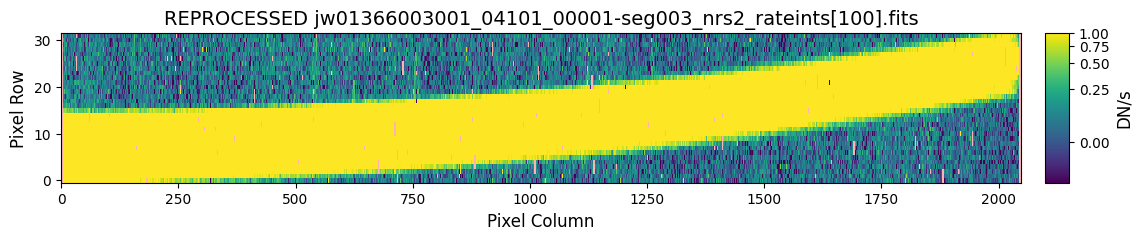

In [40]:
rate_file = rate_sci[-1]  # Show a rate file, as an example.
display_rate(rate_file, integration=100, vmin=-0.1, vmax=1, scale='asinh',
             aspect=10, title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec2Pipeline` Products

First, let's visually inspect that the 1/f noise was removed from the data.

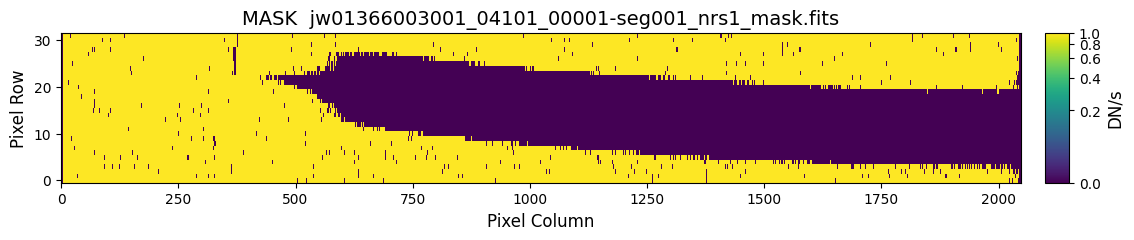

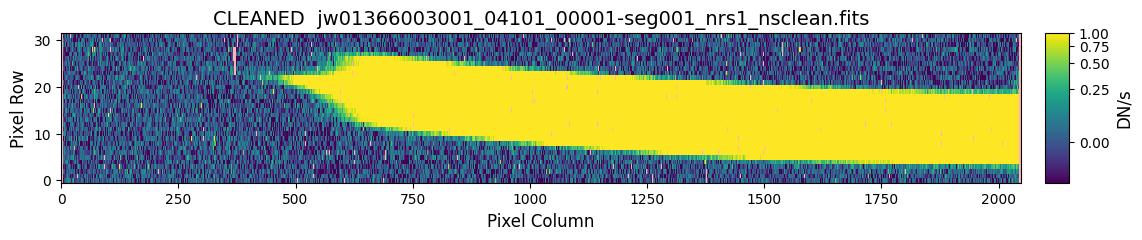

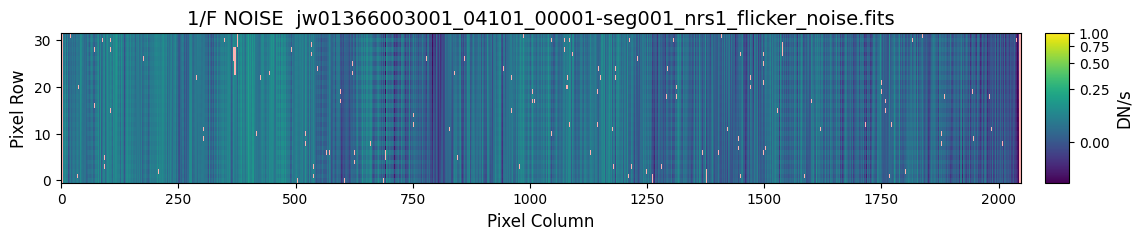

In [41]:
rate_file_cl = rate_sci_cl[0]  # Show a rate file, as an example.
noise = flicker_noise[0]
mask = masks[0]

display_rate(mask, integration=100, vmin=0, vmax=1,
             aspect=10, title_prefix='MASK ')
display_rate(rate_file_cl, integration=100, vmin=-0.1, vmax=1,
             aspect=10, scale='asinh', title_prefix='CLEANED ')
display_rate(noise, integration=100, vmin=-0.1, vmax=1,
             aspect=10, title_prefix='1/F NOISE ')

Now inspect the Stage 2 calibrated spectra. 

Trimming first/last 5 reference pixels with nan-values ...

NRS1 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     1263
  Total length of wavemap:     1263



Trimming first/last 5 reference pixels with nan-values ...

NRS2 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     2038
  Total length of wavemap:     2038



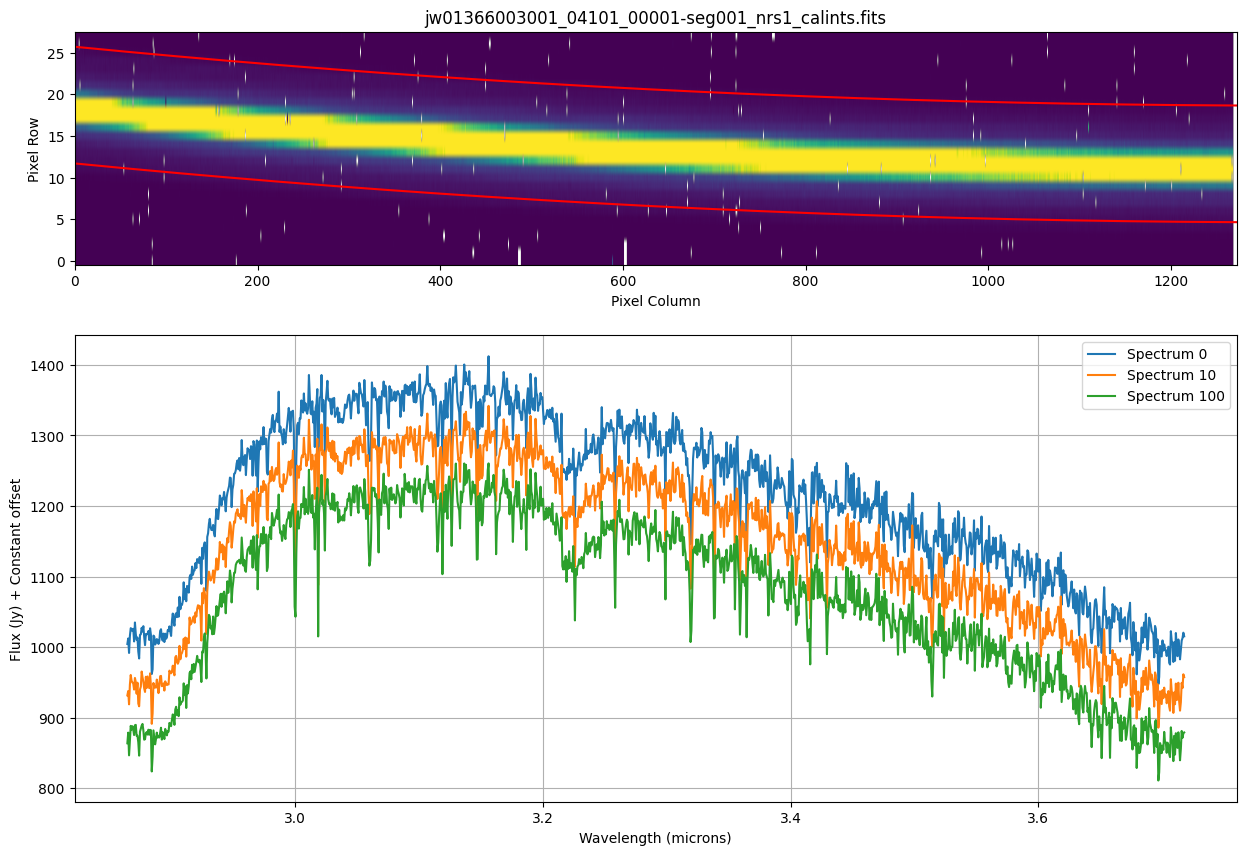

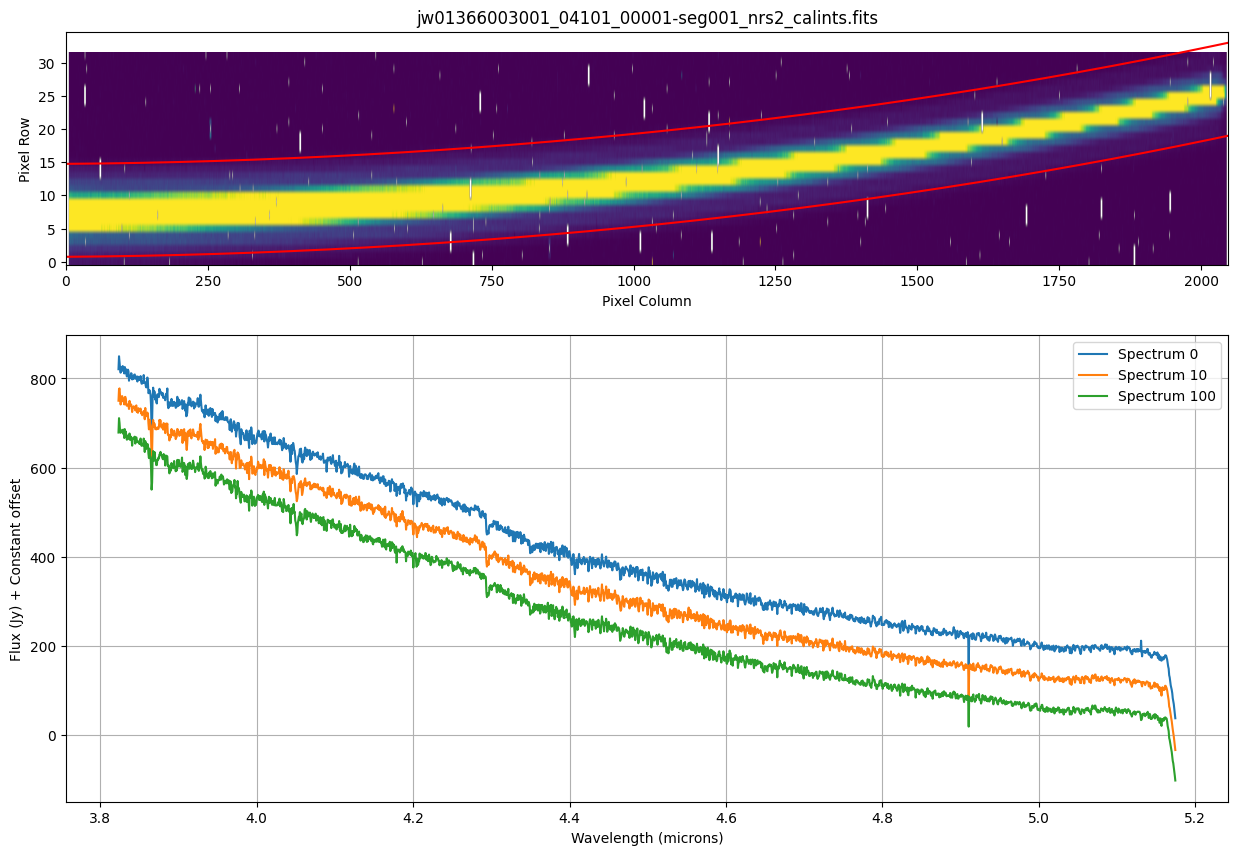

In [42]:
display_spectra(sci_x1d, integrations=[0, 10, 100], offsets=[0, 70, 140])

---

Next, we derive white light curves and a spectroscopic light curves from the large arrays we made and plot them.

* To produce a white light curve, we sum the flux from the full wavelength range of each extracted one-dimensional spectrum. Then we normalize the light curve by dividing the light curve flux to the median flux of the first twenty data points out-of-the-transit. We calculate and report the scatter using the first ~100 data points.

* While the white light curve provides information regarding the overall quality of the data, the light curves from each pixel (wavelength) contain information about the atmosphere of a transiting exoplanet. The second figure in the plot shows chromatic light curves (also known as wavelength maps). To produce them, we obtain a copy of all spectra and normalize each spectrum by its mean value.

* You may find that a light curve also exhibits the morphology of a transit event along with a step-function flux jump near the mid-transit. This flux jump (a decrease of flux in this case) is attributed to a 'tilt' event associated with one of the segments of the JWST mirror. A 'tilt' event is considered any uncommanded change in the tip-tilt orientation of a mirror segment and can be caused by a micrometeorite impact. For further details, please consult the following page: [JWST TSO noise sources](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources).

* In our plots below, we also correct for the tilt event by renormalizing the post-tilt event light curves. To do that, we divide these light curves by the mean out-of-transit post-tilt event flux

Trimming first/last 5 reference pixels with nan-values ...


Trimming first/last 5 reference pixels with nan-values ...
White Light Curve scatter (ppm):  233.0
White Light Curve scatter (ppm):  763.0


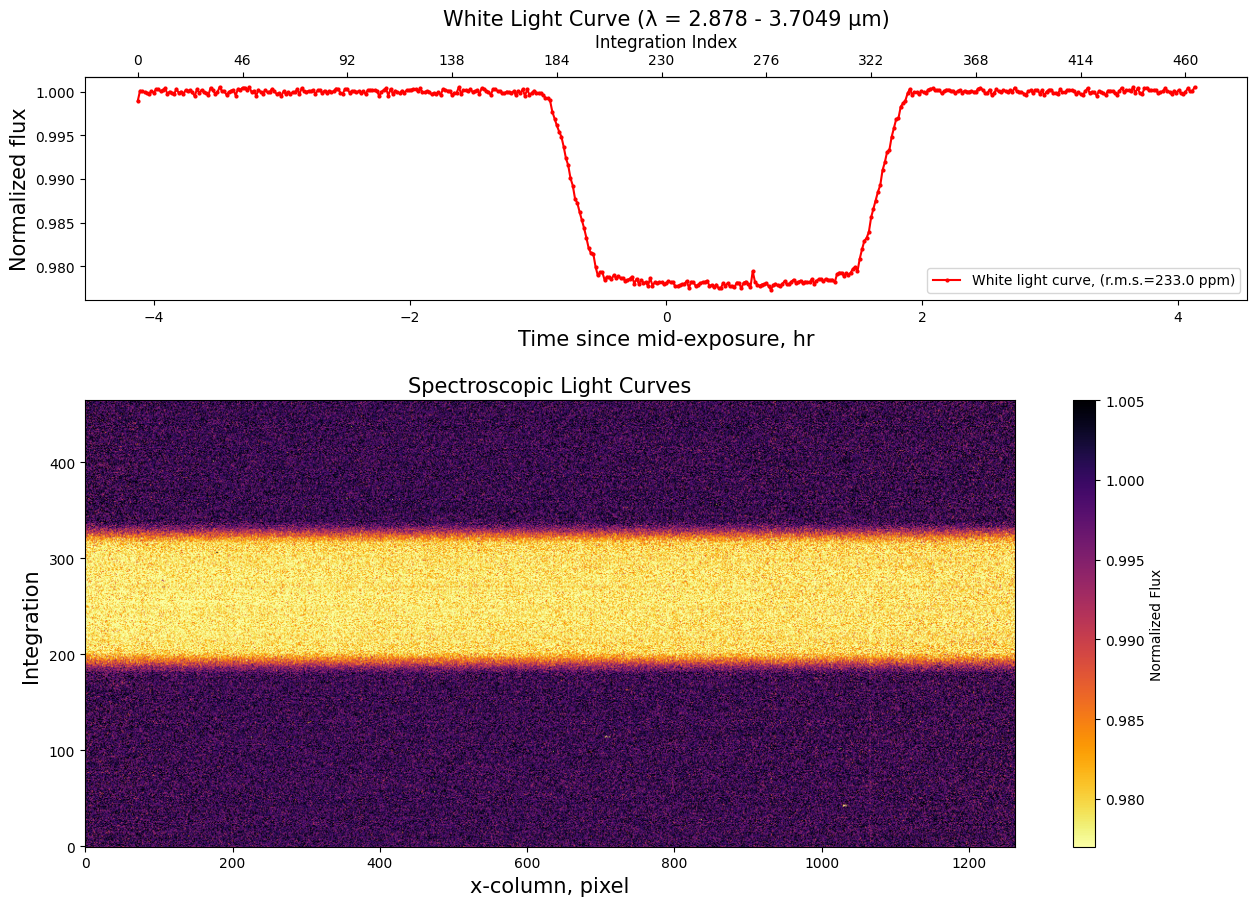

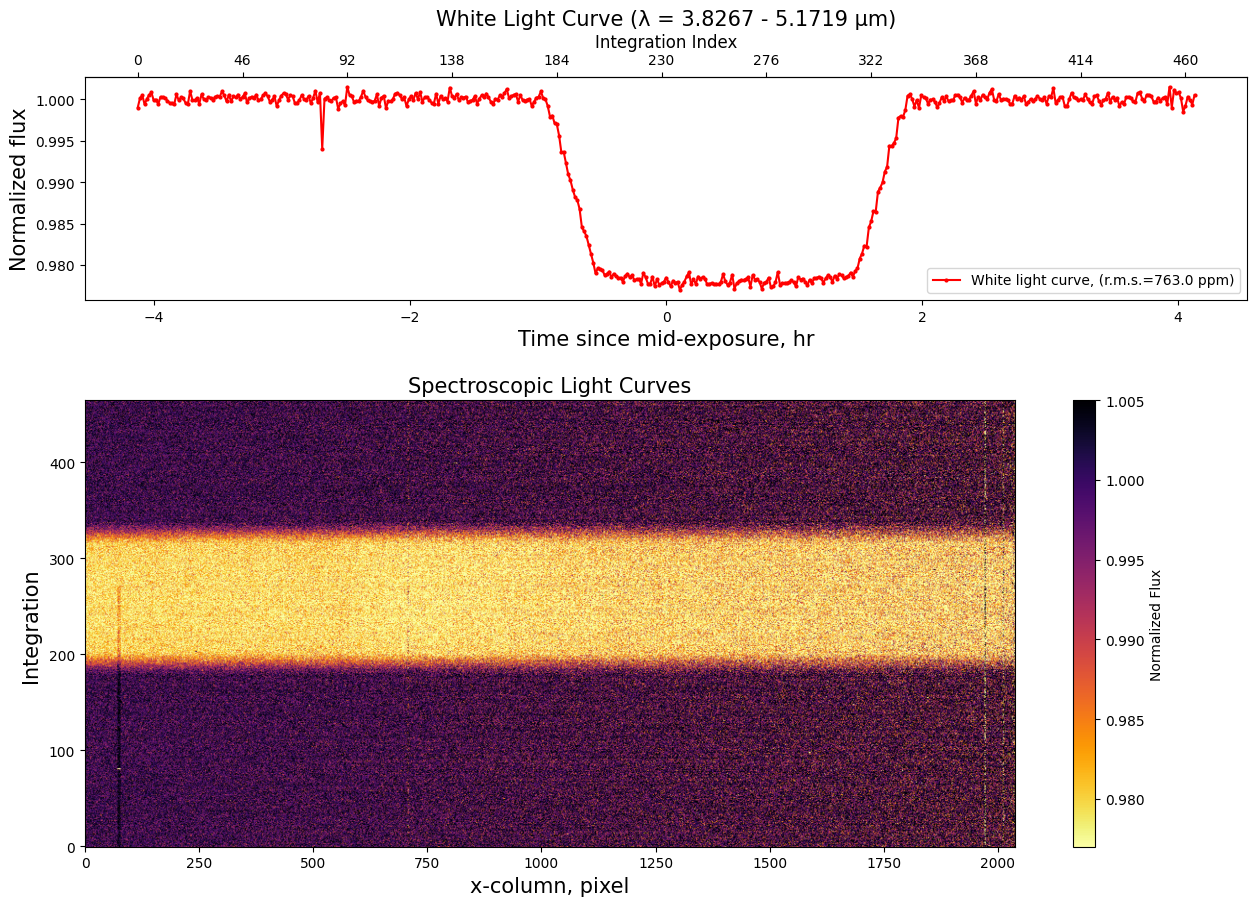

In [43]:
# Sort NRS1 from NRS2 files.
sci_x1d_nrs1 = [f for f in sci_x1d if "nrs1" in f]
sci_x1d_nrs2 = [f for f in sci_x1d if "nrs2" in f]

# Compile the NRS1 and NRS2 spectra into one array.
all_spec1D_nrs1, all_times_nrs1, wave_um_nrs1 = compile_segments(sci_x1d_nrs1)
all_spec1D_nrs2, all_times_nrs2, wave_um_nrs2 = compile_segments(sci_x1d_nrs2)

# Plot the light curves for each detector.
display_light_curve(all_spec1D_nrs1, all_times_nrs1, wave_um_nrs1,
                    total_flux_cols=(20, -20),  # Sum flux over integration range.
                    # Tilt event correction parameters:
                    correct_tilt_event=True,
                    before_transit=(0, 170),  # Before transit integration range.
                    tilt_event=270,  # Tilt event integration.
                    after_transit=(330, 460))  # After transit integration range.

display_light_curve(all_spec1D_nrs2, all_times_nrs2, wave_um_nrs2,
                    total_flux_cols=(5, -5),  # Sum flux over integration range.
                    # Tilt event correction parameters:
                    correct_tilt_event=True,
                    before_transit=(0, 170),  # Before transit integration range.
                    tilt_event=270,  # Tilt event integration.
                    after_transit=(330, 460))  # After transit integration range.

* The white light curve shows a relatively low scatter (230 ppm) for NRS1 and a slightly higher scatter (800 ppm) for NRS2.

* The 2D plots above show all extracted 1D spectra covering the transit event. The horizontal axis is the spectral direction (wavelength), and the vertical - each integration (time). The dark pixels correspond to the out-of-transit data (pre/post transit), the orange horizontal stripes indicate the ingress and egress portions, and the yellow stripe shows the in-transit part of the light curve. We have corrected the tilt event data by normalizing all spectra after integration 330 using the post-transit flux. The cells above can be rerun without correction for the tilt event. In this case, all light curves after the tilt event will look offset by a constant amount owing to the redistributed wavefront.

---

### 8.3 Display `Tso3Pipeline` Products

Inspect the Stage 3 combined calibrated spectra. The white light curve produced from Stage 3 is not corrected like above for any tilt events.

NRS1 White Light Curve scatter (ppm): 230.0
NRS2 White Light Curve scatter (ppm): 759.0


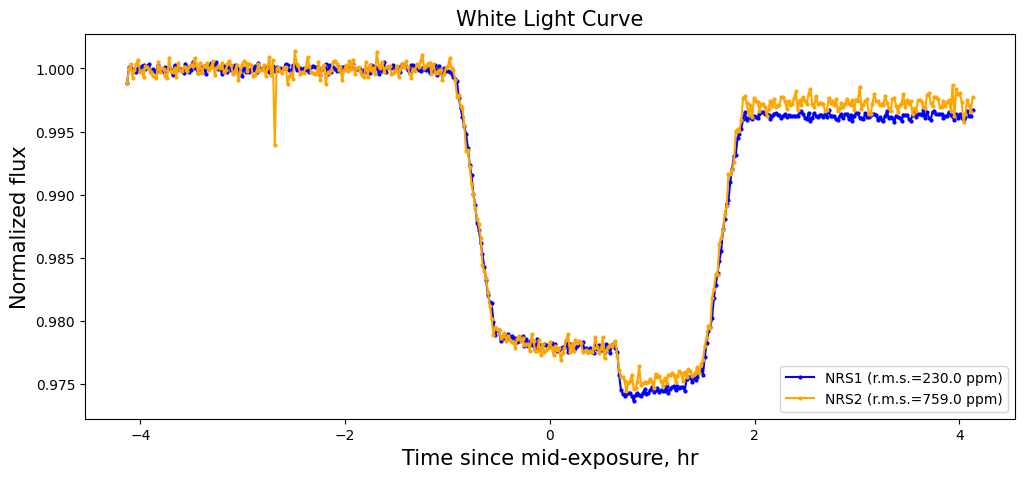

In [44]:
# Read the white light curve.
data = Table.read(stage3_whtlt[0], format="ascii.ecsv")


# Check if there is NRS2 data.
has_nrs2 = "MJD_UTC_NRS2" in data.colnames and "whitelight_flux_NRS2" in data.colnames

# Extract and normalize NRS1 white light fluxes.
mjd_nrs1 = data["MJD_UTC_NRS1"]
flux_nrs1 = data["whitelight_flux_NRS1"] / np.nanmedian(data["whitelight_flux_NRS1"][:100])

# Extract and normalize NRS2 white light fluxes if present.
if has_nrs2:
    mjd_nrs2 = data["MJD_UTC_NRS2"]
    flux_nrs2 = data["whitelight_flux_NRS2"] / np.nanmedian(data["whitelight_flux_NRS2"][:100])
else:
    mjd_nrs2 = None
    flux_nrs2 = None

# Calculate scatter.
sigma_wlc_nrs1 = np.sqrt(np.nanvar(flux_nrs1[2:100]))
print(f"NRS1 White Light Curve scatter (ppm): {round(float(sigma_wlc_nrs1) * 1e6, 0)}")
if has_nrs2:
    sigma_wlc_nrs2 = np.sqrt(np.nanvar(flux_nrs2[2:100]))
    print(f"NRS2 White Light Curve scatter (ppm): {round(float(sigma_wlc_nrs2) * 1e6, 0)}")

# Plot white light curve.
plt.figure(figsize=(12, 5))

# Plot NRS1.
plt.plot(
    (mjd_nrs1 - np.nanmean(mjd_nrs1)) * 24.0,
    flux_nrs1,
    color="blue",
    marker="o",
    markersize=2,
    label=f"NRS1 (r.m.s.={round(sigma_wlc_nrs1 * 1e6, 0)} ppm)"
)
# Plot NRS2.
plt.plot(
    (mjd_nrs2 - np.nanmean(mjd_nrs2)) * 24.0,
    flux_nrs2,
    color="orange",
    marker="o",
    markersize=2,
    label=f"NRS2 (r.m.s.={round(sigma_wlc_nrs2 * 1e6, 0)} ppm)"
)
plt.legend(loc="lower right")
plt.title("White Light Curve", fontsize=15)
plt.xlabel("Time since mid-exposure, hr", fontsize=15)
plt.ylabel("Normalized flux", fontsize=15)

# Set plot limits
#plt.ylim([0.965, 1.015])
plt.show()

<div class="alert alert-info">

We now have white and spectroscopic light curves ready for fitting (not covered in this notebook).

It should be pointed out that the workaround solutions lead to a lower white light curve scatter for this particular data set (approximately 70 ppm lower, or 160 ppm for NRS1). Two factors determine the difference:

1. The pixel replacement step in the workaround uses a nominal PSF profile constructed from adjacent columns (of a column that needs to be corrected) to identify high and low pixels in addition to the data quality flags.
2. At the time of writing, the spectral resampling step is unavailable in the STScI pipeline. Instead, in the workaround notebook, we fit for the star's centroid to locate and trace the spectra (without resampling) and perform aperture extraction using the trace.

</div>

---

## 9. Modifying the EXTRACT1D Reference File (as needed)

[extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) •
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data)


As of Build 11.3, the `extract_1d` step now uses a curved trace to extract the 1D spectra by default for un-resampled 2D spectra (resampling is skipped for BOTS data). As an example, we still provide a way to modify the extraction region if needed.

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

In [45]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec2Pipeline().get_reference_file(sci_cal, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0006.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0006.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    # S1600A1 full slit
    params["apertures"][0]["extract_width"] = 27
    params["apertures"][0].pop("nod2_offset")  # remove
    params["apertures"][0].pop("nod3_offset")  # remove
    params["apertures"][0].pop("nod5_offset")  # remove
    # params["apertures"][0]["xstart"] = 100  # lower x-index

# Write changes to a new file.
newData = json.dumps(params, indent=4)

# Add the suffix '_bots' to distinguish the file from the default version.
basename = os.path.basename(extract_1d_ref)[:-5]
extract_1d_ref_mod = os.path.join(basedir, f'{basename}_bots.json')
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [46]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.


In [47]:
# Re-extract the NRS2 1D spectra.
sci_cal_nrs2 = [f for f in sci_cal if "nrs2" in f]

for cal in sci_cal_nrs2:
    Extract1dStep.call(cal,
                       save_results=True,
                       output_dir=spec2_dir,
                       output_use_model=True,
                       suffix='x1dints_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       override_extract1d=extract_1d_ref_mod)

2025-09-24 15:48:01,943 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-09-24 15:48:02,342 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_calints.fits',).


2025-09-24 15:48:02,346 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1dints_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
  soss_wav

2025-09-24 15:48:09,060 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/jwst_nirspec_extract1d_0006_bots.json


2025-09-24 15:48:11,615 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:48:14,363 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:48:14,415 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:48:14,417 - jwst.extract_1d.extract - INFO - Aperture start/stop: 2.50 -> 28.50 (inclusive)


2025-09-24 15:48:14,441 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:48:14,513 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:48:19,156 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:48:21,629 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:48:24,103 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:48:24,356 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:48:24,596 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:48:24,741 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg001_nrs2_x1dints_mod.fits


2025-09-24 15:48:24,742 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-09-24 15:48:24,742 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:48:28,212 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-09-24 15:48:28,603 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_calints.fits',).


2025-09-24 15:48:28,607 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1dints_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
  soss_wav

2025-09-24 15:48:35,388 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/jwst_nirspec_extract1d_0006_bots.json


2025-09-24 15:48:38,063 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:48:40,657 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:48:40,709 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:48:40,712 - jwst.extract_1d.extract - INFO - Aperture start/stop: 2.50 -> 28.50 (inclusive)


2025-09-24 15:48:40,736 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:48:40,810 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:48:45,434 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:48:47,952 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:48:50,490 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:48:50,747 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:48:50,988 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:48:51,132 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg002_nrs2_x1dints_mod.fits


2025-09-24 15:48:51,133 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-09-24 15:48:51,133 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-09-24 15:48:54,557 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-09-24 15:48:54,956 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_calints.fits',).


2025-09-24 15:48:54,960 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1dints_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
  soss_wav

2025-09-24 15:49:01,715 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/jwst_nirspec_extract1d_0006_bots.json


2025-09-24 15:49:04,276 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-09-24 15:49:06,933 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-09-24 15:49:06,985 - jwst.extract_1d.extract - WARNING - The photom step has not been run.


2025-09-24 15:49:06,987 - jwst.extract_1d.extract - INFO - Aperture start/stop: 2.50 -> 28.50 (inclusive)


2025-09-24 15:49:07,011 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-09-24 15:49:07,083 - jwst.extract_1d.extract - INFO - Beginning loop over 155 integrations ...


2025-09-24 15:49:11,737 - jwst.extract_1d.extract - INFO - ... 50 integrations done


2025-09-24 15:49:14,296 - jwst.extract_1d.extract - INFO - ... 100 integrations done


2025-09-24 15:49:16,801 - jwst.extract_1d.extract - INFO - ... 150 integrations done


2025-09-24 15:49:17,057 - jwst.extract_1d.extract - INFO - All 155 integrations done


2025-09-24 15:49:17,300 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-09-24 15:49:17,449 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/BOTS/Obs003/stage2/jw01366003001_04101_00001-seg003_nrs2_x1dints_mod.fits


2025-09-24 15:49:17,449 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-09-24 15:49:17,450 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


Trimming first/last 5 reference pixels with nan-values ...

NRS2 Summary:
  Total number of time stamps: 465
  Total number of 1D spectra:  465
  Total number of columns:     2038
  Total length of wavemap:     2038



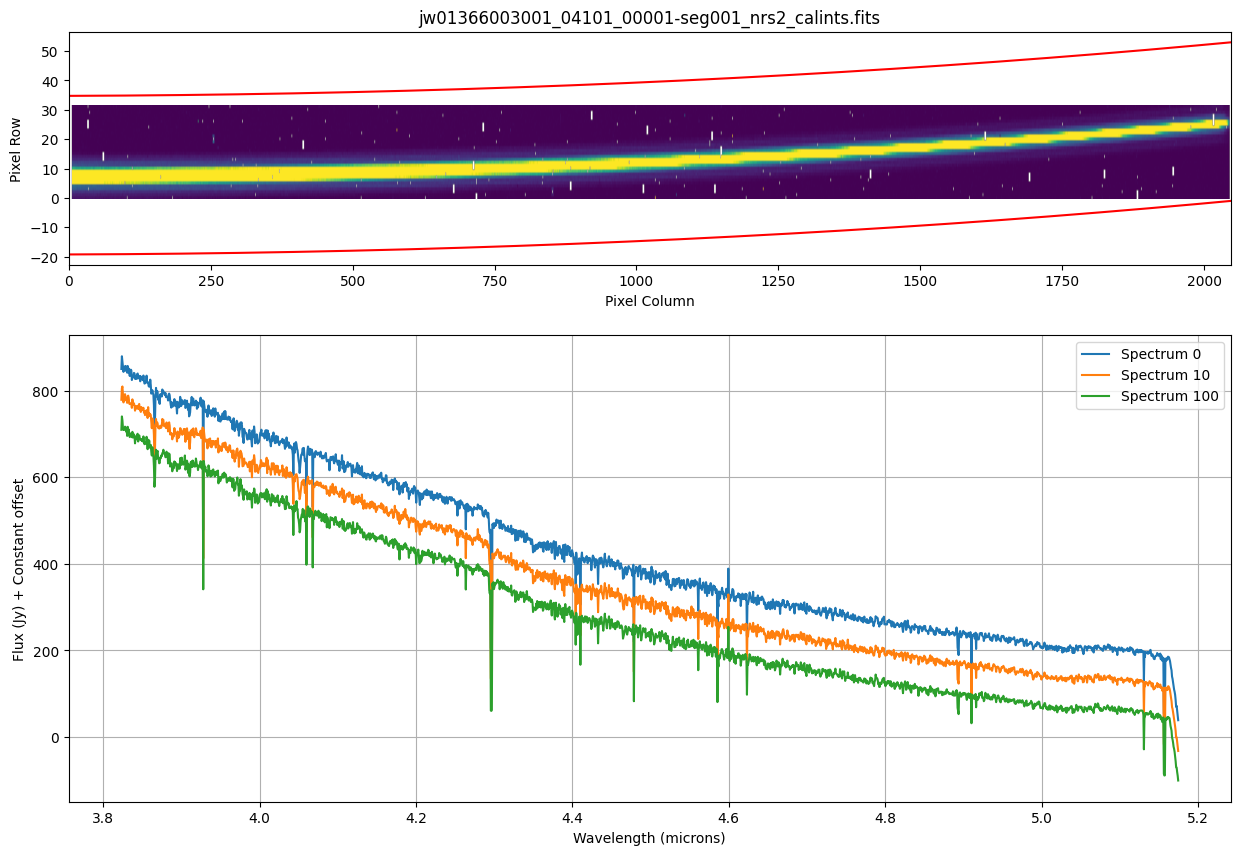

In [48]:
sci_x1d_mod = sorted(glob.glob(spec2_dir + '*nrs2_x1dints_mod.fits'))
display_spectra(sci_x1d_mod, integrations=[0, 10, 100], offsets=[0, 70, 140])

---

## Concluding Remarks

In this notebook, we demonstrated how to obtain white and spectroscopic light curves by (re-) running the three stages of the JWST pipeline. The saved data producs can now be provided to light curve fitting codes for measurements of the physical properties of the exoplanet (or other source with temporal variability) and obtaining a transmission spectrum. It should be pointed out that the analyses performed here are only a subset of the possible analyses one can perform, and are in no way the final word on _how_ JWST data _should_ be analyzed. This will be solidified more and more as data comes and best practices are established in the current and future cycles.

In conclusion, I would like to express my gratitude to the entire JWST team that has supported the creation of this notebook through discussions and testing, which have improved the notebook. In particular, special thanks to the Time-Series Observations Working Group at STScI, including Néstor Espinoza, Leonardo Ubeda, Sarah Kendrew, Elena Manjavacas, Brian Brooks, Mike Reagan, Loïc Albert, Everett Schlawin, Stephan Birkmann among others. To the NIRCam IDT team for multiple fruitful discussions, including Everett Schlawin, Thomas Beatty, Tom Greene and Jarron Leisenring. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the several JWST team members, including behind the pipeline and the mission itself, including and in no particular order Bryan Hilbert, Armin Rest, Anton Koekemoer, Alicia Canipe, Melanie Clarke, James Muzerolle, Kayli Glidic, Jeff Valenti and Karl Gordon. 

---

## Related Notebooks
* [JWebbinar in December 2023](https://github.com/exonik/JWebbinar2023-TSO/blob/main/Part2-Spec2.ipynb)
* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>

[Top of Page](#NIRSpec-BOTS-Pipeline-Notebook)